# AAO GALAH RESEARCH JAN-APR 2016

### Missy McIntosh, Gayandhi de Silva, Jeffrey Simpson
http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc111+ad2k+ad2000.coo

#### Check if there are any known open clusters in GALAH
#### This is a very slow python script....

# Table-of-Contents


[Load 2Mass database](#Load-2Mass-Database) 

[Select Clusters](#Select-Clusters) 

[Webda Data Retrieval](#Webda-Data-Retrieval) 

[Database Search](#Database-Search) 

[Filtering](#Filtering) 

[Looping](#Looping) 


In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK4
import time
from tqdm import *
import pandas as pd
import codecs
import numpy as np
from lxml import html
from lxml import etree
import requests
import csv
from numpy import genfromtxt
import cython
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                  reload_support=True)
import glob
import pylab as py
from scipy import optimize
from scipy.stats import chisquare
from scipy.stats import norm




/Users/mmcintosh/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Equation for Gaussian
def gauss(x, a, b, c):
    return a * py.exp(-(x - b)**2.0 / (2 * c**2))

def coordseparation(a, b):
    # a = [ra1, dec1]
    # b= [ra2, dec2]
    c1 = SkyCoord(a[0],a[1], unit='deg')
    c2 = SkyCoord(b[0],b[1], unit='deg')
    sep = c1.separation(c2)
    return(sep.degree) 

def coordconvert(ra, dec):
    c = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    newra = c.ra.degree
    newdec = c.dec.degree
    return(newra, newdec)

def getwebda(name):
    try:
        # fetch coordinates 
        linkpt1 = "http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?"
        linkpt2 = "+ad2k+ad2000.coo"
        link = linkpt1+name+linkpt2
        page = requests.get(link)
    except:
        print("Couldn't find coordinate link for", name)
        print(link)
    try:
        tree = html.fromstring(page.content)
        text = str(etree.tostring(tree))
        temp = text.split(r'\n\n ')
        temp = temp[-1]
        temp = temp.split(r'\n')
        temp = temp[:-2]
        temp = [x.split(r'  ') for x in temp]
        temp = [list(filter(None, x)) for x in temp]
        subsetcid = np.asarray([x[0] for x in temp])
        coords = [coordconvert(coord[2], coord[3]) for coord in temp]
        subsetra = np.asarray([coord[0] for coord in coords])
        subsetdec = np.asarray([coord[1] for coord in coords])
    except:
        print("error with parsing coords html")
        print(link)
        return(None, None, None, None, None, None)
        
    # fetch magnitudes 
    try:
        linkpt1 = "http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?"
        linkpt2 = "+ubvpg+ubv.pgo"
        link = linkpt1+name+linkpt2
        page = requests.get(link)
    except:
        print("Couldn't find magnitude link for", name)
        print(link)
    try:
        tree = html.fromstring(page.content)
        text = str(etree.tostring(tree))
        temp = text.split(r'\n\n ')
        temp = temp[-1]
        temp = temp.split(r'\n')
        temp = temp[:-2]
        temp = [x.split(r'  ') for x in temp]
        temp = [list(filter(None, x)) for x in temp]
        subsetmid =np.asarray([x[0] for x in temp])
        subsetvmag = np.asarray([float(x[2]) for x in temp])
        subsetbv = np.asarray([float(x[3]) for x in temp])
    except:
        print("error with parsing mags html")
        print(link)
        return(None, None, None, None, None, None)
    
    
        
    # we only want data where both RA/DEC and Vmag are available
    both = list(set(subsetcid).intersection(subsetmid))
    
    index = np.in1d(subsetcid, both).nonzero()
    bothra = subsetra[index]
    bothdec = subsetdec[index]
    bothcid = subsetcid[index]

    index = np.in1d(subsetmid, both).nonzero()
    bothvmag = subsetvmag[index]
    bothmid = subsetmid[index]
    bothbv = subsetbv[index]

    return(bothcid, bothra, bothdec, bothmid, bothvmag, bothbv)


In [3]:
%%cython
import numpy as np

def pbsearch(sorted_data, subset, tolerance):
    searched_arr = []
    matched_arr = []
    
    cdef int i, n, N, j, index
    cdef double lower, upper, tol
    N = len(subset)
    for i in range(N):
        a = subset[i]
        # a function of the declination
        tol = abs(tolerance*np.cos(a[1]))
        ra = sorted_data[:]
        n = list.__len__(ra)
        #if (i % 20 == 0):
        #    print(i, N)
        for j in range(n):
            if (n <= 1):
                break
            index = int(n/2)
            entry = ra[index]
            lower = a[0] - tol
            upper = a[0] + tol
            
            if lower > entry[0]:
                ra = ra[index:]
            elif upper < entry[0]:
                ra = ra[:(index)]
            else:
                # ra match, check dec
                if (abs(a[1] - entry[1]) <= tol):
                    matched_arr.append(entry)
                    searched_arr.append(a)
                    
                ra.pop(index)
                if not ra:
                    break
                
            try:
                n = list.__len__(ra)
            except:
                break
                
    

    print("searched for a subset of ", len(subset), "Coords against 2mass list of", len(sorted_data))
    print("Coord matches: ", len(matched_arr), "with a tolerance of ", tolerance)
    return(searched_arr,matched_arr)

# Load-2Mass-Database

In [4]:

# Read in Jeffrey's 2Mass input database Name, RA, and DEC information
# note this data is presorted by RA

df = pd.read_csv('jsortedgal.csv', delimiter=',',index_col=False, header=0, dtype=float)
df.columns = ["ID", "VMag", "RA", "DEC", "B","V"]

df.sort_values("RA")
#all(l[i] <= l[i+1] for i in np.arange(len(l)-1))
# there's some weird sorting problems. A few are multiplied by 10^-4 for some reason
l = (df["RA"])
problems = []
for i in np.arange(len(l)-1):
    if (l[i] <= l[i+1]):
        continue
    else:
        problems.append(i+1)
print(len(problems), "weird sorts")
for problem in problems:
    df["RA"][problem] = df["RA"][problem]*10000



10 weird sorts


In [5]:
print(len(df))
twomass_ident = np.asarray(df["ID"])
twomass_vmag = np.asarray(df["VMag"])
twomass_ra = np.asarray(df["RA"])
twomass_dec = np.asarray(df["DEC"])
twomass_bv = np.asarray(df["B"] - df["V"])

twomasszip = list(zip(twomass_ra, twomass_dec, twomass_vmag, twomass_bv, twomass_ident))

9073309


# Select-Clusters 

In [6]:


#I got this html from querying webda for all clusters with J2000 coordinate data available

# connect to webda database
# grab each cluster name
## search this page: http://www.univie.ac.at/webda/cgi-bin/seldb.cgi?
## for links like http://www.univie.ac.at/webda/cgi-bin/ocl_page.cgi?dirname=wes02
## and grab the string after dirname=  
# these are the clusters that have coordinate data
# do the same for UBV data, and take only the names of clusters that have both
#http://www.univie.ac.at/webda/webda_selection.html
#I queried for UBV photoelectric observations
#and Equatorial coordinates J2000 and saved the resulting table data to acquire the names of the clusters for which this data was available


f = codecs.open("webdacoords.html", "r", "utf-8")
page = f.read()
split = page.split("dirname=")
coordnames = [split[x].split('"')[0] for x in np.arange(len(split))]
coordnames = coordnames[1:]
f = codecs.open("webdamag.html", "r", "utf-8")
page = f.read()
split = page.split("dirname=")
magnames = [split[x].split('"')[0] for x in np.arange(len(split))]
magnames = magnames[1:]

wnindices = [i for (i, x) in enumerate(magnames) if x in coordnames]
webnames = [magnames[i] for i in wnindices]
print(len(webnames))

cnindices = [i for (i, x) in enumerate(magnames) if x in webnames]
isplit = [split[i] for i in cnindices]
temp = [isplit[x].split(";")[1] for x in np.arange(len(isplit))][1:]
clusternames = [temp[x].split("&")[0] for x in np.arange(len(temp))]

# read in dias results
data = genfromtxt('dias_wtol0.005556_matched125.csv', delimiter=',', dtype=None)
data = data[0]
diasnames = [row.decode('UTF-8') for row in data]

fwnindices = [i for (i, x) in enumerate(clusternames) if x in diasnames]
#print([list(clusternames)[i] for i in fwnindices])
filteredwebnames = [(webnames)[i] for i in fwnindices]
#print(filteredwebnames)
#print(len(filteredwebnames))

# it looks like the first elements don't match
names = filteredwebnames[1:]


428


In [9]:
print(errnames, len(errnames))

['bl01', 'bo15', 'ho18', 'ic4665', 'mel066', 'mel071', 'ngc1662', 'ngc2204', 'ngc2215', 'ngc2287', 'ngc2506', 'ngc2516', 'ngc2682', 'ngc6087', 'ngc6208', 'ngc6716'] 16


# Webda-Data-Retrieval

In [173]:

tol = 0.005556
coorddiff = []
y = 15

#0 has only 1 that is 1.4 away, 
#1 had 1 0.1 away
#4 had 2, 1 and 0.5 away
#5 has 6 but gets some nans
# 6 has 24 and nans
# 10 had 1 that might be a match, but the rest were >2 away
# 12 was really really weird and had nans, also really long, like, 3000
# 13, 14, 15 have everything the same distance away

#for y in tqdm(range(len(names))):
names = errnames
name = names[y]
subsetid, subsetra, subsetdec, subsetmid, subsetvmag, subsetbv = getwebda(name)
print(name, len(subsetid))
if (subsetid) is None:
    print("skipping", name)
    #continue

ngc6716 21


# Database-Search


In [174]:
subsetzip = list(zip(subsetra, subsetdec, subsetvmag, subsetbv, subsetmid,subsetid))
print("data retrived, starting pbsearch")
searched_ra, matched_ra = pbsearch(twomasszip, subsetzip, tol)

data retrived, starting pbsearch
('searched for a subset of ', 335, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 310, 'with a tolerance of ', 0.005556)


In [178]:
print(matched_ra[1])
print(searched_ra[1])

(283.67240699999996, -19.909775, 13.574000000000002, 1.1430000000000007, 4210929.0)
(283.67241666666661, -19.909777777777776, 11.91, 0.46000000000000002, ' 0005', ' 0006')


[1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 0.13473678047659141, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 0.13473678047659141, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.7987175987633985, 1.798717598763398

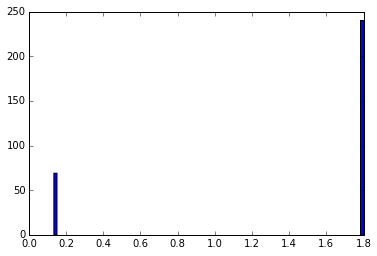

In [175]:
# take the euclidean distance between coordinates, magnitude, and color
a = [np.asarray(x[:4]) for x in searched_ra]
b = [np.asarray(x[:4]) for x in matched_ra]

dists = [np.linalg.norm(a[i]-b[i]) for i in np.arange(len(a))]
dists = [dists[~np.isnan(x)] for x in dists]
print(dists)
plt.hist(dists, bins = 100)
plt.show()

# Filtering

In [138]:
# find the repeat matches, and save those who have the lesser distance
# how do I quantify how sure I am the lesser one is the true one? 
matchedid = []
searchedid = []
d = []
for i in np.arange(len(matched_ra)):
    matchedid.append(matched_ra[i][4])
    searchedid.append(searched_ra[i][4])

tmp = []
for j in np.arange(len(searchedid)):
    x = [i for i, y in enumerate(searchedid) if y == searchedid[j]]
    tmp.append(x)
    
bar = []
for entry in np.unique(tmp):
    try:
        if len(entry) > 1:
            foo = [dists[x] for x in entry]
            #print(entry, foo)
            minindex = [i for i, j in enumerate(foo) if j == min(foo)]
            minentry = entry[minindex[0]]
            #print(minentry, dists[minentry])
            bar.append(minentry)
        else:
            #print(entry, dists[entry[0]])
            bar.append(entry[0])
    except:
        bar.append(entry)


In [21]:
print(np.unique(tmp))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [139]:
# so bar has the closest ones and the non-repeated ones. How far away are these?
closest = np.asarray([dists[x] for x in bar])

# guess a high number of bins
bins = 20#14
data = py.hist(closest, bins = bins)

# is it too small? observed and expected frequencies should be at least 5: http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chisquare.html
# grab number in each bin, check that most of them are above 5, otherwise decrease bin number and do it again
thresh = 0.7
toomanybins = len([x for x in data[0] if x >= 5])/len(data[0]) < thresh

while toomanybins:
    bins = bins - 1
    data = py.hist(closest, bins = bins)
    toomanybins = len([x for x in data[0] if x >= 5])/len(data[0]) < thresh
print("using",bins, "bins")
plt.close()

using 4 bins


In [148]:
bins=40

Power_divergenceResult(statistic=449758.23844490485, pvalue=0.0) 12155.6280661


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


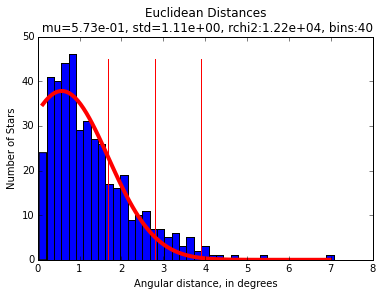

In [149]:
data = py.hist(closest, bins = bins)
# Generate data from bins as a set of points 
x = [0.5 * (data[1][i] + data[1][i+1]) for i in range(len(data[1])-1)]
y = data[0]

popt, pcov = optimize.curve_fit(gauss, x, y)
x_fit = py.linspace(x[0], x[-1], 100)
y_fit = gauss(x_fit, *popt)


plt.plot(x_fit, y_fit, lw=4, color="r")

cx_fit = py.linspace(x[0], x[-1], len(x))
cy_fit = gauss(cx_fit, *popt)

# check degrees of freedom - number of bins I think
# does this give reduced chi squared? 
# near 1 is a good fit
chi2 = (chisquare(f_obs=y,f_exp=cy_fit))
rchi2 = chi2[0]/(len(x)-3)
print(chi2, rchi2)
plt.xlabel('Angular distance, in degrees')
plt.ylabel('Number of Stars')
plt.title('Euclidean Distances \n mu={0:.2e}, std={1:.2e}, rchi2:{2:.2e}, bins:{3}'.format(popt[1], popt[2], rchi2, bins))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# draw 1,2,3 sigma line
for i in [1,2,3]:  
    sx = [popt[1]+popt[2]*i]*(np.max(data[0]))
    sy = np.arange(np.max(data[0]))
    plt.plot(sx,sy, color="r")
plt.show()

In [150]:
# maybe just take the data w/i 1 sigma of the mean? 

s = 1
mean = popt[1]
std = popt[2]
coordmask = np.asarray([int(dist < (mean+s*std) and dist > (mean-s*std)) for dist in dists])
print("selected", sum(coordmask), "from",len(coordmask))
coordfiltered_searched_ra = np.asarray(searched_ra)[coordmask == 1]
coordfiltered_matched_ra = np.asarray(matched_ra)[coordmask == 1]





selected 314 from 434


In [130]:
print(coordfiltered_searched_ra)
print(np.where(dists)[0])

[['101.5276125' '-20.7076388889' '9.5' '-0.04' ' 0005' ' 0005']
 ['101.477008333' '-20.7189527778' '9.41' '-0.01' ' 0020' ' 0020']
 ['101.592495833' '-20.6966083333' '10.23' '1.01' ' 0046' ' 0046']
 ['101.614308333' '-20.6583138889' '10.41' '-0.01' ' 0049' ' 0049']
 ['101.395858333' '-20.7206805556' '9.07' '-0.04' ' 0061' ' 0061']
 ['101.431783333' '-20.6458083333' '9.68' '-0.07' ' 0063' ' 0063']
 ['101.354154167' '-20.6737083333' '10.83' '0.01' ' 0067' ' 0067']
 ['101.546933333' '-20.8131083333' '9.89' '-0.02' ' 0120' ' 0120']
 ['101.379216667' '-20.7715361111' '10.92' '0.08' ' 0122' ' 0122']
 ['101.709991667' '-20.7390888889' '11.01' '0.08' ' 0123' ' 0123']]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [151]:
N = sum(coordmask)
if N > 0:

    print(N, "matches for", name, "for tolerance", tol)
    filename = "filteredresults/"+name+"_wtol"+str(tol)+"_matched"+str(N)+'.csv'
    # subsetra, subsetdec, subsetvmag, subsetbv, subsetmid, subsetid
    # twomass_ra, twomass_dec, twomass_vmag, twomass_bv, twomass_ident
    header = ["webdacoordid", "webdaras", "webdadecs", "webdamagid", "webdavmags", "webdabv","galahids", "twomassras", "twomassdecs", "twomassvmags", "twomassbv"]
    with open(filename, 'w', newline='') as fp:
        a = csv.writer(fp, delimiter=',')
        a.writerow(header)
        for i in np.arange(N):
            data = [coordfiltered_searched_ra[i][5], coordfiltered_searched_ra[i][0], coordfiltered_searched_ra[i][1], coordfiltered_searched_ra[i][4], coordfiltered_searched_ra[i][2], coordfiltered_searched_ra[i][3], coordfiltered_matched_ra[i][4], coordfiltered_matched_ra[i][0], coordfiltered_matched_ra[i][1], coordfiltered_matched_ra[i][2], coordfiltered_matched_ra[i][3]]
            a.writerow(data)
else:
    print("No matches for", name, "for tolerance", tol)

314 matches for ngc2516 for tolerance 0.005556


# Looping

  0%|          | 0/946 [00:00<?, ?it/s]

ale01
error with parsing mags html

  0%|          | 1/946 [00:04<1:16:50,  4.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale01+ubvpg+ubv.pgo
Retrieval error. Skipping ale01
ale02
error with parsing mags html

  0%|          | 2/946 [00:06<1:02:53,  4.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale02+ubvpg+ubv.pgo
Retrieval error. Skipping ale02
ale03
error with parsing mags html

  0%|          | 3/946 [00:09<54:35,  3.47s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale03+ubvpg+ubv.pgo
Retrieval error. Skipping ale03
ale05
error with parsing mags html

  0%|          | 4/946 [00:11<48:41,  3.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale05+ubvpg+ubv.pgo
Retrieval error. Skipping ale05
ale06
error with parsing mags html

  1%|          | 5/946 [00:13<46:28,  2.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale06+ubvpg+ubv.pgo
Retrieval error. Skipping ale06
ale08
error with parsing mags html

  1%|          | 6/946 [00:16<45:42,  2.92s/it]WARNING: IllegalSecondWarning: 'second' was found  to be '60.0', which is not in range [0,60). Treating as 0 sec, +1 min [astropy.coordinates.angle_utilities]



http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale08+ubvpg+ubv.pgo
Retrieval error. Skipping ale08
ale09
error with parsing mags html

  1%|          | 7/946 [00:27<1:23:13,  5.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale09+ubvpg+ubv.pgo
Retrieval error. Skipping ale09
ale10
error with parsing mags html

  1%|          | 8/946 [00:35<1:35:36,  6.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale10+ubvpg+ubv.pgo
Retrieval error. Skipping ale10
ale12
error with parsing mags html

  1%|          | 9/946 [00:41<1:36:10,  6.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale12+ubvpg+ubv.pgo
Retrieval error. Skipping ale12
ale13
error with parsing mags html

  1%|          | 10/946 [00:50<1:49:35,  7.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale13+ubvpg+ubv.pgo
Retrieval error. Skipping ale13
ale19
error with parsing mags html

  1%|          | 11/946 [00:53<1:29:16,  5.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale19+ubvpg+ubv.pgo
Retrieval error. Skipping ale19
ale20
error with parsing mags html

  1%|▏         | 12/946 [00:55<1:11:05,  4.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale20+ubvpg+ubv.pgo
Retrieval error. Skipping ale20
ale21
error with parsing mags html

  1%|▏         | 13/946 [00:58<1:01:51,  3.98s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale21+ubvpg+ubv.pgo
Retrieval error. Skipping ale21
ale53
error with parsing mags html

  1%|▏         | 14/946 [01:36<3:39:57, 14.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ale53+ubvpg+ubv.pgo
Retrieval error. Skipping ale53
ali01
error with parsing mags html

  2%|▏         | 15/946 [01:37<2:42:15, 10.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ali01+ubvpg+ubv.pgo
Retrieval error. Skipping ali01
ali05
error with parsing mags html

  2%|▏         | 16/946 [01:40<2:04:23,  8.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ali05+ubvpg+ubv.pgo
Retrieval error. Skipping ali05
ant01
error with parsing mags html

  2%|▏         | 17/946 [01:42<1:36:30,  6.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ant01+ubvpg+ubv.pgo
Retrieval error. Skipping ant01
ascc001
error with parsing mags html

  2%|▏         | 18/946 [01:43<1:15:32,  4.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc001+ubvpg+ubv.pgo
Retrieval error. Skipping ascc001
ascc002
error with parsing mags html

  2%|▏         | 19/946 [01:46<1:02:12,  4.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc002+ubvpg+ubv.pgo
Retrieval error. Skipping ascc002
ascc003
error with parsing mags html

  2%|▏         | 20/946 [01:47<52:38,  3.41s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc003+ubvpg+ubv.pgo
Retrieval error. Skipping ascc003
ascc004
error with parsing mags html

  2%|▏         | 21/946 [01:50<46:28,  3.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc004+ubvpg+ubv.pgo
Retrieval error. Skipping ascc004
ascc005
error with parsing mags html

  2%|▏         | 22/946 [01:51<39:52,  2.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc005+ubvpg+ubv.pgo
Retrieval error. Skipping ascc005
ascc006
error with parsing mags html

  2%|▏         | 23/946 [01:53<37:18,  2.43s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc006+ubvpg+ubv.pgo
Retrieval error. Skipping ascc006
ascc007
error with parsing mags html

  3%|▎         | 24/946 [01:55<34:44,  2.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc007+ubvpg+ubv.pgo
Retrieval error. Skipping ascc007
ascc008
error with parsing mags html

  3%|▎         | 25/946 [01:58<38:17,  2.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc008+ubvpg+ubv.pgo
Retrieval error. Skipping ascc008
ascc009
error with parsing mags html

  3%|▎         | 26/946 [02:00<34:21,  2.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc009+ubvpg+ubv.pgo
Retrieval error. Skipping ascc009
ascc010
error with parsing mags html

  3%|▎         | 27/946 [02:02<33:24,  2.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc010+ubvpg+ubv.pgo
Retrieval error. Skipping ascc010
ascc011
error with parsing mags html

  3%|▎         | 28/946 [02:04<31:47,  2.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc011+ubvpg+ubv.pgo
Retrieval error. Skipping ascc011
ascc012
error with parsing mags html

  3%|▎         | 29/946 [02:06<30:40,  2.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc012+ubvpg+ubv.pgo
Retrieval error. Skipping ascc012
ascc013
error with parsing mags html

  3%|▎         | 30/946 [02:08<34:04,  2.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc013+ubvpg+ubv.pgo
Retrieval error. Skipping ascc013
ascc014
error with parsing mags html

  3%|▎         | 31/946 [02:10<32:23,  2.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc014+ubvpg+ubv.pgo
Retrieval error. Skipping ascc014
ascc015
error with parsing mags html

  3%|▎         | 32/946 [02:12<29:57,  1.97s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc015+ubvpg+ubv.pgo
Retrieval error. Skipping ascc015
ascc016
error with parsing mags html

  3%|▎         | 33/946 [02:14<32:06,  2.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc016+ubvpg+ubv.pgo
Retrieval error. Skipping ascc016
ascc017
error with parsing mags html

  4%|▎         | 34/946 [02:16<30:12,  1.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc017+ubvpg+ubv.pgo
Retrieval error. Skipping ascc017
ascc018
error with parsing mags html

  4%|▎         | 35/946 [02:18<30:48,  2.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc018+ubvpg+ubv.pgo
Retrieval error. Skipping ascc018
ascc019
error with parsing mags html

  4%|▍         | 36/946 [02:21<32:56,  2.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc019+ubvpg+ubv.pgo
Retrieval error. Skipping ascc019
ascc020
error with parsing mags html

  4%|▍         | 37/946 [02:23<35:51,  2.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc020+ubvpg+ubv.pgo
Retrieval error. Skipping ascc020
ascc021
error with parsing mags html

  4%|▍         | 38/946 [02:27<39:27,  2.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc021+ubvpg+ubv.pgo
Retrieval error. Skipping ascc021
ascc022
error with parsing mags html

  4%|▍         | 39/946 [02:28<35:10,  2.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc022+ubvpg+ubv.pgo
Retrieval error. Skipping ascc022
ascc023
error with parsing mags html

  4%|▍         | 40/946 [02:30<33:04,  2.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc023+ubvpg+ubv.pgo
Retrieval error. Skipping ascc023
ascc024
error with parsing mags html

  4%|▍         | 41/946 [02:32<31:09,  2.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc024+ubvpg+ubv.pgo
Retrieval error. Skipping ascc024
ascc025
error with parsing mags html

  4%|▍         | 42/946 [02:34<29:40,  1.97s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc025+ubvpg+ubv.pgo
Retrieval error. Skipping ascc025
ascc026
error with parsing mags html

  5%|▍         | 43/946 [02:35<28:12,  1.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc026+ubvpg+ubv.pgo
Retrieval error. Skipping ascc026
ascc027
error with parsing mags html

  5%|▍         | 44/946 [02:37<27:29,  1.83s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc027+ubvpg+ubv.pgo
Retrieval error. Skipping ascc027
ascc028
error with parsing mags html

  5%|▍         | 45/946 [02:39<28:27,  1.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc028+ubvpg+ubv.pgo
Retrieval error. Skipping ascc028
ascc029
error with parsing mags html

  5%|▍         | 46/946 [02:41<28:38,  1.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc029+ubvpg+ubv.pgo
Retrieval error. Skipping ascc029
ascc030
error with parsing mags html

  5%|▍         | 47/946 [02:43<28:46,  1.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc030+ubvpg+ubv.pgo
Retrieval error. Skipping ascc030
ascc031
error with parsing mags html

  5%|▌         | 48/946 [02:45<27:56,  1.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc031+ubvpg+ubv.pgo
Retrieval error. Skipping ascc031
ascc032
error with parsing mags html

  5%|▌         | 49/946 [02:47<31:56,  2.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc032+ubvpg+ubv.pgo
Retrieval error. Skipping ascc032
ascc033
error with parsing mags html

  5%|▌         | 50/946 [02:53<46:53,  3.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc033+ubvpg+ubv.pgo
Retrieval error. Skipping ascc033
ascc034
error with parsing mags html

  5%|▌         | 51/946 [02:55<40:44,  2.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc034+ubvpg+ubv.pgo
Retrieval error. Skipping ascc034
ascc035
error with parsing mags html

  5%|▌         | 52/946 [02:57<37:30,  2.52s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc035+ubvpg+ubv.pgo
Retrieval error. Skipping ascc035
ascc036
error with parsing mags html

  6%|▌         | 53/946 [02:58<33:27,  2.25s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc036+ubvpg+ubv.pgo
Retrieval error. Skipping ascc036
ascc037
error with parsing mags html

  6%|▌         | 54/946 [03:00<30:31,  2.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc037+ubvpg+ubv.pgo
Retrieval error. Skipping ascc037
ascc038
error with parsing mags html

  6%|▌         | 55/946 [03:02<29:33,  1.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc038+ubvpg+ubv.pgo
Retrieval error. Skipping ascc038
ascc039
error with parsing mags html

  6%|▌         | 56/946 [03:04<29:47,  2.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc039+ubvpg+ubv.pgo
Retrieval error. Skipping ascc039
ascc040
error with parsing mags html

  6%|▌         | 57/946 [03:06<29:01,  1.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc040+ubvpg+ubv.pgo
Retrieval error. Skipping ascc040
ascc041
error with parsing coords html

  6%|▌         | 58/946 [03:07<24:23,  1.65s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc041+ad2k+ad2000.coo
Retrieval error. Skipping ascc041
ascc042
error with parsing mags html

  6%|▌         | 59/946 [03:08<25:38,  1.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc042+ubvpg+ubv.pgo
Retrieval error. Skipping ascc042
ascc043
error with parsing mags html

  6%|▋         | 60/946 [03:11<30:16,  2.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc043+ubvpg+ubv.pgo
Retrieval error. Skipping ascc043
ascc044
error with parsing mags html

  6%|▋         | 61/946 [03:14<34:10,  2.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc044+ubvpg+ubv.pgo
Retrieval error. Skipping ascc044
ascc045
error with parsing mags html

  7%|▋         | 62/946 [03:17<37:01,  2.51s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc045+ubvpg+ubv.pgo
Retrieval error. Skipping ascc045
ascc046
error with parsing mags html

  7%|▋         | 63/946 [03:24<54:16,  3.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc046+ubvpg+ubv.pgo
Retrieval error. Skipping ascc046
ascc047
error with parsing mags html

  7%|▋         | 64/946 [03:28<56:09,  3.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc047+ubvpg+ubv.pgo
Retrieval error. Skipping ascc047
ascc048
error with parsing mags html

  7%|▋         | 65/946 [03:30<48:17,  3.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc048+ubvpg+ubv.pgo
Retrieval error. Skipping ascc048
ascc049
error with parsing mags html

  7%|▋         | 66/946 [03:32<43:57,  3.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc049+ubvpg+ubv.pgo
Retrieval error. Skipping ascc049
ascc050
error with parsing mags html

  7%|▋         | 67/946 [03:44<1:20:53,  5.52s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc050+ubvpg+ubv.pgo
Retrieval error. Skipping ascc050
ascc051
error with parsing mags html

  7%|▋         | 68/946 [03:46<1:08:12,  4.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc051+ubvpg+ubv.pgo
Retrieval error. Skipping ascc051
ascc052
error with parsing mags html

  7%|▋         | 69/946 [03:48<56:16,  3.85s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc052+ubvpg+ubv.pgo
Retrieval error. Skipping ascc052
ascc053
error with parsing mags html

  7%|▋         | 70/946 [03:50<49:09,  3.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc053+ubvpg+ubv.pgo
Retrieval error. Skipping ascc053
ascc054
error with parsing mags html

  8%|▊         | 71/946 [03:52<43:09,  2.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc054+ubvpg+ubv.pgo
Retrieval error. Skipping ascc054
ascc055
error with parsing mags html

  8%|▊         | 72/946 [03:54<38:20,  2.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc055+ubvpg+ubv.pgo
Retrieval error. Skipping ascc055
ascc056
error with parsing mags html

  8%|▊         | 73/946 [03:56<35:49,  2.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc056+ubvpg+ubv.pgo
Retrieval error. Skipping ascc056
ascc057
error with parsing mags html

  8%|▊         | 74/946 [03:58<34:25,  2.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc057+ubvpg+ubv.pgo
Retrieval error. Skipping ascc057
ascc058
error with parsing mags html

  8%|▊         | 75/946 [04:01<34:19,  2.36s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc058+ubvpg+ubv.pgo
Retrieval error. Skipping ascc058
ascc059
error with parsing mags html

  8%|▊         | 76/946 [04:03<34:39,  2.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc059+ubvpg+ubv.pgo
Retrieval error. Skipping ascc059
ascc060
error with parsing mags html

  8%|▊         | 77/946 [04:05<31:23,  2.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc060+ubvpg+ubv.pgo
Retrieval error. Skipping ascc060
ascc061
error with parsing mags html

  8%|▊         | 78/946 [04:07<31:31,  2.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc061+ubvpg+ubv.pgo
Retrieval error. Skipping ascc061
ascc062
error with parsing mags html

  8%|▊         | 79/946 [04:10<32:53,  2.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc062+ubvpg+ubv.pgo
Retrieval error. Skipping ascc062
ascc063
error with parsing mags html

  8%|▊         | 80/946 [04:11<30:58,  2.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc063+ubvpg+ubv.pgo
Retrieval error. Skipping ascc063
ascc064
error with parsing mags html

  9%|▊         | 81/946 [04:13<30:04,  2.09s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc064+ubvpg+ubv.pgo
Retrieval error. Skipping ascc064
ascc065
error with parsing mags html

  9%|▊         | 82/946 [04:16<30:10,  2.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc065+ubvpg+ubv.pgo
Retrieval error. Skipping ascc065
ascc066
error with parsing mags html

  9%|▉         | 83/946 [04:17<29:05,  2.02s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc066+ubvpg+ubv.pgo
Retrieval error. Skipping ascc066
ascc067
error with parsing mags html

  9%|▉         | 84/946 [04:19<27:59,  1.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc067+ubvpg+ubv.pgo
Retrieval error. Skipping ascc067
ascc068
error with parsing mags html

  9%|▉         | 85/946 [04:21<27:50,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc068+ubvpg+ubv.pgo
Retrieval error. Skipping ascc068
ascc069
error with parsing mags html

  9%|▉         | 86/946 [04:23<27:50,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc069+ubvpg+ubv.pgo
Retrieval error. Skipping ascc069
ascc070
error with parsing mags html

  9%|▉         | 87/946 [04:25<27:29,  1.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc070+ubvpg+ubv.pgo
Retrieval error. Skipping ascc070
ascc071
error with parsing mags html

  9%|▉         | 88/946 [04:27<28:49,  2.02s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc071+ubvpg+ubv.pgo
Retrieval error. Skipping ascc071
ascc072
error with parsing mags html

  9%|▉         | 89/946 [04:29<28:55,  2.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc072+ubvpg+ubv.pgo
Retrieval error. Skipping ascc072
ascc073
error with parsing mags html

 10%|▉         | 90/946 [04:32<30:21,  2.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc073+ubvpg+ubv.pgo
Retrieval error. Skipping ascc073
ascc074
error with parsing mags html

 10%|▉         | 91/946 [04:33<29:03,  2.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc074+ubvpg+ubv.pgo
Retrieval error. Skipping ascc074
ascc075
error with parsing mags html

 10%|▉         | 92/946 [04:35<28:37,  2.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc075+ubvpg+ubv.pgo
Retrieval error. Skipping ascc075
ascc076
error with parsing mags html

 10%|▉         | 93/946 [04:37<28:33,  2.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc076+ubvpg+ubv.pgo
Retrieval error. Skipping ascc076
ascc077
error with parsing mags html

 10%|▉         | 94/946 [04:39<29:07,  2.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc077+ubvpg+ubv.pgo
Retrieval error. Skipping ascc077
ascc078
error with parsing mags html

 10%|█         | 95/946 [04:41<27:33,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc078+ubvpg+ubv.pgo
Retrieval error. Skipping ascc078
ascc079
error with parsing mags html

 10%|█         | 96/946 [04:44<30:13,  2.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc079+ubvpg+ubv.pgo
Retrieval error. Skipping ascc079
ascc080
error with parsing mags html

 10%|█         | 97/946 [04:46<29:31,  2.09s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc080+ubvpg+ubv.pgo
Retrieval error. Skipping ascc080
ascc081
error with parsing mags html

 10%|█         | 98/946 [04:48<29:05,  2.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc081+ubvpg+ubv.pgo
Retrieval error. Skipping ascc081
ascc082
error with parsing mags html

 10%|█         | 99/946 [04:50<28:34,  2.02s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc082+ubvpg+ubv.pgo
Retrieval error. Skipping ascc082
ascc083
error with parsing mags html

 11%|█         | 100/946 [04:52<27:46,  1.97s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc083+ubvpg+ubv.pgo
Retrieval error. Skipping ascc083
ascc084
error with parsing mags html

 11%|█         | 101/946 [04:53<26:47,  1.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc084+ubvpg+ubv.pgo
Retrieval error. Skipping ascc084
ascc085
error with parsing mags html

 11%|█         | 102/946 [04:55<26:03,  1.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc085+ubvpg+ubv.pgo
Retrieval error. Skipping ascc085
ascc086
error with parsing mags html

 11%|█         | 103/946 [04:57<28:09,  2.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc086+ubvpg+ubv.pgo
Retrieval error. Skipping ascc086
ascc087
error with parsing mags html

 11%|█         | 104/946 [05:01<33:05,  2.36s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc087+ubvpg+ubv.pgo
Retrieval error. Skipping ascc087
ascc088
error with parsing mags html

 11%|█         | 105/946 [05:03<33:49,  2.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc088+ubvpg+ubv.pgo
Retrieval error. Skipping ascc088
ascc089
error with parsing mags html

 11%|█         | 106/946 [05:09<47:33,  3.40s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc089+ubvpg+ubv.pgo
Retrieval error. Skipping ascc089
ascc090
error with parsing mags html

 11%|█▏        | 107/946 [05:11<41:01,  2.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc090+ubvpg+ubv.pgo
Retrieval error. Skipping ascc090
ascc091
error with parsing mags html

 11%|█▏        | 108/946 [05:13<39:10,  2.80s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc091+ubvpg+ubv.pgo
Retrieval error. Skipping ascc091
ascc092
error with parsing mags html

 12%|█▏        | 109/946 [05:15<34:38,  2.48s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc092+ubvpg+ubv.pgo
Retrieval error. Skipping ascc092
ascc093
error with parsing mags html

 12%|█▏        | 110/946 [05:17<32:21,  2.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc093+ubvpg+ubv.pgo
Retrieval error. Skipping ascc093
ascc094
error with parsing mags html

 12%|█▏        | 111/946 [05:19<30:40,  2.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc094+ubvpg+ubv.pgo
Retrieval error. Skipping ascc094
ascc095
error with parsing mags html

 12%|█▏        | 112/946 [05:21<32:35,  2.34s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc095+ubvpg+ubv.pgo
Retrieval error. Skipping ascc095
ascc096
error with parsing mags html

 12%|█▏        | 113/946 [05:23<30:32,  2.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc096+ubvpg+ubv.pgo
Retrieval error. Skipping ascc096
ascc097
error with parsing mags html

 12%|█▏        | 114/946 [05:25<29:49,  2.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc097+ubvpg+ubv.pgo
Retrieval error. Skipping ascc097
ascc098
error with parsing mags html

 12%|█▏        | 115/946 [05:28<32:46,  2.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc098+ubvpg+ubv.pgo
Retrieval error. Skipping ascc098
ascc099
error with parsing mags html

 12%|█▏        | 116/946 [05:30<30:11,  2.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc099+ubvpg+ubv.pgo
Retrieval error. Skipping ascc099
ascc100
error with parsing mags html

 12%|█▏        | 117/946 [05:32<29:07,  2.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc100+ubvpg+ubv.pgo
Retrieval error. Skipping ascc100
ascc101
error with parsing mags html

 12%|█▏        | 118/946 [05:34<29:05,  2.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc101+ubvpg+ubv.pgo
Retrieval error. Skipping ascc101
ascc102
error with parsing mags html

 13%|█▎        | 119/946 [05:36<28:43,  2.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc102+ubvpg+ubv.pgo
Retrieval error. Skipping ascc102
ascc103
error with parsing mags html

 13%|█▎        | 120/946 [05:39<30:31,  2.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc103+ubvpg+ubv.pgo
Retrieval error. Skipping ascc103
ascc104
error with parsing mags html

 13%|█▎        | 121/946 [05:41<31:27,  2.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc104+ubvpg+ubv.pgo
Retrieval error. Skipping ascc104
ascc105
error with parsing mags html

 13%|█▎        | 122/946 [05:44<33:02,  2.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc105+ubvpg+ubv.pgo
Retrieval error. Skipping ascc105
ascc106
error with parsing mags html

 13%|█▎        | 123/946 [05:46<31:28,  2.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc106+ubvpg+ubv.pgo
Retrieval error. Skipping ascc106
ascc107
error with parsing mags html

 13%|█▎        | 124/946 [05:47<28:12,  2.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc107+ubvpg+ubv.pgo
Retrieval error. Skipping ascc107
ascc108
error with parsing mags html

 13%|█▎        | 125/946 [05:49<26:31,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc108+ubvpg+ubv.pgo
Retrieval error. Skipping ascc108
ascc109
error with parsing mags html

 13%|█▎        | 126/946 [05:51<28:58,  2.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc109+ubvpg+ubv.pgo
Retrieval error. Skipping ascc109
ascc110
error with parsing mags html

 13%|█▎        | 127/946 [05:53<27:39,  2.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc110+ubvpg+ubv.pgo
Retrieval error. Skipping ascc110
ascc111
error with parsing mags html

 14%|█▎        | 128/946 [05:56<32:06,  2.35s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc111+ubvpg+ubv.pgo
Retrieval error. Skipping ascc111
ascc112
error with parsing mags html

 14%|█▎        | 129/946 [05:58<30:48,  2.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc112+ubvpg+ubv.pgo
Retrieval error. Skipping ascc112
ascc113
error with parsing mags html

 14%|█▎        | 130/946 [06:01<31:34,  2.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc113+ubvpg+ubv.pgo
Retrieval error. Skipping ascc113
ascc114
error with parsing mags html

 14%|█▍        | 131/946 [06:03<29:10,  2.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc114+ubvpg+ubv.pgo
Retrieval error. Skipping ascc114
ascc115
error with parsing mags html

 14%|█▍        | 132/946 [06:04<27:03,  1.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc115+ubvpg+ubv.pgo
Retrieval error. Skipping ascc115
ascc116
error with parsing mags html

 14%|█▍        | 133/946 [06:06<26:24,  1.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc116+ubvpg+ubv.pgo
Retrieval error. Skipping ascc116
ascc117
error with parsing mags html

 14%|█▍        | 134/946 [06:08<26:47,  1.98s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc117+ubvpg+ubv.pgo
Retrieval error. Skipping ascc117
ascc118
error with parsing mags html

 14%|█▍        | 135/946 [06:10<25:46,  1.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc118+ubvpg+ubv.pgo
Retrieval error. Skipping ascc118
ascc119
error with parsing mags html

 14%|█▍        | 136/946 [06:12<25:29,  1.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc119+ubvpg+ubv.pgo
Retrieval error. Skipping ascc119
ascc120
error with parsing mags html

 14%|█▍        | 137/946 [06:14<29:00,  2.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc120+ubvpg+ubv.pgo
Retrieval error. Skipping ascc120
ascc121
error with parsing mags html

 15%|█▍        | 138/946 [06:16<27:32,  2.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc121+ubvpg+ubv.pgo
Retrieval error. Skipping ascc121
ascc122
error with parsing mags html

 15%|█▍        | 139/946 [06:19<29:45,  2.21s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc122+ubvpg+ubv.pgo
Retrieval error. Skipping ascc122
ascc123
error with parsing mags html

 15%|█▍        | 140/946 [06:28<56:09,  4.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc123+ubvpg+ubv.pgo
Retrieval error. Skipping ascc123
ascc124
error with parsing mags html

 15%|█▍        | 141/946 [06:30<46:49,  3.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc124+ubvpg+ubv.pgo
Retrieval error. Skipping ascc124
ascc125
error with parsing mags html

 15%|█▌        | 142/946 [06:32<41:05,  3.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc125+ubvpg+ubv.pgo
Retrieval error. Skipping ascc125
ascc126
error with parsing mags html

 15%|█▌        | 143/946 [06:33<36:04,  2.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc126+ubvpg+ubv.pgo
Retrieval error. Skipping ascc126
ascc127
error with parsing mags html

 15%|█▌        | 144/946 [06:36<35:51,  2.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc127+ubvpg+ubv.pgo
Retrieval error. Skipping ascc127
ascc128
error with parsing mags html

 15%|█▌        | 145/946 [06:38<32:59,  2.47s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc128+ubvpg+ubv.pgo
Retrieval error. Skipping ascc128
ascc129
error with parsing mags html

 15%|█▌        | 146/946 [06:40<30:16,  2.27s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc129+ubvpg+ubv.pgo
Retrieval error. Skipping ascc129
ascc130
error with parsing mags html

 16%|█▌        | 147/946 [06:41<27:39,  2.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ascc130+ubvpg+ubv.pgo
Retrieval error. Skipping ascc130
av01
error with parsing mags html

 16%|█▌        | 148/946 [06:44<28:22,  2.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?av01+ubvpg+ubv.pgo
Retrieval error. Skipping av01
bas01
error with parsing mags html

 16%|█▌        | 149/946 [06:51<50:03,  3.77s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bas01+ubvpg+ubv.pgo
Retrieval error. Skipping bas01
bas08
error with parsing mags html

 16%|█▌        | 150/946 [06:53<42:18,  3.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bas08+ubvpg+ubv.pgo
Retrieval error. Skipping bas08
bas10
error with parsing coords html

 16%|█▌        | 151/946 [06:54<32:52,  2.48s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bas10+ad2k+ad2000.coo
Retrieval error. Skipping bas10
bas11a
bas11a 39
Data retrived, starting pbsearch
('searched for a subset of ', 39, 'Coords against 2mass list of', 9073309)

 16%|█▌        | 152/946 [07:15<1:48:06,  8.17s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping bas11a
bas18
error with parsing mags html

 16%|█▌        | 153/946 [07:17<1:21:43,  6.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bas18+ubvpg+ubv.pgo
Retrieval error. Skipping bas18
be001
error with parsing mags html

 16%|█▋        | 154/946 [07:38<2:20:02, 10.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be001+ubvpg+ubv.pgo
Retrieval error. Skipping be001
be004
error with parsing mags html

 16%|█▋        | 155/946 [07:49<2:22:04, 10.78s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be004+ubvpg+ubv.pgo
Retrieval error. Skipping be004
be006
error with parsing mags html

 16%|█▋        | 156/946 [08:21<3:46:42, 17.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be006+ubvpg+ubv.pgo
Retrieval error. Skipping be006
be009
error with parsing mags html

 17%|█▋        | 157/946 [08:33<3:22:55, 15.43s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be009+ubvpg+ubv.pgo
Retrieval error. Skipping be009
be011
error with parsing mags html

 17%|█▋        | 158/946 [08:34<2:28:44, 11.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be011+ubvpg+ubv.pgo
Retrieval error. Skipping be011
be013
error with parsing mags html

 17%|█▋        | 159/946 [08:46<2:30:02, 11.44s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be013+ubvpg+ubv.pgo
Retrieval error. Skipping be013
be015
error with parsing mags html

 17%|█▋        | 160/946 [09:01<2:42:46, 12.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be015+ubvpg+ubv.pgo
Retrieval error. Skipping be015
be017
error with parsing mags html

 17%|█▋        | 161/946 [09:19<3:05:44, 14.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be017+ubvpg+ubv.pgo
Retrieval error. Skipping be017
be019
be019 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 17%|█▋        | 162/946 [09:23<2:26:30, 11.21s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping be019
be020
error with parsing mags html

 17%|█▋        | 163/946 [09:25<1:48:42,  8.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be020+ubvpg+ubv.pgo
Retrieval error. Skipping be020
be021
error with parsing coords html

 17%|█▋        | 164/946 [09:26<1:19:17,  6.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be021+ad2k+ad2000.coo
Retrieval error. Skipping be021
be022
error with parsing mags html

 17%|█▋        | 165/946 [09:37<1:38:24,  7.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be022+ubvpg+ubv.pgo
Retrieval error. Skipping be022
be025
error with parsing mags html

 18%|█▊        | 166/946 [09:42<1:30:46,  6.98s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be025+ubvpg+ubv.pgo
Retrieval error. Skipping be025
be026
error with parsing coords html

 18%|█▊        | 167/946 [09:52<1:41:05,  7.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be026+ad2k+ad2000.coo
Retrieval error. Skipping be026
be029
error with parsing mags html

 18%|█▊        | 168/946 [10:04<1:58:19,  9.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be029+ubvpg+ubv.pgo
Retrieval error. Skipping be029
be032
error with parsing mags html

 18%|█▊        | 169/946 [10:17<2:12:38, 10.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be032+ubvpg+ubv.pgo
Retrieval error. Skipping be032
be033
error with parsing mags html

 18%|█▊        | 170/946 [10:19<1:38:44,  7.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be033+ubvpg+ubv.pgo
Retrieval error. Skipping be033
be037
error with parsing mags html

 18%|█▊        | 171/946 [10:31<1:55:12,  8.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be037+ubvpg+ubv.pgo
Retrieval error. Skipping be037
be039
error with parsing mags html

 18%|█▊        | 172/946 [10:33<1:28:04,  6.83s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be039+ubvpg+ubv.pgo
Retrieval error. Skipping be039
be043
error with parsing mags html

 18%|█▊        | 173/946 [10:39<1:28:00,  6.83s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be043+ubvpg+ubv.pgo
Retrieval error. Skipping be043
be047
error with parsing mags html

 18%|█▊        | 174/946 [10:44<1:20:58,  6.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be047+ubvpg+ubv.pgo
Retrieval error. Skipping be047
be049
error with parsing coords html

 18%|█▊        | 175/946 [10:46<1:02:35,  4.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be049+ad2k+ad2000.coo
Retrieval error. Skipping be049
be050
error with parsing mags html

 19%|█▊        | 176/946 [11:31<3:36:23, 16.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be050+ubvpg+ubv.pgo
Retrieval error. Skipping be050
be051
error with parsing mags html

 19%|█▊        | 177/946 [11:40<3:08:01, 14.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be051+ubvpg+ubv.pgo
Retrieval error. Skipping be051
be053
error with parsing mags html

 19%|█▉        | 178/946 [11:52<2:56:55, 13.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be053+ubvpg+ubv.pgo
Retrieval error. Skipping be053
be055
error with parsing mags html

 19%|█▉        | 179/946 [11:58<2:24:05, 11.27s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be055+ubvpg+ubv.pgo
Retrieval error. Skipping be055
be058
be058 173
Data retrived, starting pbsearch
('searched for a subset of ', 173, 'Coords against 2mass list of', 9073309)

 19%|█▉        | 180/946 [13:14<6:33:54, 30.85s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping be058
be059
error with parsing mags html

 19%|█▉        | 181/946 [13:16<4:41:43, 22.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be059+ubvpg+ubv.pgo
Retrieval error. Skipping be059
be061
error with parsing mags html

 19%|█▉        | 182/946 [13:31<4:14:10, 19.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be061+ubvpg+ubv.pgo
Retrieval error. Skipping be061
be062
error with parsing mags html

 19%|█▉        | 183/946 [13:33<3:04:19, 14.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be062+ubvpg+ubv.pgo
Retrieval error. Skipping be062
be063
error with parsing mags html

 19%|█▉        | 184/946 [13:50<3:16:24, 15.47s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be063+ubvpg+ubv.pgo
Retrieval error. Skipping be063
be067
error with parsing mags html

 20%|█▉        | 185/946 [13:58<2:47:39, 13.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be067+ubvpg+ubv.pgo
Retrieval error. Skipping be067
be068
error with parsing mags html

 20%|█▉        | 186/946 [14:01<2:06:37, 10.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be068+ubvpg+ubv.pgo
Retrieval error. Skipping be068
be071
error with parsing mags html

 20%|█▉        | 187/946 [14:09<2:00:34,  9.53s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be071+ubvpg+ubv.pgo
Retrieval error. Skipping be071
be072
error with parsing mags html

 20%|█▉        | 188/946 [14:24<2:19:32, 11.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be072+ubvpg+ubv.pgo
Retrieval error. Skipping be072
be075
error with parsing mags html

 20%|█▉        | 189/946 [14:29<1:57:17,  9.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be075+ubvpg+ubv.pgo
Retrieval error. Skipping be075
be076
error with parsing coords html

 20%|██        | 190/946 [14:33<1:35:24,  7.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be076+ad2k+ad2000.coo
Retrieval error. Skipping be076
be077
error with parsing mags html

 20%|██        | 191/946 [14:43<1:44:45,  8.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be077+ubvpg+ubv.pgo
Retrieval error. Skipping be077
be082
error with parsing mags html

 20%|██        | 192/946 [14:44<1:19:45,  6.35s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be082+ubvpg+ubv.pgo
Retrieval error. Skipping be082
be084
error with parsing mags html

 20%|██        | 193/946 [15:31<3:51:16, 18.43s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be084+ubvpg+ubv.pgo
Retrieval error. Skipping be084
be085
error with parsing mags html

 21%|██        | 194/946 [15:40<3:16:18, 15.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be085+ubvpg+ubv.pgo
Retrieval error. Skipping be085
be086
error with parsing mags html

 21%|██        | 195/946 [15:43<2:28:28, 11.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be086+ubvpg+ubv.pgo
Retrieval error. Skipping be086
be087
be087 65
Data retrived, starting pbsearch
('searched for a subset of ', 65, 'Coords against 2mass list of', 9073309)

 21%|██        | 196/946 [16:12<3:32:38, 17.01s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping be087
be089
error with parsing mags html

 21%|██        | 197/946 [16:18<2:49:17, 13.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be089+ubvpg+ubv.pgo
Retrieval error. Skipping be089
be090
error with parsing mags html

 21%|██        | 198/946 [16:42<3:30:00, 16.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be090+ubvpg+ubv.pgo
Retrieval error. Skipping be090
be091
error with parsing mags html

 21%|██        | 199/946 [16:50<2:54:43, 14.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be091+ubvpg+ubv.pgo
Retrieval error. Skipping be091
be093
error with parsing mags html

 21%|██        | 200/946 [16:53<2:12:56, 10.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be093+ubvpg+ubv.pgo
Retrieval error. Skipping be093
be094
error with parsing mags html

 21%|██        | 201/946 [16:54<1:39:50,  8.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be094+ubvpg+ubv.pgo
Retrieval error. Skipping be094
be095
error with parsing mags html

 21%|██▏       | 202/946 [17:20<2:43:32, 13.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be095+ubvpg+ubv.pgo
Retrieval error. Skipping be095
be096
error with parsing mags html

 21%|██▏       | 203/946 [17:21<1:59:57,  9.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be096+ubvpg+ubv.pgo
Retrieval error. Skipping be096
be097
error with parsing coords html

 22%|██▏       | 204/946 [17:29<1:53:11,  9.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be097+ad2k+ad2000.coo
Retrieval error. Skipping be097
be098
error with parsing mags html

 22%|██▏       | 205/946 [17:44<2:14:54, 10.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be098+ubvpg+ubv.pgo
Retrieval error. Skipping be098
be100
error with parsing coords html

 22%|██▏       | 206/946 [17:48<1:47:52,  8.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be100+ad2k+ad2000.coo
Retrieval error. Skipping be100
be101
error with parsing coords html

 22%|██▏       | 207/946 [17:53<1:35:40,  7.77s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be101+ad2k+ad2000.coo
Retrieval error. Skipping be101
be102
error with parsing mags html

 22%|██▏       | 208/946 [19:49<8:13:58, 40.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be102+ubvpg+ubv.pgo
Retrieval error. Skipping be102
be103
error with parsing mags html

 22%|██▏       | 209/946 [20:06<6:49:20, 33.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?be103+ubvpg+ubv.pgo
Retrieval error. Skipping be103
bh023
error with parsing mags html

 22%|██▏       | 210/946 [20:08<4:52:41, 23.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh023+ubvpg+ubv.pgo
Retrieval error. Skipping bh023
bh034
error with parsing mags html

 22%|██▏       | 211/946 [20:10<3:30:41, 17.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh034+ubvpg+ubv.pgo
Retrieval error. Skipping bh034
bh047
error with parsing coords html

 22%|██▏       | 212/946 [20:13<2:37:51, 12.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh047+ad2k+ad2000.coo
Retrieval error. Skipping bh047
bh056
error with parsing mags html

 23%|██▎       | 213/946 [20:15<1:57:10,  9.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh056+ubvpg+ubv.pgo
Retrieval error. Skipping bh056
bh063
error with parsing mags html

 23%|██▎       | 214/946 [20:17<1:30:56,  7.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh063+ubvpg+ubv.pgo
Retrieval error. Skipping bh063
bh066
error with parsing coords html

 23%|██▎       | 215/946 [20:18<1:06:20,  5.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh066+ad2k+ad2000.coo
Retrieval error. Skipping bh066
bh067
error with parsing mags html

 23%|██▎       | 216/946 [21:17<4:23:30, 21.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh067+ubvpg+ubv.pgo
Retrieval error. Skipping bh067
bh091
error with parsing mags html

 23%|██▎       | 217/946 [21:19<3:10:36, 15.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh091+ubvpg+ubv.pgo
Retrieval error. Skipping bh091
bh099
error with parsing mags html

 23%|██▎       | 218/946 [21:21<2:20:02, 11.54s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh099+ubvpg+ubv.pgo
Retrieval error. Skipping bh099
bh111
error with parsing mags html

 23%|██▎       | 219/946 [21:23<1:44:00,  8.58s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh111+ubvpg+ubv.pgo
Retrieval error. Skipping bh111
bh121
error with parsing mags html

 23%|██▎       | 220/946 [21:25<1:19:46,  6.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh121+ubvpg+ubv.pgo
Retrieval error. Skipping bh121
bh144
error with parsing mags html

 23%|██▎       | 221/946 [21:32<1:21:45,  6.77s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh144+ubvpg+ubv.pgo
Retrieval error. Skipping bh144
bh164
error with parsing mags html

 23%|██▎       | 222/946 [21:34<1:05:17,  5.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh164+ubvpg+ubv.pgo
Retrieval error. Skipping bh164
bh205
error with parsing mags html

 24%|██▎       | 223/946 [21:35<51:11,  4.25s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh205+ubvpg+ubv.pgo
Retrieval error. Skipping bh205
bh217
error with parsing mags html

 24%|██▎       | 224/946 [21:40<50:56,  4.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh217+ubvpg+ubv.pgo
Retrieval error. Skipping bh217
bh221
error with parsing mags html

 24%|██▍       | 225/946 [21:43<46:19,  3.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bh221+ubvpg+ubv.pgo
Retrieval error. Skipping bh221
biu01
error with parsing mags html

 24%|██▍       | 226/946 [21:45<39:23,  3.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?biu01+ubvpg+ubv.pgo
Retrieval error. Skipping biu01
biu02
error with parsing coords html

 24%|██▍       | 227/946 [21:46<32:20,  2.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?biu02+ad2k+ad2000.coo
Retrieval error. Skipping biu02
bl01
bl01 58
Data retrived, starting pbsearch
('searched for a subset of ', 54, 'Coords against 2mass list of', 9073309)

 24%|██▍       | 228/946 [22:11<1:51:57,  9.36s/it]


('Coord matches: ', 1, 'with a tolerance of ', 0.005556)
bl01 had no repeats
bl01 had error with histogram
bo02
error with parsing mags html

 24%|██▍       | 229/946 [22:12<1:23:44,  7.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo02+ubvpg+ubv.pgo
Retrieval error. Skipping bo02
bo03
error with parsing mags html

 24%|██▍       | 230/946 [22:14<1:04:23,  5.40s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo03+ubvpg+ubv.pgo
Retrieval error. Skipping bo03
bo04
error with parsing mags html

 24%|██▍       | 231/946 [22:16<51:13,  4.30s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo04+ubvpg+ubv.pgo
Retrieval error. Skipping bo04
bo07
error with parsing mags html

 25%|██▍       | 232/946 [22:26<1:13:05,  6.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo07+ubvpg+ubv.pgo
Retrieval error. Skipping bo07
bo08
error with parsing mags html

 25%|██▍       | 233/946 [22:28<56:34,  4.76s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo08+ubvpg+ubv.pgo
Retrieval error. Skipping bo08
bo09
error with parsing mags html

 25%|██▍       | 234/946 [22:29<45:46,  3.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo09+ubvpg+ubv.pgo
Retrieval error. Skipping bo09
bo10
error with parsing mags html

 25%|██▍       | 235/946 [22:31<37:50,  3.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo10+ubvpg+ubv.pgo
Retrieval error. Skipping bo10
bo11
error with parsing mags html

 25%|██▍       | 236/946 [22:33<31:45,  2.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo11+ubvpg+ubv.pgo
Retrieval error. Skipping bo11
bo12
error with parsing mags html

 25%|██▌       | 237/946 [22:34<27:28,  2.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo12+ubvpg+ubv.pgo
Retrieval error. Skipping bo12
bo13
error with parsing mags html

 25%|██▌       | 238/946 [22:36<25:33,  2.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo13+ubvpg+ubv.pgo
Retrieval error. Skipping bo13
bo14
error with parsing mags html

 25%|██▌       | 239/946 [22:37<23:02,  1.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?bo14+ubvpg+ubv.pgo
Retrieval error. Skipping bo14
bo15
bo15 3
Data retrived, starting pbsearch
('searched for a subset of ', 3, 'Coords against 2mass list of', 9073309)

 25%|██▌       | 240/946 [22:40<26:30,  2.25s/it]


('Coord matches: ', 1, 'with a tolerance of ', 0.005556)
bo15 had no repeats
bo15 had error with histogram
cr021
error with parsing mags html

 25%|██▌       | 241/946 [22:42<23:54,  2.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr021+ubvpg+ubv.pgo
Retrieval error. Skipping cr021
cr033
error with parsing mags html

 26%|██▌       | 242/946 [22:44<25:03,  2.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr033+ubvpg+ubv.pgo
Retrieval error. Skipping cr033
cr065
error with parsing mags html

 26%|██▌       | 243/946 [22:52<43:27,  3.71s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr065+ubvpg+ubv.pgo
Retrieval error. Skipping cr065
cr069
error with parsing mags html

 26%|██▌       | 244/946 [22:56<47:44,  4.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr069+ubvpg+ubv.pgo
Retrieval error. Skipping cr069
cr070
error with parsing mags html

 26%|██▌       | 245/946 [23:01<50:15,  4.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr070+ubvpg+ubv.pgo
Retrieval error. Skipping cr070
cr089
error with parsing mags html

 26%|██▌       | 246/946 [23:04<43:17,  3.71s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr089+ubvpg+ubv.pgo
Retrieval error. Skipping cr089
cr095
error with parsing mags html

 26%|██▌       | 247/946 [23:06<37:03,  3.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr095+ubvpg+ubv.pgo
Retrieval error. Skipping cr095
cr096
error with parsing mags html

 26%|██▌       | 248/946 [23:07<31:56,  2.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr096+ubvpg+ubv.pgo
Retrieval error. Skipping cr096
cr097
cr097 9
Data retrived, starting pbsearch
('searched for a subset of ', 9, 'Coords against 2mass list of', 9073309)

 26%|██▋       | 249/946 [23:13<42:12,  3.63s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping cr097
cr106
error with parsing mags html

 26%|██▋       | 250/946 [23:15<36:57,  3.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr106+ubvpg+ubv.pgo
Retrieval error. Skipping cr106
cr107
cr107 44
Data retrived, starting pbsearch
('searched for a subset of ', 44, 'Coords against 2mass list of', 9073309)

 27%|██▋       | 251/946 [23:35<1:35:33,  8.25s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping cr107
cr110
error with parsing coords html

 27%|██▋       | 252/946 [23:37<1:12:45,  6.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr110+ad2k+ad2000.coo
Retrieval error. Skipping cr110
cr132
error with parsing mags html

 27%|██▋       | 253/946 [23:39<56:46,  4.92s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr132+ubvpg+ubv.pgo
Retrieval error. Skipping cr132
cr135
error with parsing mags html

 27%|██▋       | 254/946 [23:41<48:11,  4.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr135+ubvpg+ubv.pgo
Retrieval error. Skipping cr135
cr140
error with parsing mags html

 27%|██▋       | 255/946 [23:43<39:22,  3.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr140+ubvpg+ubv.pgo
Retrieval error. Skipping cr140
cr185
cr185 74
Data retrived, starting pbsearch
('searched for a subset of ', 74, 'Coords against 2mass list of', 9073309)

 27%|██▋       | 256/946 [24:16<2:20:41, 12.23s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping cr185
cr197
error with parsing mags html

 27%|██▋       | 257/946 [24:17<1:44:10,  9.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr197+ubvpg+ubv.pgo
Retrieval error. Skipping cr197
cr205
error with parsing mags html

 27%|██▋       | 258/946 [24:19<1:18:48,  6.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr205+ubvpg+ubv.pgo
Retrieval error. Skipping cr205
cr213
error with parsing mags html

 27%|██▋       | 259/946 [24:21<1:01:04,  5.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr213+ubvpg+ubv.pgo
Retrieval error. Skipping cr213
cr223
error with parsing mags html

 27%|██▋       | 260/946 [24:23<50:15,  4.40s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr223+ubvpg+ubv.pgo
Retrieval error. Skipping cr223
cr228
error with parsing coords html

 28%|██▊       | 261/946 [24:42<1:39:48,  8.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr228+ad2k+ad2000.coo
Retrieval error. Skipping cr228
cr236
error with parsing mags html

 28%|██▊       | 262/946 [24:44<1:16:05,  6.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr236+ubvpg+ubv.pgo
Retrieval error. Skipping cr236
cr258
error with parsing mags html

 28%|██▊       | 263/946 [24:46<59:33,  5.23s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr258+ubvpg+ubv.pgo
Retrieval error. Skipping cr258
cr261
error with parsing mags html

 28%|██▊       | 264/946 [24:47<47:42,  4.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr261+ubvpg+ubv.pgo
Retrieval error. Skipping cr261
cr268
error with parsing mags html

 28%|██▊       | 265/946 [24:49<38:29,  3.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr268+ubvpg+ubv.pgo
Retrieval error. Skipping cr268
cr269
error with parsing mags html

 28%|██▊       | 266/946 [24:50<32:20,  2.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr269+ubvpg+ubv.pgo
Retrieval error. Skipping cr269
cr271
error with parsing mags html

 28%|██▊       | 267/946 [24:52<27:43,  2.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr271+ubvpg+ubv.pgo
Retrieval error. Skipping cr271
cr272
error with parsing mags html

 28%|██▊       | 268/946 [24:58<41:32,  3.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr272+ubvpg+ubv.pgo
Retrieval error. Skipping cr272
cr292
error with parsing mags html

 28%|██▊       | 269/946 [25:00<35:00,  3.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr292+ubvpg+ubv.pgo
Retrieval error. Skipping cr292
cr307
error with parsing mags html

 29%|██▊       | 270/946 [25:02<30:03,  2.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr307+ubvpg+ubv.pgo
Retrieval error. Skipping cr307
cr333
error with parsing mags html

 29%|██▊       | 271/946 [25:04<26:32,  2.36s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr333+ubvpg+ubv.pgo
Retrieval error. Skipping cr333
cr338
error with parsing mags html

 29%|██▉       | 272/946 [25:05<24:45,  2.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr338+ubvpg+ubv.pgo
Retrieval error. Skipping cr338
cr347
error with parsing mags html

 29%|██▉       | 273/946 [25:07<22:49,  2.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr347+ubvpg+ubv.pgo
Retrieval error. Skipping cr347
cr350
error with parsing mags html

 29%|██▉       | 274/946 [25:09<22:50,  2.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr350+ubvpg+ubv.pgo
Retrieval error. Skipping cr350
cr351
error with parsing mags html

 29%|██▉       | 275/946 [25:32<1:33:15,  8.34s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr351+ubvpg+ubv.pgo
Retrieval error. Skipping cr351
cr359
error with parsing mags html

 29%|██▉       | 276/946 [25:37<1:20:52,  7.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr359+ubvpg+ubv.pgo
Retrieval error. Skipping cr359
cr367
error with parsing mags html

 29%|██▉       | 277/946 [25:39<1:04:32,  5.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr367+ubvpg+ubv.pgo
Retrieval error. Skipping cr367
cr394
cr394

 29%|██▉       | 278/946 [25:41<52:47,  4.74s/it]  

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping cr394
cr419
error with parsing mags html

 29%|██▉       | 279/946 [25:43<43:11,  3.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr419+ubvpg+ubv.pgo
Retrieval error. Skipping cr419
cr421
error with parsing mags html

 30%|██▉       | 280/946 [25:50<53:05,  4.78s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr421+ubvpg+ubv.pgo
Retrieval error. Skipping cr421
cr463
error with parsing mags html

 30%|██▉       | 281/946 [25:53<44:52,  4.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cr463+ubvpg+ubv.pgo
Retrieval error. Skipping cr463
cz02
error with parsing mags html

 30%|██▉       | 282/946 [27:52<7:06:52, 38.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz02+ubvpg+ubv.pgo
Retrieval error. Skipping cz02
cz05
error with parsing mags html

 30%|██▉       | 283/946 [28:27<6:54:48, 37.54s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz05+ubvpg+ubv.pgo
Retrieval error. Skipping cz05
cz09
error with parsing mags html

 30%|███       | 284/946 [28:30<4:59:46, 27.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz09+ubvpg+ubv.pgo
Retrieval error. Skipping cz09
cz16
error with parsing mags html

 30%|███       | 285/946 [29:19<6:10:49, 33.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz16+ubvpg+ubv.pgo
Retrieval error. Skipping cz16
cz19
error with parsing mags html

 30%|███       | 286/946 [29:26<4:42:33, 25.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz19+ubvpg+ubv.pgo
Retrieval error. Skipping cz19
cz21
error with parsing mags html

 30%|███       | 287/946 [29:39<4:00:22, 21.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz21+ubvpg+ubv.pgo
Retrieval error. Skipping cz21
cz29
cz29 34
Data retrived, starting pbsearch
('searched for a subset of ', 17, 'Coords against 2mass list of', 9073309)

 30%|███       | 288/946 [29:57<3:47:30, 20.75s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping cz29
cz37
error with parsing mags html

 31%|███       | 289/946 [30:01<2:52:30, 15.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz37+ubvpg+ubv.pgo
Retrieval error. Skipping cz37
cz38
error with parsing mags html

 31%|███       | 290/946 [30:14<2:42:14, 14.84s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz38+ubvpg+ubv.pgo
Retrieval error. Skipping cz38
cz40
error with parsing mags html

 31%|███       | 291/946 [30:30<2:48:02, 15.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz40+ubvpg+ubv.pgo
Retrieval error. Skipping cz40
cz41
error with parsing mags html

 31%|███       | 292/946 [30:37<2:17:47, 12.64s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz41+ubvpg+ubv.pgo
Retrieval error. Skipping cz41
cz43
error with parsing mags html

 31%|███       | 293/946 [32:51<8:56:05, 49.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz43+ubvpg+ubv.pgo
Retrieval error. Skipping cz43
cz44
error with parsing mags html

 31%|███       | 294/946 [34:26<11:23:47, 62.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?cz44+ubvpg+ubv.pgo
Retrieval error. Skipping cz44
dias01
error with parsing mags html

 31%|███       | 295/946 [34:30<8:12:14, 45.37s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias01+ubvpg+ubv.pgo
Retrieval error. Skipping dias01
dias02
error with parsing mags html

 31%|███▏      | 296/946 [34:41<6:18:18, 34.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias02+ubvpg+ubv.pgo
Retrieval error. Skipping dias02
dias03
error with parsing mags html

 31%|███▏      | 297/946 [34:56<5:14:09, 29.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias03+ubvpg+ubv.pgo
Retrieval error. Skipping dias03
dias04
error with parsing coords html

 32%|███▏      | 298/946 [35:42<6:06:45, 33.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias04+ad2k+ad2000.coo
Retrieval error. Skipping dias04
dias05
error with parsing mags html

 32%|███▏      | 299/946 [35:43<4:21:15, 24.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias05+ubvpg+ubv.pgo
Retrieval error. Skipping dias05
dias06
error with parsing coords html

 32%|███▏      | 300/946 [35:45<3:08:07, 17.47s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias06+ad2k+ad2000.coo
Retrieval error. Skipping dias06
dias07
error with parsing mags html

 32%|███▏      | 301/946 [36:30<4:35:25, 25.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias07+ubvpg+ubv.pgo
Retrieval error. Skipping dias07
dias08
error with parsing coords html

 32%|███▏      | 302/946 [36:41<3:49:48, 21.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?dias08+ad2k+ad2000.coo
Retrieval error. Skipping dias08
do25
error with parsing mags html

 32%|███▏      | 303/946 [36:43<2:46:14, 15.51s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?do25+ubvpg+ubv.pgo
Retrieval error. Skipping do25
do36
error with parsing mags html

 32%|███▏      | 304/946 [36:45<2:01:50, 11.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?do36+ubvpg+ubv.pgo
Retrieval error. Skipping do36
do38
error with parsing mags html

 32%|███▏      | 305/946 [36:46<1:30:39,  8.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?do38+ubvpg+ubv.pgo
Retrieval error. Skipping do38
do39
error with parsing mags html

 32%|███▏      | 306/946 [38:53<7:48:44, 43.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?do39+ubvpg+ubv.pgo
Retrieval error. Skipping do39
do42
error with parsing mags html

 32%|███▏      | 307/946 [38:55<5:33:27, 31.31s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?do42+ubvpg+ubv.pgo
Retrieval error. Skipping do42
eso062sc11
error with parsing mags html

 33%|███▎      | 308/946 [38:56<3:57:58, 22.38s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso062sc11+ubvpg+ubv.pgo
Retrieval error. Skipping eso062sc11
eso123sc26
error with parsing mags html

 33%|███▎      | 309/946 [38:58<2:51:51, 16.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso123sc26+ubvpg+ubv.pgo
Retrieval error. Skipping eso123sc26
eso128sc16
error with parsing mags html

 33%|███▎      | 310/946 [39:00<2:05:58, 11.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso128sc16+ubvpg+ubv.pgo
Retrieval error. Skipping eso128sc16
eso130sc06
error with parsing mags html

 33%|███▎      | 311/946 [39:02<1:33:53,  8.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso130sc06+ubvpg+ubv.pgo
Retrieval error. Skipping eso130sc06
eso130sc08
error with parsing mags html

 33%|███▎      | 312/946 [39:04<1:11:47,  6.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso130sc08+ubvpg+ubv.pgo
Retrieval error. Skipping eso130sc08
eso139sc13
error with parsing mags html

 33%|███▎      | 313/946 [39:07<58:36,  5.55s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso139sc13+ubvpg+ubv.pgo
Retrieval error. Skipping eso139sc13
eso165sc09
error with parsing mags html

 33%|███▎      | 314/946 [39:08<46:27,  4.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso165sc09+ubvpg+ubv.pgo
Retrieval error. Skipping eso165sc09
eso166sc04
error with parsing mags html

 33%|███▎      | 315/946 [39:10<37:41,  3.58s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso166sc04+ubvpg+ubv.pgo
Retrieval error. Skipping eso166sc04
eso175sc06
error with parsing mags html

 33%|███▎      | 316/946 [39:12<31:46,  3.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso175sc06+ubvpg+ubv.pgo
Retrieval error. Skipping eso175sc06
eso332sc08
error with parsing mags html

 34%|███▎      | 317/946 [39:13<27:40,  2.64s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso332sc08+ubvpg+ubv.pgo
Retrieval error. Skipping eso332sc08
eso430sc18
error with parsing mags html

 34%|███▎      | 318/946 [39:15<24:45,  2.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso430sc18+ubvpg+ubv.pgo
Retrieval error. Skipping eso430sc18
eso493sc03
error with parsing mags html

 34%|███▎      | 319/946 [39:17<22:11,  2.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso493sc03+ubvpg+ubv.pgo
Retrieval error. Skipping eso493sc03
eso521sc38
error with parsing mags html

 34%|███▍      | 320/946 [39:18<20:15,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso521sc38+ubvpg+ubv.pgo
Retrieval error. Skipping eso521sc38
eso522sc05
error with parsing mags html

 34%|███▍      | 321/946 [39:23<27:46,  2.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso522sc05+ubvpg+ubv.pgo
Retrieval error. Skipping eso522sc05
eso524sc01
error with parsing mags html

 34%|███▍      | 322/946 [39:25<28:10,  2.71s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso524sc01+ubvpg+ubv.pgo
Retrieval error. Skipping eso524sc01
eso525sc08
error with parsing coords html

 34%|███▍      | 323/946 [39:26<22:20,  2.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?eso525sc08+ad2k+ad2000.coo
Retrieval error. Skipping eso525sc08
fei01
error with parsing mags html

 34%|███▍      | 324/946 [39:29<23:52,  2.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?fei01+ubvpg+ubv.pgo
Retrieval error. Skipping fei01
fro01
error with parsing mags html

 34%|███▍      | 325/946 [39:31<22:03,  2.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?fro01+ubvpg+ubv.pgo
Retrieval error. Skipping fro01
gar01
error with parsing mags html

 34%|███▍      | 326/946 [39:36<33:40,  3.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?gar01+ubvpg+ubv.pgo
Retrieval error. Skipping gar01
ha20
error with parsing mags html

 35%|███▍      | 327/946 [39:38<28:57,  2.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ha20+ubvpg+ubv.pgo
Retrieval error. Skipping ha20
haf04
error with parsing coords html

 35%|███▍      | 328/946 [39:45<40:15,  3.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf04+ad2k+ad2000.coo
Retrieval error. Skipping haf04
haf06
haf06 9
Data retrived, starting pbsearch
('searched for a subset of ', 9, 'Coords against 2mass list of', 9073309)

 35%|███▍      | 329/946 [39:50<45:13,  4.40s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf06
haf07
error with parsing coords html

 35%|███▍      | 330/946 [40:12<1:39:56,  9.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf07+ad2k+ad2000.coo
Retrieval error. Skipping haf07
haf08
haf08 12
Data retrived, starting pbsearch
('searched for a subset of ', 12, 'Coords against 2mass list of', 9073309)

 35%|███▍      | 331/946 [40:19<1:30:21,  8.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf08
haf09
error with parsing coords html

 35%|███▌      | 332/946 [40:22<1:13:02,  7.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf09+ad2k+ad2000.coo
Retrieval error. Skipping haf09
haf10
haf10 12
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 35%|███▌      | 333/946 [40:36<1:31:47,  8.99s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf10
haf11
error with parsing coords html

 35%|███▌      | 334/946 [41:14<3:00:14, 17.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf11+ad2k+ad2000.coo
Retrieval error. Skipping haf11
haf13
error with parsing mags html

 35%|███▌      | 335/946 [41:16<2:13:27, 13.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf13+ubvpg+ubv.pgo
Retrieval error. Skipping haf13
haf14
error with parsing mags html

 36%|███▌      | 336/946 [41:18<1:38:42,  9.71s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf14+ubvpg+ubv.pgo
Retrieval error. Skipping haf14
haf15
error with parsing mags html

 36%|███▌      | 337/946 [41:39<2:13:16, 13.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf15+ubvpg+ubv.pgo
Retrieval error. Skipping haf15
haf16
error with parsing mags html

 36%|███▌      | 338/946 [41:48<2:01:06, 11.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf16+ubvpg+ubv.pgo
Retrieval error. Skipping haf16
haf18
haf18 31
Data retrived, starting pbsearch
('searched for a subset of ', 31, 'Coords against 2mass list of', 9073309)

 36%|███▌      | 339/946 [42:14<2:42:44, 16.09s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf18
haf19
haf19 65
Data retrived, starting pbsearch
('searched for a subset of ', 36, 'Coords against 2mass list of', 9073309)

 36%|███▌      | 340/946 [42:42<3:20:13, 19.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf19
haf20
haf20 33
Data retrived, starting pbsearch
('searched for a subset of ', 33, 'Coords against 2mass list of', 9073309)

 36%|███▌      | 341/946 [42:58<3:06:35, 18.51s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf20
haf21
haf21 52
Data retrived, starting pbsearch
('searched for a subset of ', 51, 'Coords against 2mass list of', 9073309)

 36%|███▌      | 342/946 [43:22<3:23:25, 20.21s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping haf21
haf23
error with parsing mags html

 36%|███▋      | 343/946 [43:24<2:27:08, 14.64s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf23+ubvpg+ubv.pgo
Retrieval error. Skipping haf23
haf26
error with parsing mags html

 36%|███▋      | 344/946 [43:25<1:47:46, 10.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?haf26+ubvpg+ubv.pgo
Retrieval error. Skipping haf26
hm01
error with parsing mags html

 36%|███▋      | 345/946 [43:27<1:20:50,  8.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?hm01+ubvpg+ubv.pgo
Retrieval error. Skipping hm01
ho06
error with parsing mags html

 37%|███▋      | 346/946 [43:29<1:01:24,  6.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho06+ubvpg+ubv.pgo
Retrieval error. Skipping ho06
ho09
error with parsing mags html

 37%|███▋      | 347/946 [43:30<47:49,  4.79s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho09+ubvpg+ubv.pgo
Retrieval error. Skipping ho09
ho10
error with parsing mags html

 37%|███▋      | 348/946 [43:53<1:42:11, 10.25s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho10+ubvpg+ubv.pgo
Retrieval error. Skipping ho10
ho11
error with parsing coords html

 37%|███▋      | 349/946 [44:04<1:42:03, 10.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho11+ad2k+ad2000.coo
Retrieval error. Skipping ho11
ho12
error with parsing mags html

 37%|███▋      | 350/946 [44:06<1:18:06,  7.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho12+ubvpg+ubv.pgo
Retrieval error. Skipping ho12
ho14
error with parsing mags html

 37%|███▋      | 351/946 [44:08<1:00:44,  6.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho14+ubvpg+ubv.pgo
Retrieval error. Skipping ho14
ho15
ho15

 37%|███▋      | 352/946 [44:12<53:17,  5.38s/it]  

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ho15
ho16
error with parsing mags html

 37%|███▋      | 353/946 [44:16<50:00,  5.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho16+ubvpg+ubv.pgo
Retrieval error. Skipping ho16
ho18
ho18 11
Data retrived, starting pbsearch
('searched for a subset of ', 11, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 11, 'with a tolerance of ', 0.005556)
ho18 had no repeats
using 10 bins
ho18

 37%|███▋      | 354/946 [44:23<54:51,  5.56s/it]

 had error with optimize.curve_fit
ho22
error with parsing mags html

 38%|███▊      | 355/946 [44:25<43:47,  4.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho22+ubvpg+ubv.pgo
Retrieval error. Skipping ho22
ho23
error with parsing mags html

 38%|███▊      | 356/946 [44:26<35:03,  3.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ho23+ubvpg+ubv.pgo
Retrieval error. Skipping ho23
ic0166
error with parsing mags html

 38%|███▊      | 357/946 [44:28<28:55,  2.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic0166+ubvpg+ubv.pgo
Retrieval error. Skipping ic0166
ic0348
error with parsing mags html

 38%|███▊      | 358/946 [44:46<1:13:45,  7.53s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic0348+ubvpg+ubv.pgo
Retrieval error. Skipping ic0348
ic0361
ic0361 62
Data retrived, starting pbsearch
('searched for a subset of ', 31, 'Coords against 2mass list of', 9073309)

 38%|███▊      | 359/946 [45:10<2:01:18, 12.40s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic0361
ic1434
error with parsing coords html

 38%|███▊      | 360/946 [46:49<6:15:21, 38.43s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic1434+ad2k+ad2000.coo
Retrieval error. Skipping ic1434
ic1442
error with parsing mags html

 38%|███▊      | 361/946 [46:51<4:28:59, 27.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic1442+ubvpg+ubv.pgo
Retrieval error. Skipping ic1442
ic1590
error with parsing coords html

 38%|███▊      | 362/946 [46:52<3:10:06, 19.53s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic1590+ad2k+ad2000.coo
Retrieval error. Skipping ic1590
ic1795
ic1795 183
Data retrived, starting pbsearch
('searched for a subset of ', 183, 'Coords against 2mass list of', 9073309)

 38%|███▊      | 363/946 [48:10<6:02:17, 37.29s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic1795
ic1805
ic1805 442
Data retrived, starting pbsearch
('searched for a subset of ', 442, 'Coords against 2mass list of', 9073309)

 38%|███▊      | 364/946 [51:18<13:20:11, 82.49s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic1805
ic1848
ic1848

 39%|███▊      | 365/946 [51:20<9:24:05, 58.25s/it] 

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic1848
ic2156
error with parsing mags html

 39%|███▊      | 366/946 [51:25<6:48:44, 42.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic2156+ubvpg+ubv.pgo
Retrieval error. Skipping ic2156
ic2157
ic2157 2023
Data retrived, starting pbsearch
('searched for a subset of ', 2005, 'Coords against 2mass list of', 9073309)

 39%|███▉      | 367/946 [1:05:30<45:32:21, 283.15s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic2157
ic2391
error with parsing mags html

 39%|███▉      | 368/946 [1:05:37<32:07:17, 200.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic2391+ubvpg+ubv.pgo
Retrieval error. Skipping ic2391
ic2395
ic2395 60
Data retrived, starting pbsearch
('searched for a subset of ', 29, 'Coords against 2mass list of', 9073309)

 39%|███▉      | 369/946 [1:05:54<23:15:56, 145.16s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic2395
ic2488
error with parsing mags html

 39%|███▉      | 370/946 [1:05:56<16:21:31, 102.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic2488+ubvpg+ubv.pgo
Retrieval error. Skipping ic2488
ic2581
ic2581 301
Data retrived, starting pbsearch
('searched for a subset of ', 288, 'Coords against 2mass list of', 9073309)

 39%|███▉      | 371/946 [1:08:00<17:22:27, 108.78s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic2581
ic2602
ic2602 7
Data retrived, starting pbsearch
('searched for a subset of ', 7, 'Coords against 2mass list of', 9073309)

 39%|███▉      | 372/946 [1:08:05<12:22:18, 77.59s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic2602
ic2714
ic2714 37
Data retrived, starting pbsearch
('searched for a subset of ', 37, 'Coords against 2mass list of', 9073309)

 39%|███▉      | 373/946 [1:08:22<9:27:35, 59.43s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic2714
ic2944
error with parsing mags html

 40%|███▉      | 374/946 [1:08:25<6:45:18, 42.52s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic2944+ubvpg+ubv.pgo
Retrieval error. Skipping ic2944
ic2948
error with parsing mags html

 40%|███▉      | 375/946 [1:08:26<4:47:35, 30.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic2948+ubvpg+ubv.pgo
Retrieval error. Skipping ic2948
ic4651
ic4651 430
Data retrived, starting pbsearch
('searched for a subset of ', 430, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 326, 'with a tolerance of ', 0.005556)
using 17 bins
Power_divergenceResult(statistic=49.040618207239412, pvalue=3.2556400856867371e-05) 3.50290130052


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:130: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:136: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


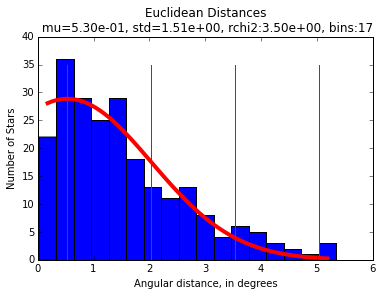

 40%|███▉      | 376/946 [1:13:19<17:15:04, 108.96s/it]

selected 234 from 326
234 matches for ic4651 for tolerance 0.005556
ic4665
ic4665 43
Data retrived, starting pbsearch
('searched for a subset of ', 43, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 44, 'with a tolerance of ', 0.005556)
using

 40%|███▉      | 377/946 [1:13:44<13:15:52, 83.92s/it] 

 10 bins
Power_divergenceResult(statistic=623379360.90195835, pvalue=0.0) 89054194.4146
Error with reduced chi squared: 89054194.4146 for ic4665
ic4725
error with parsing coords html

 40%|███▉      | 378/946 [1:13:45<9:18:32, 59.00s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ic4725+ad2k+ad2000.coo
Retrieval error. Skipping ic4725
ic4756
ic4756 190
Data retrived, starting pbsearch
('searched for a subset of ', 120, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 108, 'with a tolerance of ', 0.005556)
using 18 bins
Power_divergenceResult(statistic=18.416971138936653, pvalue=0.36300391371176888) 1.22779807593


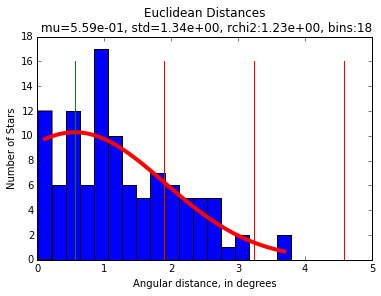

 40%|████      | 379/946 [1:14:39<9:02:23, 57.40s/it]

selected 81 from 108
81 matches for ic4756 for tolerance 0.005556
ic4996
ic4996 77
Data retrived, starting pbsearch
('searched for a subset of ', 77, 'Coords against 2mass list of', 9073309)

 40%|████      | 380/946 [1:15:35<8:58:03, 57.04s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic4996
ic5146
ic5146 292
Data retrived, starting pbsearch
('searched for a subset of ', 220, 'Coords against 2mass list of', 9073309)

 40%|████      | 381/946 [1:17:16<11:00:41, 70.16s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ic5146
ju11
error with parsing mags html

 40%|████      | 382/946 [1:17:24<8:05:03, 51.60s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ju11+ubvpg+ubv.pgo
Retrieval error. Skipping ju11
kas01
error with parsing coords html

 40%|████      | 383/946 [1:17:26<5:43:07, 36.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?kas01+ad2k+ad2000.coo
Retrieval error. Skipping kas01
ki01
error with parsing mags html

 41%|████      | 384/946 [1:17:46<4:57:59, 31.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki01+ubvpg+ubv.pgo
Retrieval error. Skipping ki01
ki05
error with parsing mags html

 41%|████      | 385/946 [1:18:06<4:24:14, 28.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki05+ubvpg+ubv.pgo
Retrieval error. Skipping ki05
ki06
error with parsing coords html

 41%|████      | 386/946 [1:18:15<3:28:29, 22.34s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki06+ad2k+ad2000.coo
Retrieval error. Skipping ki06
ki08
ki08 1
Data retrived, starting pbsearch
('searched for a subset of ', 1, 'Coords against 2mass list of', 9073309)

 41%|████      | 387/946 [1:18:17<2:31:36, 16.27s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ki08
ki10
ki10 8
Data retrived, starting pbsearch
('searched for a subset of ', 8, 'Coords against 2mass list of', 9073309)

 41%|████      | 388/946 [1:18:22<1:59:45, 12.88s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ki10
ki11
error with parsing mags html

 41%|████      | 389/946 [1:18:36<2:02:48, 13.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki11+ubvpg+ubv.pgo
Retrieval error. Skipping ki11
ki12
error with parsing mags html

 41%|████      | 390/946 [1:18:38<1:30:16,  9.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki12+ubvpg+ubv.pgo
Retrieval error. Skipping ki12
ki13
ki13 80
Data retrived, starting pbsearch
('searched for a subset of ', 48, 'Coords against 2mass list of', 9073309)

 41%|████▏     | 391/946 [1:19:26<3:17:14, 21.32s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ki13
ki14
ki14 213
Data retrived, starting pbsearch
('searched for a subset of ', 211, 'Coords against 2mass list of', 9073309)

 41%|████▏     | 392/946 [1:21:11<7:09:02, 46.47s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ki14
ki16
error with parsing mags html

 42%|████▏     | 393/946 [1:21:21<5:28:23, 35.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki16+ubvpg+ubv.pgo
Retrieval error. Skipping ki16
ki17
error with parsing mags html

 42%|████▏     | 394/946 [1:21:50<5:09:19, 33.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki17+ubvpg+ubv.pgo
Retrieval error. Skipping ki17
ki18
error with parsing mags html

 42%|████▏     | 395/946 [1:22:25<5:11:21, 33.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki18+ubvpg+ubv.pgo
Retrieval error. Skipping ki18
ki19
ki19 122
Data retrived, starting pbsearch
('searched for a subset of ', 122, 'Coords against 2mass list of', 9073309)

 42%|████▏     | 396/946 [1:23:20<6:08:24, 40.19s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ki19
ki20
error with parsing mags html

 42%|████▏     | 397/946 [1:23:29<4:43:53, 31.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki20+ubvpg+ubv.pgo
Retrieval error. Skipping ki20
ki21
error with parsing mags html

 42%|████▏     | 398/946 [1:23:31<3:23:42, 22.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki21+ubvpg+ubv.pgo
Retrieval error. Skipping ki21
ki23
error with parsing mags html

 42%|████▏     | 399/946 [1:23:36<2:34:21, 16.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki23+ubvpg+ubv.pgo
Retrieval error. Skipping ki23
ki25
error with parsing mags html

 42%|████▏     | 400/946 [1:23:44<2:10:47, 14.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki25+ubvpg+ubv.pgo
Retrieval error. Skipping ki25
ki26
error with parsing mags html

 42%|████▏     | 401/946 [1:23:57<2:07:05, 13.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ki26+ubvpg+ubv.pgo
Retrieval error. Skipping ki26
lod0001
error with parsing mags html

 42%|████▏     | 402/946 [1:23:59<1:33:32, 10.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0001+ubvpg+ubv.pgo
Retrieval error. Skipping lod0001
lod0028
error with parsing mags html

 43%|████▎     | 403/946 [1:24:01<1:10:38,  7.80s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0028+ubvpg+ubv.pgo
Retrieval error. Skipping lod0028
lod0112
error with parsing mags html

 43%|████▎     | 404/946 [1:24:03<53:50,  5.96s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0112+ubvpg+ubv.pgo
Retrieval error. Skipping lod0112
lod0153
error with parsing mags html

 43%|████▎     | 405/946 [1:24:04<42:00,  4.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0153+ubvpg+ubv.pgo
Retrieval error. Skipping lod0153
lod0189
error with parsing mags html

 43%|████▎     | 406/946 [1:24:06<35:25,  3.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0189+ubvpg+ubv.pgo
Retrieval error. Skipping lod0189
lod0306
error with parsing mags html

 43%|████▎     | 407/946 [1:24:08<30:16,  3.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0306+ubvpg+ubv.pgo
Retrieval error. Skipping lod0306
lod0309
error with parsing mags html

 43%|████▎     | 408/946 [1:24:10<25:34,  2.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0309+ubvpg+ubv.pgo
Retrieval error. Skipping lod0309
lod0372
error with parsing mags html

 43%|████▎     | 409/946 [1:24:12<22:15,  2.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0372+ubvpg+ubv.pgo
Retrieval error. Skipping lod0372
lod0402
error with parsing mags html

 43%|████▎     | 410/946 [1:24:14<20:14,  2.27s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0402+ubvpg+ubv.pgo
Retrieval error. Skipping lod0402
lod0480
error with parsing mags html

 43%|████▎     | 411/946 [1:24:15<18:46,  2.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0480+ubvpg+ubv.pgo
Retrieval error. Skipping lod0480
lod0481
error with parsing mags html

 44%|████▎     | 412/946 [1:24:17<18:51,  2.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0481+ubvpg+ubv.pgo
Retrieval error. Skipping lod0481
lod0565
error with parsing mags html

 44%|████▎     | 413/946 [1:24:19<17:49,  2.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0565+ubvpg+ubv.pgo
Retrieval error. Skipping lod0565
lod0615
error with parsing mags html

 44%|████▍     | 414/946 [1:24:21<16:48,  1.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0615+ubvpg+ubv.pgo
Retrieval error. Skipping lod0615
lod0682
error with parsing mags html

 44%|████▍     | 415/946 [1:24:22<15:59,  1.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0682+ubvpg+ubv.pgo
Retrieval error. Skipping lod0682
lod0694
error with parsing mags html

 44%|████▍     | 416/946 [1:24:24<16:33,  1.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0694+ubvpg+ubv.pgo
Retrieval error. Skipping lod0694
lod0807
error with parsing mags html

 44%|████▍     | 417/946 [1:24:26<15:59,  1.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0807+ubvpg+ubv.pgo
Retrieval error. Skipping lod0807
lod0821
error with parsing mags html

 44%|████▍     | 418/946 [1:24:28<15:48,  1.80s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0821+ubvpg+ubv.pgo
Retrieval error. Skipping lod0821
lod0915
error with parsing mags html

 44%|████▍     | 419/946 [1:24:30<15:26,  1.76s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0915+ubvpg+ubv.pgo
Retrieval error. Skipping lod0915
lod0995
error with parsing mags html

 44%|████▍     | 420/946 [1:24:31<15:19,  1.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod0995+ubvpg+ubv.pgo
Retrieval error. Skipping lod0995
lod1010
error with parsing mags html

 45%|████▍     | 421/946 [1:24:33<15:40,  1.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod1010+ubvpg+ubv.pgo
Retrieval error. Skipping lod1010
lod1171
error with parsing mags html

 45%|████▍     | 422/946 [1:24:35<15:05,  1.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod1171+ubvpg+ubv.pgo
Retrieval error. Skipping lod1171
lod1194
error with parsing mags html

 45%|████▍     | 423/946 [1:24:36<15:05,  1.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod1194+ubvpg+ubv.pgo
Retrieval error. Skipping lod1194
lod1225
error with parsing mags html

 45%|████▍     | 424/946 [1:24:38<15:05,  1.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod1225+ubvpg+ubv.pgo
Retrieval error. Skipping lod1225
lod1256
error with parsing mags html

 45%|████▍     | 425/946 [1:24:40<15:05,  1.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod1256+ubvpg+ubv.pgo
Retrieval error. Skipping lod1256
lod2313
error with parsing mags html

 45%|████▌     | 426/946 [1:24:42<15:03,  1.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lod2313+ubvpg+ubv.pgo
Retrieval error. Skipping lod2313
loi01
error with parsing mags html

 45%|████▌     | 427/946 [1:24:44<15:43,  1.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?loi01+ubvpg+ubv.pgo
Retrieval error. Skipping loi01
lusk01
error with parsing mags html

 45%|████▌     | 428/946 [1:24:46<16:23,  1.90s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?lusk01+ubvpg+ubv.pgo
Retrieval error. Skipping lusk01
ly01
error with parsing mags html

 45%|████▌     | 429/946 [1:24:47<15:57,  1.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ly01+ubvpg+ubv.pgo
Retrieval error. Skipping ly01
ly02
ly02 66
Data retrived, starting pbsearch
('searched for a subset of ', 44, 'Coords against 2mass list of', 9073309)

 45%|████▌     | 430/946 [1:25:13<1:16:45,  8.93s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ly02
ly04
error with parsing mags html

 46%|████▌     | 431/946 [1:25:14<57:24,  6.69s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ly04+ubvpg+ubv.pgo
Retrieval error. Skipping ly04
ly06
ly06

 46%|████▌     | 432/946 [1:25:16<44:10,  5.16s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ly06
ly07
error with parsing mags html

 46%|████▌     | 433/946 [1:25:18<35:01,  4.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ly07+ubvpg+ubv.pgo
Retrieval error. Skipping ly07
ly12
error with parsing mags html

 46%|████▌     | 434/946 [1:25:20<31:01,  3.64s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ly12+ubvpg+ubv.pgo
Retrieval error. Skipping ly12
ly14
error with parsing mags html

 46%|████▌     | 435/946 [1:25:22<25:51,  3.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ly14+ubvpg+ubv.pgo
Retrieval error. Skipping ly14
ma38
error with parsing mags html

 46%|████▌     | 436/946 [1:25:24<22:30,  2.65s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ma38+ubvpg+ubv.pgo
Retrieval error. Skipping ma38
ma50
ma50 98
Data retrived, starting pbsearch
('searched for a subset of ', 98, 'Coords against 2mass list of', 9073309)

 46%|████▌     | 437/946 [1:26:13<2:21:26, 16.67s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ma50
mam01
error with parsing mags html

 46%|████▋     | 438/946 [1:26:16<1:46:02, 12.52s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mam01+ubvpg+ubv.pgo
Retrieval error. Skipping mam01
may01
error with parsing mags html

 46%|████▋     | 439/946 [1:27:54<5:23:00, 38.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?may01+ubvpg+ubv.pgo
Retrieval error. Skipping may01
mel020
error with parsing coords html

 47%|████▋     | 440/946 [1:28:04<4:11:03, 29.77s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mel020+ad2k+ad2000.coo
Retrieval error. Skipping mel020
mel022
error with parsing coords html

 47%|████▋     | 441/946 [1:28:06<3:00:15, 21.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mel022+ad2k+ad2000.coo
Retrieval error. Skipping mel022
mel025
error with parsing mags html

 47%|████▋     | 442/946 [1:28:08<2:10:35, 15.55s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mel025+ubvpg+ubv.pgo
Retrieval error. Skipping mel025
mel066
mel066 5
Data retrived, starting pbsearch
('searched for a subset of ', 5, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 2, 'with a tolerance of ', 0.005556)
mel066 had no repeats
mel066

 47%|████▋     | 443/946 [1:28:12<1:40:55, 12.04s/it]

 had error with histogram
mel071
mel071 40
Data retrived, starting pbsearch
('searched for a subset of ', 40, 'Coords against 2mass list of', 9073309)

 47%|████▋     | 444/946 [1:28:30<1:57:08, 14.00s/it]


('Coord matches: ', 6, 'with a tolerance of ', 0.005556)
mel071 had no repeats
mel071 had error with histogram
mel101
error with parsing mags html

 47%|████▋     | 445/946 [1:28:32<1:25:57, 10.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mel101+ubvpg+ubv.pgo
Retrieval error. Skipping mel101
mel105
mel105 17
Data retrived, starting pbsearch
('searched for a subset of ', 17, 'Coords against 2mass list of', 9073309)

 47%|████▋     | 446/946 [1:28:41<1:22:00,  9.84s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping mel105
mel111
mel111 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 47%|████▋     | 447/946 [1:28:45<1:08:18,  8.21s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping mel111
mel227
error with parsing mags html

 47%|████▋     | 448/946 [1:28:47<51:28,  6.20s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mel227+ubvpg+ubv.pgo
Retrieval error. Skipping mel227
mof01
error with parsing mags html

 47%|████▋     | 449/946 [1:28:48<39:48,  4.81s/it]WARNING: IllegalHourWarning: 'hour' was found  to be '24.0', which is not in range (-24, 24). Treating as 24 hr [astropy.coordinates.angle_utilities]



http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?mof01+ubvpg+ubv.pgo
Retrieval error. Skipping mof01
ngc0103
error with parsing coords html

 48%|████▊     | 450/946 [1:28:49<29:41,  3.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0103+ad2k+ad2000.coo
Retrieval error. Skipping ngc0103
ngc0129
error with parsing coords html

 48%|████▊     | 451/946 [1:28:50<22:34,  2.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0129+ad2k+ad2000.coo
Retrieval error. Skipping ngc0129
ngc0133
error with parsing coords html

 48%|████▊     | 452/946 [1:28:50<17:34,  2.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0133+ad2k+ad2000.coo
Retrieval error. Skipping ngc0133
ngc0136
error with parsing mags html

 48%|████▊     | 453/946 [1:28:57<29:31,  3.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0136+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0136
ngc0146
ngc0146 171
Data retrived, starting pbsearch
('searched for a subset of ', 171, 'Coords against 2mass list of', 9073309)

 48%|████▊     | 454/946 [1:30:18<3:38:30, 26.65s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0146
ngc0188
error with parsing mags html

 48%|████▊     | 455/946 [1:31:10<4:41:25, 34.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0188+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0188
ngc0189
error with parsing coords html

 48%|████▊     | 456/946 [1:31:11<3:18:39, 24.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0189+ad2k+ad2000.coo
Retrieval error. Skipping ngc0189
ngc0225
error with parsing coords html

 48%|████▊     | 457/946 [1:31:12<2:20:47, 17.27s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0225+ad2k+ad2000.coo
Retrieval error. Skipping ngc0225
ngc0381
ngc0381 170
Data retrived, starting pbsearch
('searched for a subset of ', 168, 'Coords against 2mass list of', 9073309)

 48%|████▊     | 458/946 [1:32:25<4:36:01, 33.94s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0381
ngc0433
error with parsing mags html

 49%|████▊     | 459/946 [1:32:26<3:16:42, 24.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0433+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0433
ngc0436
error with parsing mags html

 49%|████▊     | 460/946 [1:32:28<2:21:36, 17.48s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0436+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0436
ngc0457
error with parsing mags html

 49%|████▊     | 461/946 [1:32:54<2:41:41, 20.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0457+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0457
ngc0559
ngc0559 81
Data retrived, starting pbsearch
('searched for a subset of ', 81, 'Coords against 2mass list of', 9073309)

 49%|████▉     | 462/946 [1:34:14<5:06:27, 37.99s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0559
ngc0581
error with parsing mags html

 49%|████▉     | 463/946 [1:34:18<3:42:58, 27.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0581+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0581
ngc0637
ngc0637 80
Data retrived, starting pbsearch
('searched for a subset of ', 62, 'Coords against 2mass list of', 9073309)

 49%|████▉     | 464/946 [1:34:46<3:44:17, 27.92s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0637
ngc0654
ngc0654 3
Data retrived, starting pbsearch
('searched for a subset of ', 3, 'Coords against 2mass list of', 9073309)

 49%|████▉     | 465/946 [1:34:49<2:43:43, 20.42s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0654
ngc0659
ngc0659 29
Data retrived, starting pbsearch
('searched for a subset of ', 29, 'Coords against 2mass list of', 9073309)

 49%|████▉     | 466/946 [1:35:03<2:27:39, 18.46s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0659
ngc0663
error with parsing mags html

 49%|████▉     | 467/946 [1:35:15<2:13:18, 16.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0663+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0663
ngc0744
ngc0744 7
Data retrived, starting pbsearch
('searched for a subset of ', 7, 'Coords against 2mass list of', 9073309)

 49%|████▉     | 468/946 [1:35:20<1:44:02, 13.06s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0744
ngc0752
ngc0752 903
Data retrived, starting pbsearch
('searched for a subset of ', 838, 'Coords against 2mass list of', 9073309)

 50%|████▉     | 469/946 [1:41:31<15:58:27, 120.56s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0752
ngc0869
error with parsing coords html

 50%|████▉     | 470/946 [1:41:37<11:22:06, 85.98s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0869+ad2k+ad2000.coo
Retrieval error. Skipping ngc0869
ngc0884
error with parsing coords html

 50%|████▉     | 471/946 [1:41:42<8:08:06, 61.66s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0884+ad2k+ad2000.coo
Retrieval error. Skipping ngc0884
ngc0886
error with parsing mags html

 50%|████▉     | 472/946 [1:41:43<5:44:53, 43.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0886+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0886
ngc0956
error with parsing mags html

 50%|█████     | 473/946 [1:42:38<6:09:38, 46.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc0956+ubvpg+ubv.pgo
Retrieval error. Skipping ngc0956
ngc0957
ngc0957 292
Data retrived, starting pbsearch
('searched for a subset of ', 155, 'Coords against 2mass list of', 9073309)

 50%|█████     | 474/946 [1:45:18<10:36:36, 80.92s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc0957
ngc1027
Couldn't find magnitude link for

 50%|█████     | 475/946 [1:50:48<20:21:34, 155.61s/it]

 ngc1027
http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1027+ubvpg+ubv.pgo
error with parsing mags html
http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1027+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1027
ngc1039
error with parsing mags html

 50%|█████     | 476/946 [1:50:52<14:23:56, 110.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1039+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1039
ngc1193
error with parsing mags html

 50%|█████     | 477/946 [1:50:56<10:12:45, 78.39s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1193+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1193
ngc1245
ngc1245 32
Data retrived, starting pbsearch
('searched for a subset of ', 32, 'Coords against 2mass list of', 9073309)

 51%|█████     | 478/946 [1:51:12<7:43:28, 59.42s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1245
ngc1252
error with parsing coords html

 51%|█████     | 479/946 [1:51:14<5:29:10, 42.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1252+ad2k+ad2000.coo
Retrieval error. Skipping ngc1252
ngc1342
ngc1342 55
Data retrived, starting pbsearch
('searched for a subset of ', 49, 'Coords against 2mass list of', 9073309)

 51%|█████     | 480/946 [1:51:36<4:41:37, 36.26s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1342
ngc1444
ngc1444 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 51%|█████     | 481/946 [1:51:41<3:28:49, 26.94s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1444
ngc1496
error with parsing mags html

 51%|█████     | 482/946 [1:51:43<2:30:21, 19.44s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1496+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1496
ngc1502
ngc1502 136
Data retrived, starting pbsearch
('searched for a subset of ', 136, 'Coords against 2mass list of', 9073309)

 51%|█████     | 483/946 [1:52:42<4:01:40, 31.32s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1502
ngc1513
error with parsing mags html

 51%|█████     | 484/946 [1:53:06<3:42:49, 28.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1513+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1513
ngc1528
error with parsing mags html

 51%|█████▏    | 485/946 [1:53:12<2:49:21, 22.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1528+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1528
ngc1545
ngc1545 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 51%|█████▏    | 486/946 [1:53:16<2:08:17, 16.73s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1545
ngc1582
error with parsing mags html

 51%|█████▏    | 487/946 [1:53:25<1:51:33, 14.58s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1582+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1582
ngc1624
error with parsing mags html

 52%|█████▏    | 488/946 [1:53:27<1:21:26, 10.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1624+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1624
ngc1641
error with parsing mags html

 52%|█████▏    | 489/946 [1:53:29<1:02:20,  8.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1641+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1641
ngc1647
ngc1647 303
Data retrived, starting pbsearch
('searched for a subset of ', 303, 'Coords against 2mass list of', 9073309)

 52%|█████▏    | 490/946 [1:55:40<5:41:06, 44.88s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1647
ngc1662
ngc1662 40
Data retrived, starting pbsearch
('searched for a subset of ', 25, 'Coords against 2mass list of', 9073309)

 52%|█████▏    | 491/946 [1:55:52<4:26:02, 35.08s/it]


('Coord matches: ', 24, 'with a tolerance of ', 0.005556)
ngc1662 had no repeats
ngc1662 had error with histogram
ngc1663
error with parsing coords html

 52%|█████▏    | 492/946 [1:55:54<3:10:28, 25.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1663+ad2k+ad2000.coo
Retrieval error. Skipping ngc1663
ngc1664
ngc1664 81
Data retrived, starting pbsearch
('searched for a subset of ', 81, 'Coords against 2mass list of', 9073309)

 52%|█████▏    | 493/946 [1:56:36<3:46:45, 30.03s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1664
ngc1708
error with parsing mags html

 52%|█████▏    | 494/946 [1:56:37<2:41:52, 21.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1708+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1708
ngc1746
error with parsing mags html

 52%|█████▏    | 495/946 [1:56:39<1:58:15, 15.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1746+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1746
ngc1750
ngc1750 429
Data retrived, starting pbsearch
('searched for a subset of ', 408, 'Coords against 2mass list of', 9073309)

 52%|█████▏    | 496/946 [1:59:35<7:58:03, 63.74s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1750
ngc1778
ngc1778 29
Data retrived, starting pbsearch
('searched for a subset of ', 29, 'Coords against 2mass list of', 9073309)

 53%|█████▎    | 497/946 [1:59:49<6:05:02, 48.78s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1778
ngc1798
error with parsing mags html

 53%|█████▎    | 498/946 [2:00:01<4:40:46, 37.60s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1798+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1798
ngc1802
error with parsing mags html

 53%|█████▎    | 499/946 [2:00:02<3:19:43, 26.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1802+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1802
ngc1807
ngc1807 19
Data retrived, starting pbsearch
('searched for a subset of ', 19, 'Coords against 2mass list of', 9073309)

 53%|█████▎    | 500/946 [2:00:14<2:46:13, 22.36s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1807
ngc1817
ngc1817 107
Data retrived, starting pbsearch
('searched for a subset of ', 107, 'Coords against 2mass list of', 9073309)

 53%|█████▎    | 501/946 [2:01:15<4:10:24, 33.76s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1817
ngc1857
ngc1857 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 53%|█████▎    | 502/946 [2:01:20<3:06:24, 25.19s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1857
ngc1883
error with parsing mags html

 53%|█████▎    | 503/946 [2:01:24<2:19:11, 18.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1883+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1883
ngc1893
error with parsing mags html

 53%|█████▎    | 504/946 [2:01:52<2:39:04, 21.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1893+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1893
ngc1896
error with parsing mags html

 53%|█████▎    | 505/946 [2:01:53<1:54:42, 15.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1896+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1896
ngc1901
error with parsing mags html

 53%|█████▎    | 506/946 [2:01:55<1:24:29, 11.52s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1901+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1901
ngc1907
ngc1907 10
Data retrived, starting pbsearch
('searched for a subset of ', 10, 'Coords against 2mass list of', 9073309)

 54%|█████▎    | 507/946 [2:02:01<1:11:49,  9.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1907
ngc1912
ngc1912 37
Data retrived, starting pbsearch
('searched for a subset of ', 34, 'Coords against 2mass list of', 9073309)

 54%|█████▎    | 508/946 [2:02:18<1:26:08, 11.80s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1912
ngc1931
error with parsing mags html

 54%|█████▍    | 509/946 [2:02:19<1:03:29,  8.72s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1931+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1931
ngc1960
ngc1960 520
Data retrived, starting pbsearch
('searched for a subset of ', 289, 'Coords against 2mass list of', 9073309)

 54%|█████▍    | 510/946 [2:04:31<5:30:49, 45.53s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc1960
ngc1976
error with parsing mags html

 54%|█████▍    | 511/946 [2:05:04<5:03:40, 41.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1976+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1976
ngc1977
error with parsing mags html

 54%|█████▍    | 512/946 [2:05:06<3:35:23, 29.78s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1977+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1977
ngc1980
error with parsing mags html

 54%|█████▍    | 513/946 [2:05:07<2:33:49, 21.31s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1980+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1980
ngc1981
error with parsing mags html

 54%|█████▍    | 514/946 [2:05:09<1:50:51, 15.40s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1981+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1981
ngc1996
error with parsing mags html

 54%|█████▍    | 515/946 [2:05:10<1:20:50, 11.25s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc1996+ubvpg+ubv.pgo
Retrieval error. Skipping ngc1996
ngc2099
error with parsing mags html

 55%|█████▍    | 516/946 [2:07:16<5:26:55, 45.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2099+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2099
ngc2112
ngc2112 111
Data retrived, starting pbsearch
('searched for a subset of ', 77, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 60, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=38.392268379643639, pvalue=1.4821333945386302e-05) 5.48460976852


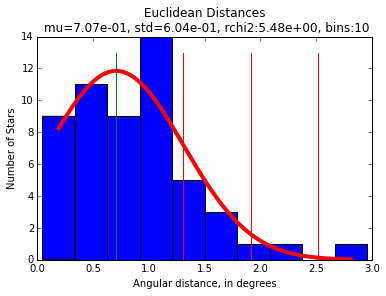

 55%|█████▍    | 517/946 [2:07:58<5:17:56, 44.47s/it]

selected 41 from 60
41 matches for ngc2112 for tolerance 0.005556
ngc2126
error with parsing mags html

 55%|█████▍    | 518/946 [2:08:20<4:29:08, 37.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2126+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2126
ngc2129
ngc2129 81
Data retrived, starting pbsearch
('searched for a subset of ', 81, 'Coords against 2mass list of', 9073309)

 55%|█████▍    | 519/946 [2:08:59<4:32:16, 38.26s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2129
ngc2143
error with parsing mags html

 55%|█████▍    | 520/946 [2:09:01<3:13:41, 27.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2143+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2143
ngc2158
error with parsing mags html

 55%|█████▌    | 521/946 [2:09:18<2:52:03, 24.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2158+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2158
ngc2168
ngc2168 2187
Data retrived, starting pbsearch
('searched for a subset of ', 2187, 'Coords against 2mass list of', 9073309)

 55%|█████▌    | 522/946 [2:25:25<36:10:30, 307.15s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2168
ngc2169
ngc2169

 55%|█████▌    | 523/946 [2:25:29<25:22:14, 215.92s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2169
ngc2175
ngc2175 8
Data retrived, starting pbsearch
('searched for a subset of ', 8, 'Coords against 2mass list of', 9073309)

 55%|█████▌    | 524/946 [2:25:33<17:53:20, 152.61s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2175
ngc2184
error with parsing mags html

 55%|█████▌    | 525/946 [2:25:35<12:33:01, 107.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2184+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2184
ngc2186
error with parsing mags html

 56%|█████▌    | 526/946 [2:25:49<9:14:37, 79.23s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2186+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2186
ngc2192
error with parsing mags html

 56%|█████▌    | 527/946 [2:25:55<6:39:44, 57.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2192+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2192
ngc2194
ngc2194 107
Data retrived, starting pbsearch
('searched for a subset of ', 105, 'Coords against 2mass list of', 9073309)

 56%|█████▌    | 528/946 [2:26:42<6:17:20, 54.16s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2194
ngc2202
error with parsing mags html

 56%|█████▌    | 529/946 [2:26:43<4:27:00, 38.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2202+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2202
ngc2204
ngc2204 42
Data retrived, starting pbsearch
('searched for a subset of ', 42, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 41, 'with a tolerance of ', 0.005556)
using

 56%|█████▌    | 530/946 [2:27:03<3:47:42, 32.84s/it]

 10 bins
ngc2204 had error with optimize.curve_fit
ngc2215
ngc2215 12
Data retrived, starting pbsearch
('searched for a subset of ', 12, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 12, 'with a tolerance of ', 0.005556)
ngc2215 had no repeats
using

 56%|█████▌    | 531/946 [2:27:10<2:53:43, 25.12s/it]

 10 bins
ngc2215 had error with optimize.curve_fit
ngc2232
error with parsing mags html

 56%|█████▌    | 532/946 [2:27:12<2:04:53, 18.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2232+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2232
ngc2236
ngc2236 32
Data retrived, starting pbsearch
('searched for a subset of ', 32, 'Coords against 2mass list of', 9073309)

 56%|█████▋    | 533/946 [2:27:27<1:59:08, 17.31s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2236
ngc2240
error with parsing mags html

 56%|█████▋    | 534/946 [2:27:29<1:27:00, 12.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2240+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2240
ngc2243
error with parsing mags html

 57%|█████▋    | 535/946 [2:27:55<1:54:01, 16.65s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2243+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2243
ngc2244
ngc2244 689
Data retrived, starting pbsearch
('searched for a subset of ', 335, 'Coords against 2mass list of', 9073309)

 57%|█████▋    | 536/946 [2:30:27<6:31:36, 57.31s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2244
ngc2251
ngc2251 20
Data retrived, starting pbsearch
('searched for a subset of ', 20, 'Coords against 2mass list of', 9073309)

 57%|█████▋    | 537/946 [2:30:37<4:53:48, 43.10s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2251
ngc2252
error with parsing mags html

 57%|█████▋    | 538/946 [2:30:39<3:28:49, 30.71s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2252+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2252
ngc2254
error with parsing mags html

 57%|█████▋    | 539/946 [2:30:41<2:29:21, 22.02s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2254+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2254
ngc2264
error with parsing mags html

 57%|█████▋    | 540/946 [2:31:29<3:21:13, 29.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2264+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2264
ngc2266
error with parsing mags html

 57%|█████▋    | 541/946 [2:31:37<2:38:16, 23.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2266+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2266
ngc2269
error with parsing mags html

 57%|█████▋    | 542/946 [2:31:39<1:54:02, 16.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2269+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2269
ngc2270
error with parsing mags html

 57%|█████▋    | 543/946 [2:31:41<1:23:44, 12.47s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2270+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2270
ngc2281
error with parsing mags html

 58%|█████▊    | 544/946 [2:31:44<1:04:18,  9.60s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2281+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2281
ngc2282
error with parsing coords html

 58%|█████▊    | 545/946 [2:31:45<46:31,  6.96s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2282+ad2k+ad2000.coo
Retrieval error. Skipping ngc2282
ngc2286
ngc2286 61
Data retrived, starting pbsearch
('searched for a subset of ', 61, 'Coords against 2mass list of', 9073309)

 58%|█████▊    | 546/946 [2:32:12<1:27:10, 13.08s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2286
ngc2287
ngc2287 18
Data retrived, starting pbsearch
('searched for a subset of ', 18, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 16, 'with a tolerance of ', 0.005556)
ngc2287 had no repeats
using 10 bins
Power_divergenceResult(statistic=42958073618879.984, pvalue=0.0)

 58%|█████▊    | 547/946 [2:32:22<1:20:48, 12.15s/it]

 6.13686765984e+12
Error with reduced chi squared: 6.13686765984e+12 for ngc2287
ngc2301
ngc2301 77
Data retrived, starting pbsearch
('searched for a subset of ', 77, 'Coords against 2mass list of', 9073309)

 58%|█████▊    | 548/946 [2:32:57<2:04:51, 18.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2301
ngc2302
error with parsing mags html

 58%|█████▊    | 549/946 [2:32:58<1:30:30, 13.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2302+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2302
ngc2304
error with parsing mags html

 58%|█████▊    | 550/946 [2:33:13<1:32:35, 14.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2304+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2304
ngc2306
error with parsing mags html

 58%|█████▊    | 551/946 [2:33:15<1:08:05, 10.34s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2306+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2306
ngc2311
error with parsing mags html

 58%|█████▊    | 552/946 [2:33:17<50:53,  7.75s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2311+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2311
ngc2319
error with parsing mags html

 58%|█████▊    | 553/946 [2:33:18<39:01,  5.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2319+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2319
ngc2323
ngc2323 189
Data retrived, starting pbsearch
('searched for a subset of ', 189, 'Coords against 2mass list of', 9073309)

 59%|█████▊    | 554/946 [2:34:40<3:07:03, 28.63s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2323
ngc2324
ngc2324 23
Data retrived, starting pbsearch
('searched for a subset of ', 23, 'Coords against 2mass list of', 9073309)

 59%|█████▊    | 555/946 [2:34:51<2:32:27, 23.40s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2324
ngc2335
error with parsing mags html

 59%|█████▉    | 556/946 [2:34:53<1:50:03, 16.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2335+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2335
ngc2343
error with parsing mags html

 59%|█████▉    | 557/946 [2:34:56<1:22:26, 12.72s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2343+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2343
ngc2345
error with parsing mags html

 59%|█████▉    | 558/946 [2:34:58<1:01:11,  9.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2345+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2345
ngc2353
ngc2353 122
Data retrived, starting pbsearch
('searched for a subset of ', 100, 'Coords against 2mass list of', 9073309)

 59%|█████▉    | 559/946 [2:36:18<3:17:56, 30.69s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2353
ngc2354
ngc2354 58
Data retrived, starting pbsearch
('searched for a subset of ', 42, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 50, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=6.7754017463757918, pvalue=0.66049026147189638) 0.967914535197


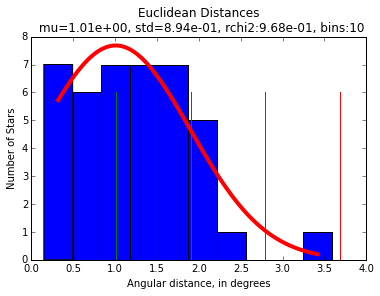

 59%|█████▉    | 560/946 [2:36:38<2:56:14, 27.39s/it]

selected 40 from 50
40 matches for ngc2354 for tolerance 0.005556
ngc2355
error with parsing mags html

 59%|█████▉    | 561/946 [2:36:40<2:07:15, 19.83s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2355+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2355
ngc2358
error with parsing mags html

 59%|█████▉    | 562/946 [2:36:42<1:32:49, 14.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2358+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2358
ngc2360
error with parsing mags html

 60%|█████▉    | 563/946 [2:36:45<1:11:02, 11.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2360+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2360
ngc2362
error with parsing mags html

 60%|█████▉    | 564/946 [2:36:52<1:02:31,  9.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2362+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2362
ngc2367
error with parsing mags html

 60%|█████▉    | 565/946 [2:37:04<1:07:17, 10.60s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2367+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2367
ngc2374
ngc2374 33
Data retrived, starting pbsearch
('searched for a subset of ', 26, 'Coords against 2mass list of', 9073309)

 60%|█████▉    | 566/946 [2:37:17<1:10:38, 11.15s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2374
ngc2383
error with parsing mags html

 60%|█████▉    | 567/946 [2:37:23<1:00:24,  9.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2383+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2383
ngc2384
ngc2384 25
Data retrived, starting pbsearch
('searched for a subset of ', 15, 'Coords against 2mass list of', 9073309)

 60%|██████    | 568/946 [2:37:32<59:39,  9.47s/it]  


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2384
ngc2394
error with parsing mags html

 60%|██████    | 569/946 [2:37:34<46:03,  7.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2394+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2394
ngc2395
ngc2395 61
Data retrived, starting pbsearch
('searched for a subset of ', 53, 'Coords against 2mass list of', 9073309)

 60%|██████    | 570/946 [2:37:59<1:19:03, 12.61s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2395
ngc2396
error with parsing mags html

 60%|██████    | 571/946 [2:38:01<59:06,  9.46s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2396+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2396
ngc2401
error with parsing mags html

 60%|██████    | 572/946 [2:38:24<1:23:29, 13.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2401+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2401
ngc2414
ngc2414 58
Data retrived, starting pbsearch
('searched for a subset of ', 29, 'Coords against 2mass list of', 9073309)

 61%|██████    | 573/946 [2:38:38<1:25:20, 13.73s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2414
ngc2420
error with parsing mags html

 61%|██████    | 574/946 [2:38:41<1:05:05, 10.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2420+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2420
ngc2421
error with parsing mags html

 61%|██████    | 575/946 [2:38:43<48:47,  7.89s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2421+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2421
ngc2422
ngc2422 54
Data retrived, starting pbsearch
('searched for a subset of ', 54, 'Coords against 2mass list of', 9073309)

 61%|██████    | 576/946 [2:39:16<1:34:17, 15.29s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2422
ngc2423
error with parsing mags html

 61%|██████    | 577/946 [2:39:18<1:09:15, 11.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2423+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2423
ngc2425
error with parsing mags html

 61%|██████    | 578/946 [2:39:58<2:01:57, 19.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2425+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2425
ngc2428
error with parsing mags html

 61%|██████    | 579/946 [2:39:59<1:28:06, 14.40s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2428+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2428
ngc2430
error with parsing mags html

 61%|██████▏   | 580/946 [2:40:01<1:04:22, 10.55s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2430+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2430
ngc2432
error with parsing mags html

 61%|██████▏   | 581/946 [2:40:02<47:56,  7.88s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2432+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2432
ngc2437
ngc2437 111
Data retrived, starting pbsearch
('searched for a subset of ', 97, 'Coords against 2mass list of', 9073309)

 62%|██████▏   | 582/946 [2:40:52<2:03:55, 20.43s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2437
ngc2439
ngc2439 291
Data retrived, starting pbsearch
('searched for a subset of ', 189, 'Coords against 2mass list of', 9073309)

 62%|██████▏   | 583/946 [2:42:15<3:56:30, 39.09s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2439
ngc2447
ngc2447 68
Data retrived, starting pbsearch
('searched for a subset of ', 60, 'Coords against 2mass list of', 9073309)

 62%|██████▏   | 584/946 [2:42:42<3:33:50, 35.44s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2447
ngc2448
error with parsing mags html

 62%|██████▏   | 585/946 [2:42:44<2:33:05, 25.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2448+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2448
ngc2451
error with parsing coords html

 62%|██████▏   | 586/946 [2:42:45<1:48:21, 18.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2451+ad2k+ad2000.coo
Retrieval error. Skipping ngc2451
ngc2451A
error with parsing coords html

 62%|██████▏   | 587/946 [2:42:45<1:17:03, 12.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2451A+ad2k+ad2000.coo
Retrieval error. Skipping ngc2451A
ngc2451B
error with parsing mags html

 62%|██████▏   | 588/946 [2:42:47<56:55,  9.54s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2451B+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2451B
ngc2453
ngc2453 52
Data retrived, starting pbsearch
('searched for a subset of ', 52, 'Coords against 2mass list of', 9073309)

 62%|██████▏   | 589/946 [2:43:11<1:21:53, 13.76s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2453
ngc2467
ngc2467

 62%|██████▏   | 590/946 [2:43:13<1:01:49, 10.42s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2467
ngc2477
error with parsing mags html

 62%|██████▏   | 591/946 [2:45:01<3:54:40, 39.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2477+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2477
ngc2479
error with parsing mags html

 63%|██████▎   | 592/946 [2:45:04<2:48:22, 28.54s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2479+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2479
ngc2482
error with parsing mags html

 63%|██████▎   | 593/946 [2:45:06<2:00:37, 20.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2482+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2482
ngc2483
ngc2483 140
Data retrived, starting pbsearch
('searched for a subset of ', 104, 'Coords against 2mass list of', 9073309)

 63%|██████▎   | 594/946 [2:45:53<2:48:19, 28.69s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2483
ngc2489
ngc2489 211
Data retrived, starting pbsearch
('searched for a subset of ', 107, 'Coords against 2mass list of', 9073309)

 63%|██████▎   | 595/946 [2:46:44<3:26:51, 35.36s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2489
ngc2506
ngc2506 320
Data retrived, starting pbsearch
('searched for a subset of ', 320, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 10, 'with a tolerance of ', 0.005556)
ngc2506 had no repeats
using

 63%|██████▎   | 596/946 [2:49:05<6:31:18, 67.08s/it]

 10 bins
Power_divergenceResult(statistic=78.30402997319888, pvalue=3.5077935059104127e-13) 11.1862899962
Error with reduced chi squared: 11.1862899962 for ngc2506
ngc2509
error with parsing mags html

 63%|██████▎   | 597/946 [2:49:08<4:37:03, 47.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2509+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2509
ngc2516
ngc2516 505
Data retrived, starting pbsearch
('searched for a subset of ', 483, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 434, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=483.00942711710684, pvalue=2.4931268833090892e-98)

 63%|██████▎   | 598/946 [2:52:50<9:41:06, 100.19s/it]

 69.001346731
Error with reduced chi squared: 69.001346731 for ngc2516
ngc2527
ngc2527 82
Data retrived, starting pbsearch
('searched for a subset of ', 61, 'Coords against 2mass list of', 9073309)

 63%|██████▎   | 599/946 [2:53:18<7:33:44, 78.46s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2527
ngc2533
ngc2533 20
Data retrived, starting pbsearch
('searched for a subset of ', 20, 'Coords against 2mass list of', 9073309)

 63%|██████▎   | 600/946 [2:53:28<5:34:03, 57.93s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2533
ngc2539
error with parsing mags html

 64%|██████▎   | 601/946 [2:53:32<4:00:14, 41.78s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2539+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2539
ngc2546
ngc2546 113
Data retrived, starting pbsearch
('searched for a subset of ', 113, 'Coords against 2mass list of', 9073309)

 64%|██████▎   | 602/946 [2:54:22<4:13:40, 44.25s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2546
ngc2547
error with parsing coords html

 64%|██████▎   | 603/946 [2:54:26<3:02:40, 31.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2547+ad2k+ad2000.coo
Retrieval error. Skipping ngc2547
ngc2548
error with parsing coords html

 64%|██████▍   | 604/946 [2:54:46<2:42:12, 28.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2548+ad2k+ad2000.coo
Retrieval error. Skipping ngc2548
ngc2567
error with parsing mags html

 64%|██████▍   | 605/946 [2:54:49<1:58:29, 20.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2567+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2567
ngc2571
ngc2571 262
Data retrived, starting pbsearch
('searched for a subset of ', 225, 'Coords against 2mass list of', 9073309)

 64%|██████▍   | 606/946 [2:56:27<4:09:09, 43.97s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2571
ngc2580
error with parsing coords html

 64%|██████▍   | 607/946 [2:56:29<2:57:32, 31.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2580+ad2k+ad2000.coo
Retrieval error. Skipping ngc2580
ngc2588
error with parsing mags html

 64%|██████▍   | 608/946 [2:56:58<2:53:07, 30.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2588+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2588
ngc2627
error with parsing mags html

 64%|██████▍   | 609/946 [2:57:00<2:03:34, 22.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2627+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2627
ngc2632
error with parsing coords html

 64%|██████▍   | 610/946 [2:57:02<1:30:11, 16.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2632+ad2k+ad2000.coo
Retrieval error. Skipping ngc2632
ngc2635
error with parsing mags html

 65%|██████▍   | 611/946 [2:57:25<1:40:28, 17.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2635+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2635
ngc2645
ngc2645 9
Data retrived, starting pbsearch
('searched for a subset of ', 9, 'Coords against 2mass list of', 9073309)

 65%|██████▍   | 612/946 [2:57:30<1:19:26, 14.27s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2645
ngc2658
error with parsing mags html

 65%|██████▍   | 613/946 [2:57:32<58:21, 10.51s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2658+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2658
ngc2659
error with parsing mags html

 65%|██████▍   | 614/946 [2:57:35<46:15,  8.36s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2659+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2659
ngc2660
ngc2660 327
Data retrived, starting pbsearch
('searched for a subset of ', 327, 'Coords against 2mass list of', 9073309)

 65%|██████▌   | 615/946 [2:59:59<4:29:30, 48.85s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2660
ngc2664
error with parsing mags html

 65%|██████▌   | 616/946 [3:00:01<3:12:01, 34.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2664+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2664
ngc2669
error with parsing mags html

 65%|██████▌   | 617/946 [3:00:03<2:17:42, 25.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2669+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2669
ngc2670
ngc2670 1
Data retrived, starting pbsearch
('searched for a subset of ', 1, 'Coords against 2mass list of', 9073309)

 65%|██████▌   | 618/946 [3:00:05<1:39:32, 18.21s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2670
ngc2671
error with parsing mags html

 65%|██████▌   | 619/946 [3:00:07<1:12:54, 13.38s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2671+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2671
ngc2682
ngc2682 3188
Data retrived, starting pbsearch
('searched for a subset of ', 3188, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 2476, 'with a tolerance of ', 0.005556)
ngc2682

 66%|██████▌   | 620/946 [3:23:15<38:33:11, 425.74s/it]

 had no repeats
ngc2682 had error with histogram
ngc2818
error with parsing coords html

 66%|██████▌   | 621/946 [3:23:18<26:58:04, 298.72s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2818+ad2k+ad2000.coo
Retrieval error. Skipping ngc2818
ngc2866
error with parsing mags html

 66%|██████▌   | 622/946 [3:23:19<18:51:52, 209.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2866+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2866
ngc2910
ngc2910 3
Data retrived, starting pbsearch
('searched for a subset of ', 3, 'Coords against 2mass list of', 9073309)

 66%|██████▌   | 623/946 [3:23:22<13:14:31, 147.59s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc2910
ngc2925
error with parsing mags html

 66%|██████▌   | 624/946 [3:23:24<9:17:42, 103.92s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2925+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2925
ngc2972
error with parsing mags html

 66%|██████▌   | 625/946 [3:23:26<6:32:08, 73.30s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc2972+ubvpg+ubv.pgo
Retrieval error. Skipping ngc2972
ngc3033
error with parsing mags html

 66%|██████▌   | 626/946 [3:23:28<4:36:13, 51.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3033+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3033
ngc3036
error with parsing mags html

 66%|██████▋   | 627/946 [3:23:29<3:15:14, 36.72s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3036+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3036
ngc3105
ngc3105 2
Data retrived, starting pbsearch
('searched for a subset of ', 2, 'Coords against 2mass list of', 9073309)

 66%|██████▋   | 628/946 [3:23:32<2:19:56, 26.40s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3105
ngc3114
error with parsing mags html

 66%|██████▋   | 629/946 [3:23:34<1:41:38, 19.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3114+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3114
ngc3228
ngc3228 14
Data retrived, starting pbsearch
('searched for a subset of ', 14, 'Coords against 2mass list of', 9073309)

 67%|██████▋   | 630/946 [3:23:42<1:23:06, 15.78s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3228
ngc3247
error with parsing mags html

 67%|██████▋   | 631/946 [3:23:44<1:00:57, 11.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3247+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3247
ngc3293
error with parsing coords html

 67%|██████▋   | 632/946 [3:23:54<58:26, 11.17s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3293+ad2k+ad2000.coo
Retrieval error. Skipping ngc3293
ngc3330
error with parsing mags html

 67%|██████▋   | 633/946 [3:23:56<43:22,  8.31s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3330+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3330
ngc3496
ngc3496 10
Data retrived, starting pbsearch
('searched for a subset of ', 9, 'Coords against 2mass list of', 9073309)

 67%|██████▋   | 634/946 [3:24:01<38:34,  7.42s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3496
ngc3532
error with parsing mags html

 67%|██████▋   | 635/946 [3:24:10<41:15,  7.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3532+ubvpg+ubv.pgo
Retrieval error. Skipping ngc3532
ngc3572
ngc3572 16
Data retrived, starting pbsearch
('searched for a subset of ', 16, 'Coords against 2mass list of', 9073309)

 67%|██████▋   | 636/946 [3:24:18<41:33,  8.04s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3572
ngc3590
error with parsing coords html

 67%|██████▋   | 637/946 [3:24:32<49:57,  9.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc3590+ad2k+ad2000.coo
Retrieval error. Skipping ngc3590
ngc3603
ngc3603 62
Data retrived, starting pbsearch
('searched for a subset of ', 52, 'Coords against 2mass list of', 9073309)

 67%|██████▋   | 638/946 [3:24:56<1:11:22, 13.90s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3603
ngc3680
ngc3680 112
Data retrived, starting pbsearch
('searched for a subset of ', 112, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 58, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=12.633725669587685, pvalue=0.17989208983253291) 1.8048179528


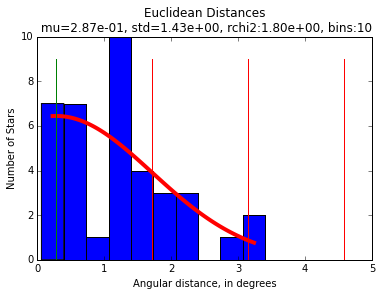

 68%|██████▊   | 639/946 [3:25:45<2:05:55, 24.61s/it]

selected 39 from 58
39 matches for ngc3680 for tolerance 0.005556
ngc3766
ngc3766 210
Data retrived, starting pbsearch
('searched for a subset of ', 210, 'Coords against 2mass list of', 9073309)

 68%|██████▊   | 640/946 [3:27:15<3:45:39, 44.25s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc3766
ngc3960
ngc3960 496
Data retrived, starting pbsearch
('searched for a subset of ', 204, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 55, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=17.265943458905767, pvalue=0.044710597018713119) 2.46656335127


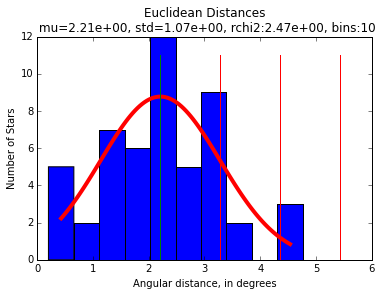

 68%|██████▊   | 641/946 [3:29:37<6:14:09, 73.61s/it]

selected 38 from 55
38 matches for ngc3960 for tolerance 0.005556
ngc4052
error with parsing mags html

 68%|██████▊   | 642/946 [3:29:40<4:24:25, 52.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4052+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4052
ngc4103
ngc4103 657
Data retrived, starting pbsearch
('searched for a subset of ', 464, 'Coords against 2mass list of', 9073309)

 68%|██████▊   | 643/946 [3:33:12<8:25:38, 100.13s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc4103
ngc4337
error with parsing mags html

 68%|██████▊   | 644/946 [3:33:13<5:55:11, 70.57s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4337+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4337
ngc4439
error with parsing mags html

 68%|██████▊   | 645/946 [3:33:16<4:12:48, 50.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4439+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4439
ngc4463
error with parsing mags html

 68%|██████▊   | 646/946 [3:33:39<3:30:50, 42.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4463+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4463
ngc4609
error with parsing mags html

 68%|██████▊   | 647/946 [3:33:41<2:29:49, 30.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4609+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4609
ngc4755
error with parsing mags html

 68%|██████▊   | 648/946 [3:34:32<3:00:02, 36.25s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4755+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4755
ngc4815
error with parsing mags html

 69%|██████▊   | 649/946 [3:34:34<2:08:18, 25.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4815+ubvpg+ubv.pgo
Retrieval error. Skipping ngc4815
ngc4852
error with parsing coords html

 69%|██████▊   | 650/946 [3:34:39<1:36:51, 19.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc4852+ad2k+ad2000.coo
Retrieval error. Skipping ngc4852
ngc5043
error with parsing mags html

 69%|██████▉   | 651/946 [3:34:41<1:10:13, 14.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5043+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5043
ngc5045
error with parsing mags html

 69%|██████▉   | 652/946 [3:34:43<52:17, 10.67s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5045+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5045
ngc5120
error with parsing mags html

 69%|██████▉   | 653/946 [3:34:44<38:52,  7.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5120+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5120
ngc5138
ngc5138 24
Data retrived, starting pbsearch
('searched for a subset of ', 19, 'Coords against 2mass list of', 9073309)

 69%|██████▉   | 654/946 [3:34:54<41:23,  8.50s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc5138
ngc5168
error with parsing mags html

 69%|██████▉   | 655/946 [3:34:56<31:29,  6.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5168+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5168
ngc5281
error with parsing mags html

 69%|██████▉   | 656/946 [3:34:59<26:34,  5.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5281+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5281
ngc5316
ngc5316 158
Data retrived, starting pbsearch
('searched for a subset of ', 130, 'Coords against 2mass list of', 9073309)

 69%|██████▉   | 657/946 [3:35:56<1:40:32, 20.88s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc5316
ngc5359
error with parsing mags html

 70%|██████▉   | 658/946 [3:35:57<1:12:23, 15.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5359+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5359
ngc5367
error with parsing mags html

 70%|██████▉   | 659/946 [3:35:59<52:48, 11.04s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5367+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5367
ngc5381
error with parsing mags html

 70%|██████▉   | 660/946 [3:36:01<39:17,  8.24s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5381+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5381
ngc5385
error with parsing mags html

 70%|██████▉   | 661/946 [3:36:02<29:44,  6.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5385+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5385
ngc5460
error with parsing mags html

 70%|██████▉   | 662/946 [3:36:06<25:06,  5.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5460+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5460
ngc5593
error with parsing mags html

 70%|███████   | 663/946 [3:36:09<22:43,  4.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5593+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5593
ngc5606
error with parsing coords html

 70%|███████   | 664/946 [3:36:19<29:06,  6.19s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5606+ad2k+ad2000.coo
Retrieval error. Skipping ngc5606
ngc5617
ngc5617 2
Data retrived, starting pbsearch
('searched for a subset of ', 2, 'Coords against 2mass list of', 9073309)

 70%|███████   | 665/946 [3:36:21<23:46,  5.08s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc5617
ngc5662
error with parsing mags html

 70%|███████   | 666/946 [3:36:25<22:09,  4.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5662+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5662
ngc5749
error with parsing mags html

 71%|███████   | 667/946 [3:36:27<18:28,  3.97s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5749+ubvpg+ubv.pgo
Retrieval error. Skipping ngc5749
ngc5822
ngc5822 721
Data retrived, starting pbsearch
('searched for a subset of ', 721, 'Coords against 2mass list of', 9073309)

 71%|███████   | 668/946 [3:41:33<7:17:57, 94.52s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc5822
ngc5823
ngc5823 38
Data retrived, starting pbsearch
('searched for a subset of ', 32, 'Coords against 2mass list of', 9073309)

 71%|███████   | 669/946 [3:41:48<5:26:47, 70.78s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc5823
ngc5999
error with parsing coords html

 71%|███████   | 670/946 [3:41:49<3:49:02, 49.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc5999+ad2k+ad2000.coo
Retrieval error. Skipping ngc5999
ngc6005
error with parsing mags html

 71%|███████   | 671/946 [3:41:55<2:48:19, 36.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6005+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6005
ngc6025
ngc6025 65
Data retrived, starting pbsearch
('searched for a subset of ', 43, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 46, 'with a tolerance of ', 0.005556)
using 10 bins
Power_divergenceResult(statistic=7.217973512064856, pvalue=0.61443668870401047) 1.03113907315


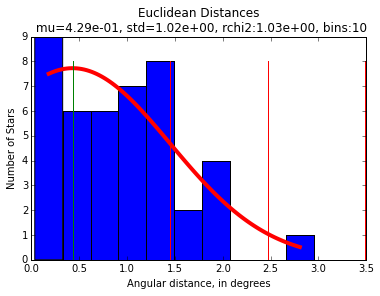

 71%|███████   | 672/946 [3:42:16<2:25:51, 31.94s/it]

selected 35 from 46
35 matches for ngc6025 for tolerance 0.005556
ngc6031
ngc6031 83
Data retrived, starting pbsearch
('searched for a subset of ', 79, 'Coords against 2mass list of', 9073309)

 71%|███████   | 673/946 [3:42:52<2:29:58, 32.96s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6031
ngc6067
ngc6067 10
Data retrived, starting pbsearch
('searched for a subset of ', 8, 'Coords against 2mass list of', 9073309)

 71%|███████   | 674/946 [3:42:57<1:51:44, 24.65s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6067
ngc6087
ngc6087 89
Data retrived, starting pbsearch
('searched for a subset of ', 89, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 80, 'with a tolerance of ', 0.005556)
using 10 bins
ngc6087

 71%|███████▏  | 675/946 [3:43:37<2:12:12, 29.27s/it]

 had error with optimize.curve_fit
ngc6124
error with parsing mags html

 71%|███████▏  | 676/946 [3:43:42<1:39:45, 22.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6124+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6124
ngc6134
ngc6134 31
Data retrived, starting pbsearch
('searched for a subset of ', 31, 'Coords against 2mass list of', 9073309)

 72%|███████▏  | 677/946 [3:43:57<1:29:28, 19.96s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6134
ngc6152
error with parsing mags html

 72%|███████▏  | 678/946 [3:44:00<1:05:44, 14.72s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6152+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6152
ngc6167
ngc6167

 72%|███████▏  | 679/946 [3:44:02<48:10, 10.83s/it]  

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6167
ngc6169
error with parsing mags html

 72%|███████▏  | 680/946 [3:44:03<35:46,  8.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6169+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6169
ngc6178
error with parsing mags html

 72%|███████▏  | 681/946 [3:44:06<28:04,  6.35s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6178+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6178
ngc6192
ngc6192 82
Data retrived, starting pbsearch
('searched for a subset of ', 82, 'Coords against 2mass list of', 9073309)

 72%|███████▏  | 682/946 [3:44:42<1:07:37, 15.37s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6192
ngc6193
ngc6193 216
Data retrived, starting pbsearch
('searched for a subset of ', 176, 'Coords against 2mass list of', 9073309)

 72%|███████▏  | 683/946 [3:45:58<2:27:49, 33.72s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6193
ngc6200
error with parsing mags html

 72%|███████▏  | 684/946 [3:46:02<1:47:37, 24.65s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6200+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6200
ngc6204
error with parsing mags html

 72%|███████▏  | 685/946 [3:46:05<1:18:49, 18.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6204+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6204
ngc6208
ngc6208 21
Data retrived, starting pbsearch
('searched for a subset of ', 21, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 18, 'with a tolerance of ', 0.005556)
using

 73%|███████▎  | 686/946 [3:46:15<1:08:45, 15.87s/it]

 10 bins
Power_divergenceResult(statistic=3.6291964785877286e+17, pvalue=0.0) 5.18456639798e+16
Error with reduced chi squared: 5.18456639798e+16 for ngc6208
ngc6231
error with parsing mags html

 73%|███████▎  | 687/946 [3:46:19<52:46, 12.23s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6231+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6231
ngc6242
ngc6242 146
Data retrived, starting pbsearch
('searched for a subset of ', 127, 'Coords against 2mass list of', 9073309)

 73%|███████▎  | 688/946 [3:47:14<1:47:49, 25.07s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6242
ngc6249
error with parsing mags html

 73%|███████▎  | 689/946 [3:47:18<1:19:32, 18.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6249+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6249
ngc6250
error with parsing mags html

 73%|███████▎  | 690/946 [3:47:20<58:18, 13.66s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6250+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6250
ngc6253
error with parsing coords html

 73%|███████▎  | 691/946 [3:47:46<1:14:35, 17.55s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6253+ad2k+ad2000.coo
Retrieval error. Skipping ngc6253
ngc6259
ngc6259 38
Data retrived, starting pbsearch
('searched for a subset of ', 38, 'Coords against 2mass list of', 9073309)

 73%|███████▎  | 692/946 [3:48:04<1:14:31, 17.61s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6259
ngc6268
ngc6268 86
Data retrived, starting pbsearch
('searched for a subset of ', 72, 'Coords against 2mass list of', 9073309)

 73%|███████▎  | 693/946 [3:48:37<1:33:31, 22.18s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6268
ngc6281
error with parsing mags html

 73%|███████▎  | 694/946 [3:48:40<1:08:29, 16.31s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6281+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6281
ngc6318
error with parsing mags html

 73%|███████▎  | 695/946 [3:48:43<52:30, 12.55s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6318+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6318
ngc6322
ngc6322 80
Data retrived, starting pbsearch
('searched for a subset of ', 61, 'Coords against 2mass list of', 9073309)

 74%|███████▎  | 696/946 [3:49:11<1:11:15, 17.10s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6322
ngc6383
ngc6383 764
Data retrived, starting pbsearch
('searched for a subset of ', 554, 'Coords against 2mass list of', 9073309)

 74%|███████▎  | 697/946 [3:53:44<6:29:50, 93.94s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6383
ngc6396
error with parsing mags html

 74%|███████▍  | 698/946 [3:53:47<4:35:04, 66.55s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6396+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6396
ngc6400
error with parsing mags html

 74%|███████▍  | 699/946 [3:53:49<3:13:45, 47.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6400+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6400
ngc6405
ngc6405 659
Data retrived, starting pbsearch
('searched for a subset of ', 640, 'Coords against 2mass list of', 9073309)

 74%|███████▍  | 700/946 [3:58:21<7:50:27, 114.75s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6405
ngc6416
ngc6416 68
Data retrived, starting pbsearch
('searched for a subset of ', 68, 'Coords against 2mass list of', 9073309)

 74%|███████▍  | 701/946 [3:58:51<6:04:50, 89.35s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6416
ngc6425
ngc6425 80
Data retrived, starting pbsearch
('searched for a subset of ', 69, 'Coords against 2mass list of', 9073309)

 74%|███████▍  | 702/946 [3:59:24<4:54:16, 72.36s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6425
ngc6444
error with parsing mags html

 74%|███████▍  | 703/946 [3:59:26<3:27:12, 51.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6444+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6444
ngc6469
error with parsing mags html

 74%|███████▍  | 704/946 [3:59:28<2:26:31, 36.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6469+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6469
ngc6475
error with parsing mags html

 75%|███████▍  | 705/946 [3:59:32<1:47:00, 26.64s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6475+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6475
ngc6494
ngc6494 52
Data retrived, starting pbsearch
('searched for a subset of ', 52, 'Coords against 2mass list of', 9073309)

 75%|███████▍  | 706/946 [3:59:56<1:43:30, 25.88s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6494
ngc6507
error with parsing coords html

 75%|███████▍  | 707/946 [4:00:08<1:26:47, 21.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6507+ad2k+ad2000.coo
Retrieval error. Skipping ngc6507
ngc6514
ngc6514 18
Data retrived, starting pbsearch
('searched for a subset of ', 18, 'Coords against 2mass list of', 9073309)

 75%|███████▍  | 708/946 [4:00:17<1:11:27, 18.01s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6514
ngc6520
error with parsing mags html

 75%|███████▍  | 709/946 [4:01:15<1:58:01, 29.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6520+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6520
ngc6530
error with parsing coords html

 75%|███████▌  | 710/946 [4:01:18<1:26:42, 22.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6530+ad2k+ad2000.coo
Retrieval error. Skipping ngc6530
ngc6531
ngc6531 426
Data retrived, starting pbsearch
('searched for a subset of ', 371, 'Coords against 2mass list of', 9073309)

 75%|███████▌  | 711/946 [4:04:02<4:12:20, 64.43s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6531
ngc6546
error with parsing mags html

 75%|███████▌  | 712/946 [4:04:05<2:59:43, 46.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6546+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6546
ngc6561
error with parsing mags html

 75%|███████▌  | 713/946 [4:04:07<2:07:12, 32.76s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6561+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6561
ngc6568
error with parsing mags html

 75%|███████▌  | 714/946 [4:04:08<1:30:41, 23.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6568+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6568
ngc6596
error with parsing mags html

 76%|███████▌  | 715/946 [4:04:10<1:05:07, 16.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6596+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6596
ngc6604
ngc6604 113
Data retrived, starting pbsearch
('searched for a subset of ', 86, 'Coords against 2mass list of', 9073309)

 76%|███████▌  | 716/946 [4:04:48<1:29:21, 23.31s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6604
ngc6611
error with parsing mags html

 76%|███████▌  | 717/946 [4:07:11<3:45:28, 59.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6611+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6611
ngc6613
ngc6613 169
Data retrived, starting pbsearch
('searched for a subset of ', 105, 'Coords against 2mass list of', 9073309)

 76%|███████▌  | 718/946 [4:07:57<3:30:15, 55.33s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6613
ngc6618
ngc6618 42
Data retrived, starting pbsearch
('searched for a subset of ', 41, 'Coords against 2mass list of', 9073309)

 76%|███████▌  | 719/946 [4:08:16<2:48:03, 44.42s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6618
ngc6625
error with parsing coords html

 76%|███████▌  | 720/946 [4:08:19<2:00:22, 31.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6625+ad2k+ad2000.coo
Retrieval error. Skipping ngc6625
ngc6633
error with parsing coords html

 76%|███████▌  | 721/946 [4:08:20<1:24:49, 22.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6633+ad2k+ad2000.coo
Retrieval error. Skipping ngc6633
ngc6639
error with parsing mags html

 76%|███████▋  | 722/946 [4:08:22<1:01:03, 16.35s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6639+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6639
ngc6645
error with parsing coords html

 76%|███████▋  | 723/946 [4:08:31<52:59, 14.26s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6645+ad2k+ad2000.coo
Retrieval error. Skipping ngc6645
ngc6647
error with parsing coords html

 77%|███████▋  | 724/946 [4:08:38<44:13, 11.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6647+ad2k+ad2000.coo
Retrieval error. Skipping ngc6647
ngc6649
ngc6649 21
Data retrived, starting pbsearch
('searched for a subset of ', 21, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 725/946 [4:08:48<42:12, 11.46s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6649
ngc6664
ngc6664 28
Data retrived, starting pbsearch
('searched for a subset of ', 27, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 726/946 [4:09:03<45:17, 12.35s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6664
ngc6694
ngc6694 7
Data retrived, starting pbsearch
('searched for a subset of ', 7, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 727/946 [4:09:07<36:34, 10.02s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6694
ngc6704
ngc6704 21
Data retrived, starting pbsearch
('searched for a subset of ', 21, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 728/946 [4:09:17<36:44, 10.11s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6704
ngc6705
error with parsing mags html

 77%|███████▋  | 729/946 [4:11:49<3:10:05, 52.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6705+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6705
ngc6709
ngc6709 8
Data retrived, starting pbsearch
('searched for a subset of ', 8, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 730/946 [4:11:54<2:18:08, 38.37s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6709
ngc6716
ngc6716 335
Data retrived, starting pbsearch
('searched for a subset of ', 335, 'Coords against 2mass list of', 9073309)

 77%|███████▋  | 731/946 [4:14:17<4:09:58, 69.76s/it]


('Coord matches: ', 310, 'with a tolerance of ', 0.005556)
ngc6716 had no repeats
ngc6716 had error with histogram
ngc6728
error with parsing mags html

 77%|███████▋  | 732/946 [4:14:20<2:57:28, 49.76s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6728+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6728
ngc6737
error with parsing mags html

 77%|███████▋  | 733/946 [4:14:25<2:08:47, 36.28s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6737+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6737
ngc6738
error with parsing mags html

 78%|███████▊  | 734/946 [4:15:01<2:07:42, 36.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6738+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6738
ngc6755
ngc6755 148
Data retrived, starting pbsearch
('searched for a subset of ', 132, 'Coords against 2mass list of', 9073309)

 78%|███████▊  | 735/946 [4:17:42<4:19:00, 73.65s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6755
ngc6791
error with parsing coords html

 78%|███████▊  | 736/946 [4:18:01<3:20:33, 57.30s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6791+ad2k+ad2000.coo
Retrieval error. Skipping ngc6791
ngc6793
error with parsing mags html

 78%|███████▊  | 737/946 [4:18:03<2:21:22, 40.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6793+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6793
ngc6800
error with parsing mags html

 78%|███████▊  | 738/946 [4:18:05<1:40:08, 28.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6800+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6800
ngc6802
ngc6802 12
Data retrived, starting pbsearch
('searched for a subset of ', 12, 'Coords against 2mass list of', 9073309)

 78%|███████▊  | 739/946 [4:18:11<1:16:34, 22.20s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6802
ngc6811
ngc6811 39
Data retrived, starting pbsearch
('searched for a subset of ', 39, 'Coords against 2mass list of', 9073309)

 78%|███████▊  | 740/946 [4:18:29<1:12:08, 21.01s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6811
ngc6819
error with parsing coords html

 78%|███████▊  | 741/946 [4:19:20<1:41:53, 29.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6819+ad2k+ad2000.coo
Retrieval error. Skipping ngc6819
ngc6823
ngc6823 518
Data retrived, starting pbsearch
('searched for a subset of ', 518, 'Coords against 2mass list of', 9073309)

 78%|███████▊  | 742/946 [4:23:01<4:56:58, 87.35s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6823
ngc6828
error with parsing mags html

 79%|███████▊  | 743/946 [4:23:03<3:28:30, 61.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6828+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6828
ngc6830
ngc6830 4
Data retrived, starting pbsearch
('searched for a subset of ', 4, 'Coords against 2mass list of', 9073309)

 79%|███████▊  | 744/946 [4:23:06<2:28:26, 44.09s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6830
ngc6834
ngc6834 2
Data retrived, starting pbsearch
('searched for a subset of ', 2, 'Coords against 2mass list of', 9073309)

 79%|███████▉  | 745/946 [4:23:08<1:45:45, 31.57s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6834
ngc6863
error with parsing mags html

 79%|███████▉  | 746/946 [4:23:11<1:15:50, 22.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6863+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6863
ngc6866
error with parsing mags html

 79%|███████▉  | 747/946 [4:23:12<54:35, 16.46s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6866+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6866
ngc6871
ngc6871 35
Data retrived, starting pbsearch
('searched for a subset of ', 30, 'Coords against 2mass list of', 9073309)

 79%|███████▉  | 748/946 [4:23:39<1:04:33, 19.56s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6871
ngc6883
error with parsing mags html

 79%|███████▉  | 749/946 [4:23:41<46:47, 14.25s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6883+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6883
ngc6910
ngc6910 40
Data retrived, starting pbsearch
('searched for a subset of ', 31, 'Coords against 2mass list of', 9073309)

 79%|███████▉  | 750/946 [4:23:57<48:03, 14.71s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6910
ngc6913
ngc6913 411
Data retrived, starting pbsearch
('searched for a subset of ', 328, 'Coords against 2mass list of', 9073309)

 79%|███████▉  | 751/946 [4:26:17<2:50:08, 52.35s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6913
ngc6939
ngc6939 695
Data retrived, starting pbsearch
('searched for a subset of ', 695, 'Coords against 2mass list of', 9073309)

 79%|███████▉  | 752/946 [4:31:44<7:15:26, 134.67s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6939
ngc6940
ngc6940 57
Data retrived, starting pbsearch
('searched for a subset of ', 57, 'Coords against 2mass list of', 9073309)

 80%|███████▉  | 753/946 [4:32:12<5:30:11, 102.65s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc6940
ngc6991
error with parsing mags html

 80%|███████▉  | 754/946 [4:32:14<3:52:24, 72.63s/it] 


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6991+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6991
ngc6994
error with parsing coords html

 80%|███████▉  | 755/946 [4:32:15<2:42:44, 51.13s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6994+ad2k+ad2000.coo
Retrieval error. Skipping ngc6994
ngc6997
error with parsing mags html

 80%|███████▉  | 756/946 [4:33:08<2:43:48, 51.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc6997+ubvpg+ubv.pgo
Retrieval error. Skipping ngc6997
ngc7031
ngc7031 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 80%|████████  | 757/946 [4:33:13<1:57:59, 37.46s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7031
ngc7039
ngc7039 4
Data retrived, starting pbsearch
('searched for a subset of ', 4, 'Coords against 2mass list of', 9073309)

 80%|████████  | 758/946 [4:33:16<1:25:11, 27.19s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7039
ngc7044
error with parsing mags html

 80%|████████  | 759/946 [4:33:36<1:18:28, 25.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7044+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7044
ngc7058
error with parsing mags html

 80%|████████  | 760/946 [4:33:38<56:24, 18.20s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7058+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7058
ngc7062
ngc7062 12
Data retrived, starting pbsearch
('searched for a subset of ', 12, 'Coords against 2mass list of', 9073309)

 80%|████████  | 761/946 [4:33:45<45:41, 14.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7062
ngc7063
ngc7063 9
Data retrived, starting pbsearch
('searched for a subset of ', 9, 'Coords against 2mass list of', 9073309)

 81%|████████  | 762/946 [4:33:51<36:54, 12.04s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7063
ngc7067
ngc7067 13
Data retrived, starting pbsearch
('searched for a subset of ', 13, 'Coords against 2mass list of', 9073309)

 81%|████████  | 763/946 [4:33:58<32:01, 10.50s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7067
ngc7082
ngc7082 64
Data retrived, starting pbsearch
('searched for a subset of ', 64, 'Coords against 2mass list of', 9073309)

 81%|████████  | 764/946 [4:34:26<48:07, 15.86s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7082
ngc7086
ngc7086 150
Data retrived, starting pbsearch
('searched for a subset of ', 150, 'Coords against 2mass list of', 9073309)

 81%|████████  | 765/946 [4:35:31<1:31:55, 30.47s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7086
ngc7092
ngc7092 219
Data retrived, starting pbsearch
('searched for a subset of ', 197, 'Coords against 2mass list of', 9073309)

 81%|████████  | 766/946 [4:36:55<2:19:49, 46.61s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7092
ngc7128
ngc7128 2
Data retrived, starting pbsearch
('searched for a subset of ', 2, 'Coords against 2mass list of', 9073309)

 81%|████████  | 767/946 [4:36:58<1:40:23, 33.65s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7128
ngc7129
error with parsing mags html

 81%|████████  | 768/946 [4:37:00<1:11:25, 24.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7129+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7129
ngc7142
ngc7142 38
Data retrived, starting pbsearch
('searched for a subset of ', 38, 'Coords against 2mass list of', 9073309)

 81%|████████▏ | 769/946 [4:37:18<1:05:21, 22.15s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7142
ngc7160
ngc7160 22
Data retrived, starting pbsearch
('searched for a subset of ', 22, 'Coords against 2mass list of', 9073309)

 81%|████████▏ | 770/946 [4:37:29<55:12, 18.82s/it]  


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7160
ngc7209
ngc7209 38
Data retrived, starting pbsearch
('searched for a subset of ', 22, 'Coords against 2mass list of', 9073309)

 82%|████████▏ | 771/946 [4:37:40<48:36, 16.67s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7209
ngc7235
error with parsing mags html

 82%|████████▏ | 772/946 [4:37:46<38:37, 13.32s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7235+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7235
ngc7243
error with parsing mags html

 82%|████████▏ | 773/946 [4:38:06<44:39, 15.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7243+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7243
ngc7245
ngc7245

 82%|████████▏ | 774/946 [4:38:16<39:28, 13.77s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7245
ngc7261
ngc7261 17
Data retrived, starting pbsearch
('searched for a subset of ', 17, 'Coords against 2mass list of', 9073309)

 82%|████████▏ | 775/946 [4:38:28<37:58, 13.33s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7261
ngc7281
error with parsing mags html

 82%|████████▏ | 776/946 [4:38:30<27:59,  9.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7281+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7281
ngc7296
error with parsing mags html

 82%|████████▏ | 777/946 [4:38:34<22:25,  7.96s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7296+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7296
ngc7380
ngc7380 562
Data retrived, starting pbsearch
('searched for a subset of ', 562, 'Coords against 2mass list of', 9073309)

 82%|████████▏ | 778/946 [4:42:34<3:37:46, 77.78s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7380
ngc7419
ngc7419 91
Data retrived, starting pbsearch
('searched for a subset of ', 69, 'Coords against 2mass list of', 9073309)

 82%|████████▏ | 779/946 [4:43:17<3:07:09, 67.24s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7419
ngc7438
error with parsing mags html

 82%|████████▏ | 780/946 [4:43:19<2:11:45, 47.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7438+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7438
ngc7510
ngc7510 16
Data retrived, starting pbsearch
('searched for a subset of ', 16, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 781/946 [4:43:27<1:38:26, 35.79s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7510
ngc7654
ngc7654 1656
Data retrived, starting pbsearch
('searched for a subset of ', 1624, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 782/946 [4:55:34<11:04:47, 243.22s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7654
ngc7686
ngc7686 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 783/946 [4:55:40<7:46:57, 171.88s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7686
ngc7762
ngc7762 324
Data retrived, starting pbsearch
('searched for a subset of ', 301, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 784/946 [4:57:59<7:17:28, 162.02s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7762
ngc7772
error with parsing mags html

 83%|████████▎ | 785/946 [4:58:01<5:06:26, 114.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7772+ubvpg+ubv.pgo
Retrieval error. Skipping ngc7772
ngc7788
ngc7788 11
Data retrived, starting pbsearch
('searched for a subset of ', 11, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 786/946 [4:58:07<3:38:03, 81.77s/it] 


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7788
ngc7789
error with parsing coords html

 83%|████████▎ | 787/946 [4:58:09<2:33:13, 57.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ngc7789+ad2k+ad2000.coo
Retrieval error. Skipping ngc7789
ngc7790
ngc7790 718
Data retrived, starting pbsearch
('searched for a subset of ', 414, 'Coords against 2mass list of', 9073309)

 83%|████████▎ | 788/946 [5:01:12<4:10:54, 95.28s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ngc7790
pimo01
error with parsing mags html

 83%|████████▎ | 789/946 [5:01:14<2:55:51, 67.20s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pimo01+ubvpg+ubv.pgo
Retrieval error. Skipping pimo01
pis01
pis01 19
Data retrived, starting pbsearch
('searched for a subset of ', 19, 'Coords against 2mass list of', 9073309)

 84%|████████▎ | 790/946 [5:01:23<2:09:50, 49.94s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping pis01
pis02
error with parsing coords html

 84%|████████▎ | 791/946 [5:01:25<1:31:34, 35.45s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis02+ad2k+ad2000.coo
Retrieval error. Skipping pis02
pis03
error with parsing mags html

 84%|████████▎ | 792/946 [5:01:30<1:07:44, 26.40s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis03+ubvpg+ubv.pgo
Retrieval error. Skipping pis03
pis04
error with parsing mags html

 84%|████████▍ | 793/946 [5:01:32<48:15, 18.92s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis04+ubvpg+ubv.pgo
Retrieval error. Skipping pis04
pis05
error with parsing mags html

 84%|████████▍ | 794/946 [5:01:33<34:42, 13.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis05+ubvpg+ubv.pgo
Retrieval error. Skipping pis05
pis08
pis08

 84%|████████▍ | 795/946 [5:01:35<25:18, 10.06s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping pis08
pis11
error with parsing mags html

 84%|████████▍ | 796/946 [5:01:40<21:20,  8.53s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis11+ubvpg+ubv.pgo
Retrieval error. Skipping pis11
pis12
error with parsing mags html

 84%|████████▍ | 797/946 [5:01:41<15:59,  6.44s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis12+ubvpg+ubv.pgo
Retrieval error. Skipping pis12
pis16
error with parsing mags html

 84%|████████▍ | 798/946 [5:01:43<12:24,  5.03s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis16+ubvpg+ubv.pgo
Retrieval error. Skipping pis16
pis17
error with parsing mags html

 84%|████████▍ | 799/946 [5:01:45<09:48,  4.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis17+ubvpg+ubv.pgo
Retrieval error. Skipping pis17
pis18
error with parsing mags html

 85%|████████▍ | 800/946 [5:01:54<13:38,  5.61s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis18+ubvpg+ubv.pgo
Retrieval error. Skipping pis18
pis20
error with parsing mags html

 85%|████████▍ | 801/946 [5:01:56<10:40,  4.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis20+ubvpg+ubv.pgo
Retrieval error. Skipping pis20
pis21
error with parsing mags html

 85%|████████▍ | 802/946 [5:01:57<08:36,  3.59s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis21+ubvpg+ubv.pgo
Retrieval error. Skipping pis21
pis22
pis22 3
Data retrived, starting pbsearch
('searched for a subset of ', 3, 'Coords against 2mass list of', 9073309)

 85%|████████▍ | 803/946 [5:02:00<08:06,  3.40s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping pis22
pis24
error with parsing mags html

 85%|████████▍ | 804/946 [5:02:02<06:47,  2.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pis24+ubvpg+ubv.pgo
Retrieval error. Skipping pis24
pl01
error with parsing coords html

 85%|████████▌ | 805/946 [5:02:03<05:18,  2.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pl01+ad2k+ad2000.coo
Retrieval error. Skipping pl01
pl02
error with parsing mags html

 85%|████████▌ | 806/946 [5:02:07<06:50,  2.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pl02+ubvpg+ubv.pgo
Retrieval error. Skipping pl02
pl04
error with parsing mags html

 85%|████████▌ | 807/946 [5:02:11<06:57,  3.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pl04+ubvpg+ubv.pgo
Retrieval error. Skipping pl04
pl06
error with parsing mags html

 85%|████████▌ | 808/946 [5:02:16<08:47,  3.82s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?pl06+ubvpg+ubv.pgo
Retrieval error. Skipping pl06
ros01
error with parsing mags html

 86%|████████▌ | 809/946 [5:02:18<07:11,  3.15s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ros01+ubvpg+ubv.pgo
Retrieval error. Skipping ros01
ros02
error with parsing mags html

 86%|████████▌ | 810/946 [5:02:19<06:05,  2.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ros02+ubvpg+ubv.pgo
Retrieval error. Skipping ros02
ros03
ros03 106
Data retrived, starting pbsearch
('searched for a subset of ', 70, 'Coords against 2mass list of', 9073309)

 86%|████████▌ | 811/946 [5:02:51<25:23, 11.28s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ros03
ros04
error with parsing mags html

 86%|████████▌ | 812/946 [5:02:53<18:48,  8.42s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ros04+ubvpg+ubv.pgo
Retrieval error. Skipping ros04
ros06
error with parsing mags html

 86%|████████▌ | 813/946 [5:02:56<15:09,  6.84s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ros06+ubvpg+ubv.pgo
Retrieval error. Skipping ros06
ros07
error with parsing mags html

 86%|████████▌ | 814/946 [5:02:58<12:00,  5.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ros07+ubvpg+ubv.pgo
Retrieval error. Skipping ros07
ru001
error with parsing mags html

 86%|████████▌ | 815/946 [5:03:00<09:27,  4.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru001+ubvpg+ubv.pgo
Retrieval error. Skipping ru001
ru010
error with parsing mags html

 86%|████████▋ | 816/946 [5:03:21<20:35,  9.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru010+ubvpg+ubv.pgo
Retrieval error. Skipping ru010
ru012
error with parsing mags html

 86%|████████▋ | 817/946 [5:03:23<15:21,  7.14s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru012+ubvpg+ubv.pgo
Retrieval error. Skipping ru012
ru018
error with parsing mags html

 86%|████████▋ | 818/946 [5:03:24<11:43,  5.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru018+ubvpg+ubv.pgo
Retrieval error. Skipping ru018
ru020
error with parsing mags html

 87%|████████▋ | 819/946 [5:03:26<09:10,  4.34s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru020+ubvpg+ubv.pgo
Retrieval error. Skipping ru020
ru026
error with parsing mags html

 87%|████████▋ | 820/946 [5:03:28<07:35,  3.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru026+ubvpg+ubv.pgo
Retrieval error. Skipping ru026
ru027
error with parsing mags html

 87%|████████▋ | 821/946 [5:03:30<06:22,  3.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru027+ubvpg+ubv.pgo
Retrieval error. Skipping ru027
ru031
error with parsing mags html

 87%|████████▋ | 822/946 [5:03:31<05:25,  2.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru031+ubvpg+ubv.pgo
Retrieval error. Skipping ru031
ru032
error with parsing mags html

 87%|████████▋ | 823/946 [5:03:33<04:46,  2.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru032+ubvpg+ubv.pgo
Retrieval error. Skipping ru032
ru034
error with parsing mags html

 87%|████████▋ | 824/946 [5:03:35<04:17,  2.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru034+ubvpg+ubv.pgo
Retrieval error. Skipping ru034
ru036
error with parsing mags html

 87%|████████▋ | 825/946 [5:03:37<04:22,  2.17s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru036+ubvpg+ubv.pgo
Retrieval error. Skipping ru036
ru043
error with parsing mags html

 87%|████████▋ | 826/946 [5:03:39<04:19,  2.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru043+ubvpg+ubv.pgo
Retrieval error. Skipping ru043
ru044
ru044 26
Data retrived, starting pbsearch
('searched for a subset of ', 21, 'Coords against 2mass list of', 9073309)

 87%|████████▋ | 827/946 [5:03:50<09:35,  4.84s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ru044
ru046
error with parsing mags html

 88%|████████▊ | 828/946 [5:03:52<07:36,  3.87s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru046+ubvpg+ubv.pgo
Retrieval error. Skipping ru046
ru047
error with parsing mags html

 88%|████████▊ | 829/946 [5:03:53<06:16,  3.21s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru047+ubvpg+ubv.pgo
Retrieval error. Skipping ru047
ru049
error with parsing mags html

 88%|████████▊ | 830/946 [5:03:55<05:16,  2.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru049+ubvpg+ubv.pgo
Retrieval error. Skipping ru049
ru053
error with parsing mags html

 88%|████████▊ | 831/946 [5:03:57<04:43,  2.46s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru053+ubvpg+ubv.pgo
Retrieval error. Skipping ru053
ru055
ru055 38
Data retrived, starting pbsearch
('searched for a subset of ', 36, 'Coords against 2mass list of', 9073309)

 88%|████████▊ | 832/946 [5:04:14<12:57,  6.82s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ru055
ru056
error with parsing mags html

 88%|████████▊ | 833/946 [5:04:16<10:09,  5.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru056+ubvpg+ubv.pgo
Retrieval error. Skipping ru056
ru058
error with parsing mags html

 88%|████████▊ | 834/946 [5:04:25<11:53,  6.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru058+ubvpg+ubv.pgo
Retrieval error. Skipping ru058
ru059
error with parsing mags html

 88%|████████▊ | 835/946 [5:04:26<09:07,  4.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru059+ubvpg+ubv.pgo
Retrieval error. Skipping ru059
ru064
error with parsing mags html

 88%|████████▊ | 836/946 [5:04:29<07:51,  4.29s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru064+ubvpg+ubv.pgo
Retrieval error. Skipping ru064
ru065
error with parsing mags html

 88%|████████▊ | 837/946 [5:04:31<06:25,  3.53s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru065+ubvpg+ubv.pgo
Retrieval error. Skipping ru065
ru067
error with parsing mags html

 89%|████████▊ | 838/946 [5:04:32<05:19,  2.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru067+ubvpg+ubv.pgo
Retrieval error. Skipping ru067
ru071
error with parsing mags html

 89%|████████▊ | 839/946 [5:04:34<04:31,  2.54s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru071+ubvpg+ubv.pgo
Retrieval error. Skipping ru071
ru072
error with parsing mags html

 89%|████████▉ | 840/946 [5:04:55<14:07,  8.00s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru072+ubvpg+ubv.pgo
Retrieval error. Skipping ru072
ru076
error with parsing mags html

 89%|████████▉ | 841/946 [5:04:57<10:49,  6.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru076+ubvpg+ubv.pgo
Retrieval error. Skipping ru076
ru079
ru079 20
Data retrived, starting pbsearch
('searched for a subset of ', 18, 'Coords against 2mass list of', 9073309)

 89%|████████▉ | 842/946 [5:05:10<14:39,  8.46s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ru079
ru080
error with parsing mags html

 89%|████████▉ | 843/946 [5:05:12<10:57,  6.39s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru080+ubvpg+ubv.pgo
Retrieval error. Skipping ru080
ru084
error with parsing mags html

 89%|████████▉ | 844/946 [5:05:13<08:22,  4.93s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru084+ubvpg+ubv.pgo
Retrieval error. Skipping ru084
ru085
error with parsing mags html

 89%|████████▉ | 845/946 [5:05:15<06:37,  3.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru085+ubvpg+ubv.pgo
Retrieval error. Skipping ru085
ru090
error with parsing mags html

 89%|████████▉ | 846/946 [5:05:17<05:25,  3.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru090+ubvpg+ubv.pgo
Retrieval error. Skipping ru090
ru091
error with parsing mags html

 90%|████████▉ | 847/946 [5:05:19<04:49,  2.92s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru091+ubvpg+ubv.pgo
Retrieval error. Skipping ru091
ru093
error with parsing mags html

 90%|████████▉ | 848/946 [5:07:55<1:20:02, 49.01s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru093+ubvpg+ubv.pgo
Retrieval error. Skipping ru093
ru094
error with parsing mags html

 90%|████████▉ | 849/946 [5:07:57<56:22, 34.87s/it]  


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru094+ubvpg+ubv.pgo
Retrieval error. Skipping ru094
ru096
error with parsing mags html

 90%|████████▉ | 850/946 [5:07:59<39:48, 24.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru096+ubvpg+ubv.pgo
Retrieval error. Skipping ru096
ru097
ru097 6
Data retrived, starting pbsearch
('searched for a subset of ', 6, 'Coords against 2mass list of', 9073309)

 90%|████████▉ | 851/946 [5:08:03<29:33, 18.67s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ru097
ru098
error with parsing mags html

 90%|█████████ | 852/946 [5:08:05<21:14, 13.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru098+ubvpg+ubv.pgo
Retrieval error. Skipping ru098
ru099
error with parsing mags html

 90%|█████████ | 853/946 [5:08:07<15:40, 10.12s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru099+ubvpg+ubv.pgo
Retrieval error. Skipping ru099
ru105
error with parsing mags html

 90%|█████████ | 854/946 [5:08:08<11:35,  7.56s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru105+ubvpg+ubv.pgo
Retrieval error. Skipping ru105
ru107
error with parsing mags html

 90%|█████████ | 855/946 [5:08:10<08:43,  5.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru107+ubvpg+ubv.pgo
Retrieval error. Skipping ru107
ru108
error with parsing mags html

 90%|█████████ | 856/946 [5:08:11<06:44,  4.49s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru108+ubvpg+ubv.pgo
Retrieval error. Skipping ru108
ru110
error with parsing mags html

 91%|█████████ | 857/946 [5:08:13<05:26,  3.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru110+ubvpg+ubv.pgo
Retrieval error. Skipping ru110
ru113
error with parsing mags html

 91%|█████████ | 858/946 [5:08:15<04:43,  3.23s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru113+ubvpg+ubv.pgo
Retrieval error. Skipping ru113
ru116
error with parsing mags html

 91%|█████████ | 859/946 [5:08:17<03:57,  2.73s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru116+ubvpg+ubv.pgo
Retrieval error. Skipping ru116
ru118
error with parsing mags html

 91%|█████████ | 860/946 [5:08:19<03:27,  2.41s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru118+ubvpg+ubv.pgo
Retrieval error. Skipping ru118
ru119
error with parsing mags html

 91%|█████████ | 861/946 [5:08:25<05:13,  3.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru119+ubvpg+ubv.pgo
Retrieval error. Skipping ru119
ru125
error with parsing mags html

 91%|█████████ | 862/946 [5:08:27<04:20,  3.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru125+ubvpg+ubv.pgo
Retrieval error. Skipping ru125
ru127
error with parsing mags html

 91%|█████████ | 863/946 [5:08:30<04:06,  2.98s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru127+ubvpg+ubv.pgo
Retrieval error. Skipping ru127
ru131
error with parsing mags html

 91%|█████████▏| 864/946 [5:08:31<03:30,  2.57s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru131+ubvpg+ubv.pgo
Retrieval error. Skipping ru131
ru135
error with parsing mags html

 91%|█████████▏| 865/946 [5:08:34<03:30,  2.60s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru135+ubvpg+ubv.pgo
Retrieval error. Skipping ru135
ru137
error with parsing mags html

 92%|█████████▏| 866/946 [5:08:40<04:55,  3.69s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru137+ubvpg+ubv.pgo
Retrieval error. Skipping ru137
ru138
error with parsing coords html

 92%|█████████▏| 867/946 [5:08:42<04:02,  3.07s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru138+ad2k+ad2000.coo
Retrieval error. Skipping ru138
ru139
error with parsing mags html

 92%|█████████▏| 868/946 [5:08:44<03:28,  2.68s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru139+ubvpg+ubv.pgo
Retrieval error. Skipping ru139
ru140
error with parsing mags html

 92%|█████████▏| 869/946 [5:08:50<04:41,  3.66s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru140+ubvpg+ubv.pgo
Retrieval error. Skipping ru140
ru141
error with parsing mags html

 92%|█████████▏| 870/946 [5:08:51<03:49,  3.02s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru141+ubvpg+ubv.pgo
Retrieval error. Skipping ru141
ru142
error with parsing coords html

 92%|█████████▏| 871/946 [5:08:54<03:51,  3.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru142+ad2k+ad2000.coo
Retrieval error. Skipping ru142
ru145
error with parsing mags html

 92%|█████████▏| 872/946 [5:08:56<03:24,  2.77s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru145+ubvpg+ubv.pgo
Retrieval error. Skipping ru145
ru147
error with parsing mags html

 92%|█████████▏| 873/946 [5:09:02<04:24,  3.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru147+ubvpg+ubv.pgo
Retrieval error. Skipping ru147
ru151
error with parsing mags html

 92%|█████████▏| 874/946 [5:09:04<03:38,  3.04s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru151+ubvpg+ubv.pgo
Retrieval error. Skipping ru151
ru158
error with parsing mags html

 92%|█████████▏| 875/946 [5:09:24<09:53,  8.36s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru158+ubvpg+ubv.pgo
Retrieval error. Skipping ru158
ru161
error with parsing mags html

 93%|█████████▎| 876/946 [5:09:27<07:33,  6.48s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru161+ubvpg+ubv.pgo
Retrieval error. Skipping ru161
ru166
error with parsing mags html

 93%|█████████▎| 877/946 [5:09:28<05:43,  4.98s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru166+ubvpg+ubv.pgo
Retrieval error. Skipping ru166
ru167
error with parsing mags html

 93%|█████████▎| 878/946 [5:09:30<04:31,  3.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru167+ubvpg+ubv.pgo
Retrieval error. Skipping ru167
ru168
error with parsing coords html

 93%|█████████▎| 879/946 [5:09:33<04:22,  3.91s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru168+ad2k+ad2000.coo
Retrieval error. Skipping ru168
ru169
error with parsing coords html

 93%|█████████▎| 880/946 [5:09:36<03:59,  3.63s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru169+ad2k+ad2000.coo
Retrieval error. Skipping ru169
ru171
error with parsing coords html

 93%|█████████▎| 881/946 [5:09:39<03:38,  3.37s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru171+ad2k+ad2000.coo
Retrieval error. Skipping ru171
ru172
error with parsing mags html

 93%|█████████▎| 882/946 [5:09:41<03:02,  2.85s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ru172+ubvpg+ubv.pgo
Retrieval error. Skipping ru172
sau01
error with parsing mags html

 93%|█████████▎| 883/946 [5:09:42<02:33,  2.44s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?sau01+ubvpg+ubv.pgo
Retrieval error. Skipping sau01
sha138
error with parsing coords html

 93%|█████████▎| 884/946 [5:09:43<02:00,  1.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?sha138+ad2k+ad2000.coo
Retrieval error. Skipping sha138
sho01
error with parsing mags html

 94%|█████████▎| 885/946 [5:10:32<16:18, 16.05s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?sho01+ubvpg+ubv.pgo
Retrieval error. Skipping sho01
ski02
error with parsing mags html

 94%|█████████▎| 886/946 [5:10:34<11:56, 11.94s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?ski02+ubvpg+ubv.pgo
Retrieval error. Skipping ski02
st01
error with parsing mags html

 94%|█████████▍| 887/946 [5:10:37<08:56,  9.10s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st01+ubvpg+ubv.pgo
Retrieval error. Skipping st01
st02
error with parsing coords html

 94%|█████████▍| 888/946 [5:10:38<06:31,  6.74s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st02+ad2k+ad2000.coo
Retrieval error. Skipping st02
st04
error with parsing mags html

 94%|█████████▍| 889/946 [5:10:40<04:59,  5.26s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st04+ubvpg+ubv.pgo
Retrieval error. Skipping st04
st05
error with parsing mags html

 94%|█████████▍| 890/946 [5:10:42<03:53,  4.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st05+ubvpg+ubv.pgo
Retrieval error. Skipping st05
st07
st07 13
Data retrived, starting pbsearch
('searched for a subset of ', 13, 'Coords against 2mass list of', 9073309)

 94%|█████████▍| 891/946 [5:10:49<04:35,  5.01s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping st07
st08
error with parsing mags html

 94%|█████████▍| 892/946 [5:11:40<17:05, 18.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st08+ubvpg+ubv.pgo
Retrieval error. Skipping st08
st10
error with parsing mags html

 94%|█████████▍| 893/946 [5:11:42<12:12, 13.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st10+ubvpg+ubv.pgo
Retrieval error. Skipping st10
st12
error with parsing mags html

 95%|█████████▍| 894/946 [5:11:44<08:51, 10.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st12+ubvpg+ubv.pgo
Retrieval error. Skipping st12
st13
error with parsing mags html

 95%|█████████▍| 895/946 [5:11:52<08:07,  9.55s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st13+ubvpg+ubv.pgo
Retrieval error. Skipping st13
st14
error with parsing mags html

 95%|█████████▍| 896/946 [5:11:56<06:33,  7.88s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st14+ubvpg+ubv.pgo
Retrieval error. Skipping st14
st16
error with parsing mags html

 95%|█████████▍| 897/946 [5:12:07<07:15,  8.89s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st16+ubvpg+ubv.pgo
Retrieval error. Skipping st16
st17
error with parsing mags html

 95%|█████████▍| 898/946 [5:12:08<05:21,  6.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st17+ubvpg+ubv.pgo
Retrieval error. Skipping st17
st18
error with parsing coords html

 95%|█████████▌| 899/946 [5:12:13<04:46,  6.09s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st18+ad2k+ad2000.coo
Retrieval error. Skipping st18
st20
error with parsing mags html

 95%|█████████▌| 900/946 [5:12:15<03:39,  4.78s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st20+ubvpg+ubv.pgo
Retrieval error. Skipping st20
st21
error with parsing mags html

 95%|█████████▌| 901/946 [5:12:17<02:52,  3.84s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st21+ubvpg+ubv.pgo
Retrieval error. Skipping st21
st23
error with parsing mags html

 95%|█████████▌| 902/946 [5:12:18<02:21,  3.21s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?st23+ubvpg+ubv.pgo
Retrieval error. Skipping st23
ste01
ste01 134
Data retrived, starting pbsearch
('searched for a subset of ', 96, 'Coords against 2mass list of', 9073309)

 95%|█████████▌| 903/946 [5:13:01<10:47, 15.05s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping ste01
to01
error with parsing mags html

 96%|█████████▌| 904/946 [5:13:03<07:44, 11.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?to01+ubvpg+ubv.pgo
Retrieval error. Skipping to01
to02
error with parsing mags html

 96%|█████████▌| 905/946 [5:13:05<05:41,  8.33s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?to02+ubvpg+ubv.pgo
Retrieval error. Skipping to02
to04
error with parsing mags html

 96%|█████████▌| 906/946 [5:13:09<04:44,  7.11s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?to04+ubvpg+ubv.pgo
Retrieval error. Skipping to04
to05
error with parsing mags html

 96%|█████████▌| 907/946 [5:13:33<07:51, 12.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?to05+ubvpg+ubv.pgo
Retrieval error. Skipping to05
tr01
tr01 15
Data retrived, starting pbsearch
('searched for a subset of ', 15, 'Coords against 2mass list of', 9073309)

 96%|█████████▌| 908/946 [5:13:41<06:53, 10.89s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr01
tr02
tr02 27
Data retrived, starting pbsearch
('searched for a subset of ', 27, 'Coords against 2mass list of', 9073309)

 96%|█████████▌| 909/946 [5:13:54<07:06, 11.53s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr02
tr03
error with parsing mags html

 96%|█████████▌| 910/946 [5:15:13<19:06, 31.86s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr03+ubvpg+ubv.pgo
Retrieval error. Skipping tr03
tr07
error with parsing mags html

 96%|█████████▋| 911/946 [5:15:16<13:27, 23.06s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr07+ubvpg+ubv.pgo
Retrieval error. Skipping tr07
tr09
tr09 28
Data retrived, starting pbsearch
('searched for a subset of ', 28, 'Coords against 2mass list of', 9073309)

 96%|█████████▋| 912/946 [5:15:29<11:26, 20.18s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr09
tr10
error with parsing mags html

 97%|█████████▋| 913/946 [5:15:31<08:06, 14.75s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr10+ubvpg+ubv.pgo
Retrieval error. Skipping tr10
tr12
error with parsing mags html

 97%|█████████▋| 914/946 [5:15:33<05:46, 10.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr12+ubvpg+ubv.pgo
Retrieval error. Skipping tr12
tr14
tr14 80
Data retrived, starting pbsearch
('searched for a subset of ', 80, 'Coords against 2mass list of', 9073309)

 97%|█████████▋| 915/946 [5:16:09<09:27, 18.32s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr14
tr15
tr15 52
Data retrived, starting pbsearch
('searched for a subset of ', 52, 'Coords against 2mass list of', 9073309)

 97%|█████████▋| 916/946 [5:16:34<10:17, 20.57s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr15
tr16
error with parsing mags html

 97%|█████████▋| 917/946 [5:16:38<07:32, 15.62s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr16+ubvpg+ubv.pgo
Retrieval error. Skipping tr16
tr17
tr17 11
Data retrived, starting pbsearch
('searched for a subset of ', 11, 'Coords against 2mass list of', 9073309)

 97%|█████████▋| 918/946 [5:16:45<05:58, 12.80s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr17
tr18
tr18 237
Data retrived, starting pbsearch
('searched for a subset of ', 83, 'Coords against 2mass list of', 9073309)

 97%|█████████▋| 919/946 [5:17:49<12:39, 28.12s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr18
tr20
error with parsing coords html

 97%|█████████▋| 920/946 [5:18:24<13:09, 30.38s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr20+ad2k+ad2000.coo
Retrieval error. Skipping tr20
tr21
error with parsing mags html

 97%|█████████▋| 921/946 [5:18:27<09:12, 22.08s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr21+ubvpg+ubv.pgo
Retrieval error. Skipping tr21
tr22
tr22 71
Data retrived, starting pbsearch
('searched for a subset of ', 71, 'Coords against 2mass list of', 9073309)

 97%|█████████▋| 922/946 [5:18:58<09:56, 24.84s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr22
tr24
tr24 296
Data retrived, starting pbsearch
('searched for a subset of ', 249, 'Coords against 2mass list of', 9073309)

 98%|█████████▊| 923/946 [5:20:45<18:53, 49.29s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr24
tr26
tr26 41
Data retrived, starting pbsearch
('searched for a subset of ', 41, 'Coords against 2mass list of', 9073309)

 98%|█████████▊| 924/946 [5:21:03<14:42, 40.11s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr26
tr27
tr27 48
Data retrived, starting pbsearch
('searched for a subset of ', 38, 'Coords against 2mass list of', 9073309)

 98%|█████████▊| 925/946 [5:21:21<11:41, 33.42s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr27
tr28
tr28 123
Data retrived, starting pbsearch
('searched for a subset of ', 82, 'Coords against 2mass list of', 9073309)

 98%|█████████▊| 926/946 [5:21:58<11:30, 34.54s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr28
tr29
error with parsing mags html

 98%|█████████▊| 927/946 [5:22:00<07:49, 24.70s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr29+ubvpg+ubv.pgo
Retrieval error. Skipping tr29
tr30
error with parsing mags html

 98%|█████████▊| 928/946 [5:22:02<05:20, 17.81s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr30+ubvpg+ubv.pgo
Retrieval error. Skipping tr30
tr31
error with parsing mags html

 98%|█████████▊| 929/946 [5:22:03<03:40, 12.99s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr31+ubvpg+ubv.pgo
Retrieval error. Skipping tr31
tr32
error with parsing coords html

 98%|█████████▊| 930/946 [5:22:05<02:31,  9.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr32+ad2k+ad2000.coo
Retrieval error. Skipping tr32
tr33
error with parsing mags html

 98%|█████████▊| 931/946 [5:22:06<01:47,  7.16s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr33+ubvpg+ubv.pgo
Retrieval error. Skipping tr33
tr34
error with parsing mags html

 99%|█████████▊| 932/946 [5:22:12<01:33,  6.67s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tr34+ubvpg+ubv.pgo
Retrieval error. Skipping tr34
tr35
tr35

 99%|█████████▊| 933/946 [5:22:14<01:07,  5.17s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr35
tr37
tr37

 99%|█████████▊| 934/946 [5:22:16<00:53,  4.44s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tr37
tu01
tu01 4
Data retrived, starting pbsearch
('searched for a subset of ', 4, 'Coords against 2mass list of', 9073309)

 99%|█████████▉| 935/946 [5:22:20<00:45,  4.17s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tu01
tu02
error with parsing mags html

 99%|█████████▉| 936/946 [5:22:31<01:02,  6.22s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tu02+ubvpg+ubv.pgo
Retrieval error. Skipping tu02
tu05
error with parsing mags html

 99%|█████████▉| 937/946 [5:22:39<01:01,  6.79s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?tu05+ubvpg+ubv.pgo
Retrieval error. Skipping tu05
tu09
tu09 23
Data retrived, starting pbsearch
('searched for a subset of ', 23, 'Coords against 2mass list of', 9073309)

 99%|█████████▉| 938/946 [5:22:50<01:04,  8.12s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping tu09
up01
error with parsing mags html

 99%|█████████▉| 939/946 [5:22:52<00:43,  6.18s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?up01+ubvpg+ubv.pgo
Retrieval error. Skipping up01
vdb001
vdb001

 99%|█████████▉| 940/946 [5:22:54<00:29,  4.85s/it]

 0
Data retrived, starting pbsearch
('searched for a subset of ', 0, 'Coords against 2mass list of', 9073309)
('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping vdb001
vdb092
error with parsing mags html

 99%|█████████▉| 941/946 [5:22:55<00:19,  3.95s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?vdb092+ubvpg+ubv.pgo
Retrieval error. Skipping vdb092
vdb113
error with parsing mags html

100%|█████████▉| 942/946 [5:22:57<00:13,  3.35s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?vdb113+ubvpg+ubv.pgo
Retrieval error. Skipping vdb113
wat06
wat06 8
Data retrived, starting pbsearch
('searched for a subset of ', 8, 'Coords against 2mass list of', 9073309)

100%|█████████▉| 943/946 [5:23:02<00:11,  3.83s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping wat06
wat07
wat07 3
Data retrived, starting pbsearch
('searched for a subset of ', 3, 'Coords against 2mass list of', 9073309)

100%|█████████▉| 944/946 [5:23:05<00:07,  3.57s/it]


('Coord matches: ', 0, 'with a tolerance of ', 0.005556)
No matches. Skipping wat07
wes01
error with parsing mags html

100%|█████████▉| 945/946 [5:23:09<00:03,  3.50s/it]


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?wes01+ubvpg+ubv.pgo
Retrieval error. Skipping wes01
wes02
error with parsing mags html


http://www.univie.ac.at/webda/cgi-bin/frame_data_list.cgi?wes02+ubvpg+ubv.pgo
Retrieval error. Skipping wes02
['bl01', 'bo15', 'ho18', 'ic4665', 'mel066', 'mel071', 'ngc1662', 'ngc2204', 'ngc2215', 'ngc2287', 'ngc2506', 'ngc2516', 'ngc2682', 'ngc6087', 'ngc6208', 'ngc6716']


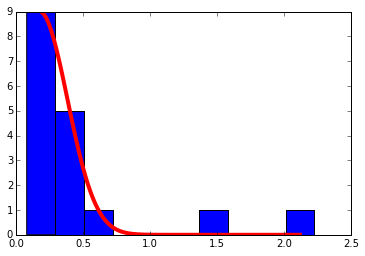

In [7]:
# loop this code over a lot of clusters

names = coordnames
tol = 0.005556
coorddiff = []
errnames = []
for y in tqdm(np.arange(len(names))):

    name = names[y]
    print(name)

    subsetid, subsetra, subsetdec, subsetmid, subsetvmag, subsetbv = getwebda(name)
    if (subsetid) is None:
        print("Retrieval error. Skipping", name)
        continue

    print(name, len(subsetid))
    subsetzip = list(zip(subsetra, subsetdec, subsetvmag, subsetbv, subsetmid,subsetid))
    print("Data retrived, starting pbsearch")
    searched_ra, matched_ra = pbsearch(twomasszip, subsetzip, tol)
    if len(searched_ra) == 0:
        print("No matches. Skipping", name)
        continue

    # take the euclidean distance between coordinates, magnitude, and color
    a = [np.asarray(x[:4]) for x in searched_ra]
    b = [np.asarray(x[:4]) for x in matched_ra]

    dists = [np.linalg.norm(a[i]-b[i]) for i in np.arange(len(a))]
    #plt.hist(dists, bins = 20)
    #plt.show()


    # find the repeat matches, and save those who have the lesser distance
    # how do I quantify how sure I am the lesser one is the true one? 
    try:
        matchedid = []
        searchedid = []
        d = []
        for i in np.arange(len(matched_ra)):
            matchedid.append(matched_ra[i][4])
            searchedid.append(searched_ra[i][4])

        tmp = []
        for j in np.arange(len(searchedid)):
            x = [i for i, y in enumerate(searchedid) if y == searchedid[j]]
            tmp.append(x)

        bar = []
        for entry in np.unique(tmp):
            if len(entry) > 1:
                foo = [dists[x] for x in entry]
                #print(entry, foo)
                minindex = [i for i, j in enumerate(foo) if j == min(foo)]
                minentry = entry[minindex[0]]
                #print(minentry, dists[minentry])
                bar.append(minentry)
            else:
                #print(entry, dists[entry[0]])
                bar.append(entry[0])
    except:
        print(name, "had no repeats")
        bar = np.arange(len(dists))

    try:
        # so bar has the closest ones and the non-repeated ones. How far away are these?
        closest = np.asarray([dists[x] for x in bar])

        # guess a high number of bins
        bins = 20#14
        data = py.hist(closest, bins = bins)

        # is it too small? observed and expected frequencies should be at least 5: http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chisquare.html
        # grab number in each bin, check that most of them are above 5, otherwise decrease bin number and do it again
        thresh = 0.7
        toomanybins = len([x for x in data[0] if x >= 5])/len(data[0]) < thresh

        while toomanybins:
            bins = bins - 1
            data = py.hist(closest, bins = bins)
            toomanybins = len([x for x in data[0] if x >= 5])/len(data[0]) < thresh
        if bins < 10:
            bins = 10
        print("using",bins, "bins")
        plt.close()

        data = py.hist(closest, bins = bins)
        # Generate data from bins as a set of points 
        x = [0.5 * (data[1][i] + data[1][i+1]) for i in range(len(data[1])-1)]
        y = data[0]
    except:
        print(name, "had error with histogram")
        errnames.append(name)
        continue

    try:
        popt, pcov = optimize.curve_fit(gauss, x, y)
    except:
        print(name, "had error with optimize.curve_fit")
        errnames.append(name)
        continue
    x_fit = py.linspace(x[0], x[-1], 100)
    y_fit = gauss(x_fit, *popt)


    plt.plot(x_fit, y_fit, lw=4, color="r")

    cx_fit = py.linspace(x[0], x[-1], len(x))
    cy_fit = gauss(cx_fit, *popt)

    # check degrees of freedom - number of bins I think
    # does this give reduced chi squared? 
    # near 1 is a good fit
    chi2 = (chisquare(f_obs=y,f_exp=cy_fit))
    rchi2 = chi2[0]/(len(x)-3)
    print(chi2, rchi2)
    
    
    if not rchi2 or rchi2 > 6:
        print("Error with reduced chi squared:",rchi2, 'for', name)
        errnames.append(name)
        continue
    
    plt.xlabel('Angular distance, in degrees')
    plt.ylabel('Number of Stars')
    plt.title('Euclidean Distances \n mu={0:.2e}, std={1:.2e}, rchi2:{2:.2e}, bins:{3}'.format(popt[1], popt[2], rchi2, bins))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    # draw mean line
    sx = [popt[1]]*(np.max(data[0]))
    sy = np.arange(np.max(data[0]))
    plt.plot(sx,sy, color="g")
    
    # draw 1,2,3 sigma line
    for i in [1,2,3]:  
        sx = [popt[1]+popt[2]*i]*(np.max(data[0]))
        sy = np.arange(np.max(data[0]))
        plt.plot(sx,sy, color="r")
    plt.show()

    # maybe just take the data w/i 1 sigma of the mean? 

    s = 1
    coordmask = np.asarray([int(dist < (popt[1]+s*popt[2]) and dist > (popt[1]-s*popt[2])) for dist in dists])
    print("selected", sum(coordmask), "from",len(coordmask))
    coordfiltered_searched_ra = np.asarray(searched_ra)[coordmask == 1]
    coordfiltered_matched_ra = np.asarray(matched_ra)[coordmask == 1]



    N = sum(coordmask)
    if N > 0:

        print(N, "matches for", name, "for tolerance", tol)
        filename = "filteredresults/"+name+"_wtol"+str(tol)+"_matched"+str(N)+'.csv'
        # subsetra, subsetdec, subsetvmag, subsetbv, subsetmid, subsetid
        # twomass_ra, twomass_dec, twomass_vmag, twomass_bv, twomass_ident
        header = ["webdacoordid", "webdaras", "webdadecs", "webdamagid", "webdavmags", "webdabv","galahids", "twomassras", "twomassdecs", "twomassvmags", "twomassbv"]
        with open(filename, 'w', newline='') as fp:
            a = csv.writer(fp, delimiter=',')
            a.writerow(header)
            for i in np.arange(N):
                data = [coordfiltered_searched_ra[i][5], coordfiltered_searched_ra[i][0], coordfiltered_searched_ra[i][1], coordfiltered_searched_ra[i][4], coordfiltered_searched_ra[i][2], coordfiltered_searched_ra[i][3], coordfiltered_matched_ra[i][4], coordfiltered_matched_ra[i][0], coordfiltered_matched_ra[i][1], coordfiltered_matched_ra[i][2], coordfiltered_matched_ra[i][3]]
                a.writerow(data)
    else:
        print("No matches for", name, "for tolerance", tol)
        
print(errnames)

In [8]:
len(errnames)

16

['filteredresults/ho18_wtol0.005556_matched3.csv', 'filteredresults/ic4651_wtol0.005556_matched234.csv', 'filteredresults/ic4665_wtol0.005556_matched32.csv', 'filteredresults/ic4756_wtol0.005556_matched81.csv', 'filteredresults/ngc2112_wtol0.005556_matched41.csv', 'filteredresults/ngc2112_wtol0.005556_matched43.csv', 'filteredresults/ngc2204_wtol0.005556_matched20.csv', 'filteredresults/ngc2215_wtol0.005556_matched12.csv', 'filteredresults/ngc2287_wtol0.005556_matched10.csv', 'filteredresults/ngc2354_wtol0.005556_matched40.csv', 'filteredresults/ngc2516_wtol0.005556_matched312.csv', 'filteredresults/ngc2516_wtol0.005556_matched314.csv', 'filteredresults/ngc3680_wtol0.005556_matched39.csv', 'filteredresults/ngc3960_wtol0.005556_matched38.csv', 'filteredresults/ngc6025_wtol0.005556_matched35.csv']


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


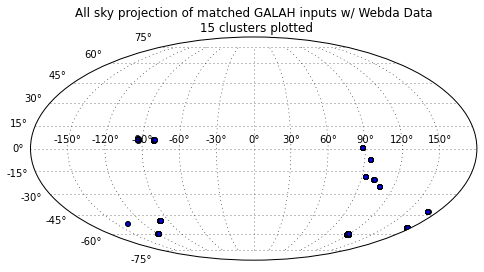

In [179]:
from astropy.io import ascii
import astropy.coordinates as coord
import glob


files = glob.glob("filteredresults/*")

ra_arr = []
dec_arr = []

for file in files:
    data = ascii.read(file, header_start=0, data_start=1)
    ra = coord.Angle(data["twomassras"]*u.degree)
    ra = ra.wrap_at(180*u.degree)
    ra = ra.radian
    ra_arr.extend(ra)

    dec = coord.Angle(data["twomassdecs"]*u.degree)
    dec = dec.radian
    dec_arr.extend(dec)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.grid(True)
ax.scatter(ra_arr, dec_arr)
len(files)
ax.set_title("All sky projection of matched GALAH inputs w/ Webda Data \n {0} clusters plotted".format(len(files)))

In [ ]:
# back up for webda, download files individually
# Read in Webda observed Name, RA, and DEC information
'''

df = pd.read_csv('ad2000.coo', delimiter='\t',index_col=False, header=1)
df.columns = ["ID", "ref", "RA", "DEC"]


coords = [coordconvert(ra, dec) for ra in df["RA"] for dec in df["DEC"]]
subsetra = np.asarray([coord[0] for coord in coords])
subsetdec = np.asarray([coord[1] for coord in coords])
'''

# Read in Gayandhi's 2Mass input database Name, RA, and DEC information
# note this data is presorted by RA
'''

df = pd.read_csv('gsortedgal.csv', delimiter=',',index_col=False, header=0)
df.columns = ["ID", "RA", "DEC"]

# get rid of blank entries
print(len(df))
df = df.loc[(df != 0).any(1)]
print(len(df))
print(df.head())

# assign to np arrays
twomass_ident = np.asarray(df["ID"])
twomass_ra = np.asarray(df["RA"])
twomass_dec = np.asarray(df["DEC"])

'''

# dias data
'''

# Read in DIAS 
# I didn't know an easy way to read in this file so this is very messy and hacked and slow and I apologize


dias_data = np.genfromtxt('dias.txt', delimiter='\t', names=None, dtype=None)
dias_data = dias_data[1:]

data = []
subsetid = []
subsetra = []
subsetdec = []
for line in dias_data:
 
    line = line.decode('UTF-8')

    line = (str(line).split("  "))

    line = np.array(list(filter(None, line)))
    subsetid.append(line[0])
    try:
        c = SkyCoord(line[1], line[2], unit=(u.hourangle, u.deg))
        subsetra.append(c.ra.degree)
        subsetdec.append(c.dec.degree)
    except:
        print("error: ", line)
    data.append(line)
    
# some problems with dec
subsetra = np.asarray(subsetra)
subsetdec = np.asarray(subsetdec)
name = "dias"


'''

[Back to Top](#Table-of-Contents) 
